In [1]:
import numpy as np
from scipy import interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits import mplot3d
%matplotlib inline

from scipy import integrate
import progressbar as pb

import aeg.dielectric_tensor_scattering as dts

import aeg.style as style
from importlib import reload

In [2]:
REF_MASS_RATIO = 20.
REF_EF = 1.

# Lab velocity and basic modulation

In [3]:
from aeg.rate import Scaler, v_earth

In [4]:
s = Scaler(REF_EF)
times = np.linspace(0, 1, 100)
vels = np.vstack([
    v_earth(s, t).numpy().reshape(-1)
    for t in times
])

In [5]:
vhat = vels/np.linalg.norm(vels, axis=1)[:, None]
vxy = np.linalg.norm(vhat[:, [0, 1]], axis=1)/np.linalg.norm(vhat, axis=1)

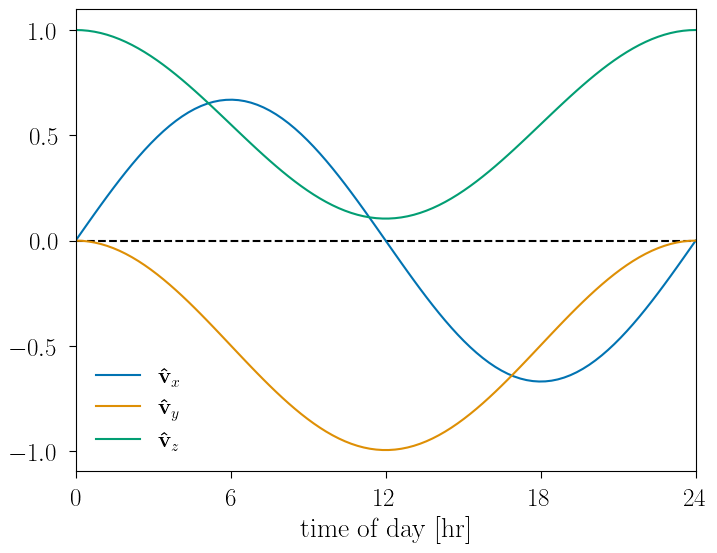

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(style.FIG_SINGLE_SIZE)
ax.axhline(0, c='k', ls='--')
ax.plot(24*times, vels[:, 0]/vels[0, 2], c=style.COLORS[0], label=r'$\bb{\hat{v}}_x$')
ax.plot(24*times, vels[:, 1]/vels[0, 2], c=style.COLORS[1], label=r'$\bb{\hat{v}}_y$')
ax.plot(24*times, vels[:, 2]/vels[0, 2], c=style.COLORS[2], label=r'$\bb{\hat{v}}_z$')
ax.set_xticks([0, 6, 12, 18, 24])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('time of day [hr]')
ax.set_xlim(0., 24.)
ax.legend()
plt.show()

In [9]:
fig.savefig('figures/vlab.pdf', bbox_inches='tight', transparent=True)

## Dipytch version

In [10]:
from aeg.rate import Scaler, rate, mass_vector, make_rate_integrand
from vegasflow import float_me

In [11]:
from aeg.rate import v_earth
import progressbar

In [8]:
reload(dts)

<module 'aeg.dielectric_tensor_scattering' from 'C:\\Users\\betha\\Dropbox\\SrTiO3 DD\\aeg\\dielectric_tensor_scattering.py'>

In [14]:
%%time
s = Scaler(REF_EF)
rate_times = np.linspace(0., 1., 25)
rates_lm = np.zeros_like(rate_times)
rates_hm = np.zeros_like(rate_times)
errs_lm = np.zeros_like(rates_lm)
errs_hm = np.zeros_like(rates_hm)
v_stream = np.array([[[0], [0], [-s.v_0]]])

formula = 'NaMoO2'
material = dts.find_eps(formula)
efermi, kfermi, vfermi, wp = dts.find_fermi_properties(formula)
paramsx = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='xx')
paramsy = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='yy')
paramsz = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='zz')   

for i, time in enumerate(rate_times):
    v = float_me(tf.reshape(v_earth(s, time) - v_stream, (1, 3)))
    rates_lm[i], errs_lm[i] = rate(
        s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO), v=v, n_points=int(1e6), 
        lind_params_x = paramsx, lind_params_y = paramsy, lind_params_z = paramsz, kfermi = kfermi, vfermi = vfermi
    )
    rates_hm[i], errs_hm[i] = rate(
        s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO), v=v, m_med=1000, n_points=int(1e6), 
        lind_params_x = paramsx, lind_params_y = paramsy, lind_params_z = paramsz, kfermi = kfermi, vfermi = vfermi
    )

CPU times: total: 49min 36sg device: 100.0 %
Wall time: 20min 14s


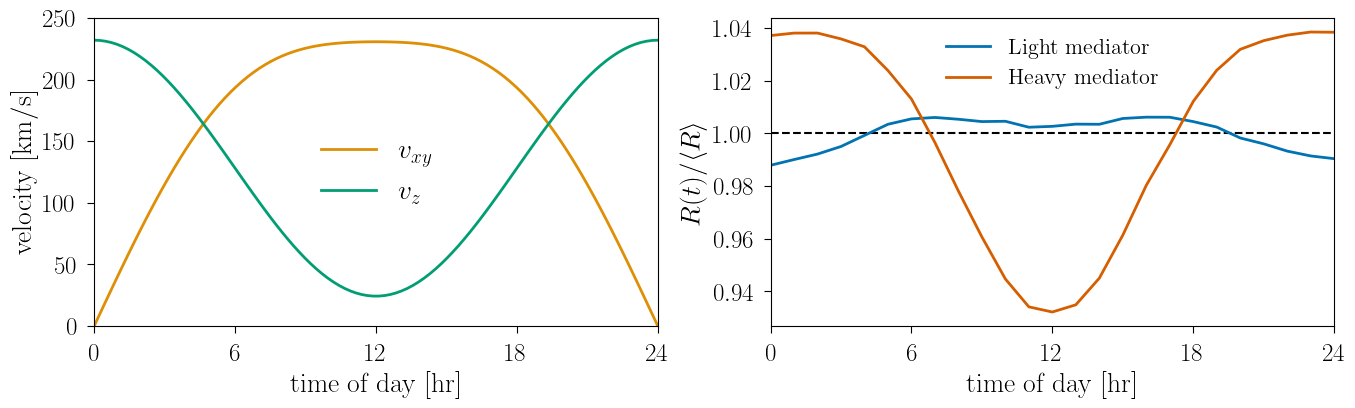

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE[0], style.FIG_DOUBLE_SIZE[1]/1.5)

for ax in (ax1, ax2):
    ax.set_xlim(0., 24.)
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xlabel('time of day [hr]')

ax = ax1

ax.plot(24*times, vxy*vels[0, 2]/s.kms, c=style.COLORS[1], label=r'$v_{xy}$', lw=2)
ax.plot(24*times, vels[:, 2]/s.kms, c=style.COLORS[2], label=r'$v_z$', lw=2)
ax.set_ylabel('velocity [$\SI{}{\kilo\meter/\second}$]')
ax.set_ylim(0, 250)
ax.legend(fontsize=20)

ax = ax2

ax.axhline(1.0, ls='--', c='k')
ax.plot(24*rate_times, rates_lm/np.mean(rates_lm), lw=2, label='Light mediator', c=style.COLORS[0])
ax.plot(24*rate_times, rates_hm/np.mean(rates_hm), lw=2, label='Heavy mediator', c=style.COLORS[3])
ax.set_ylabel(r'$R(t) / \langle R\rangle$')
ax.legend()
plt.show()

In [16]:
%%time
s = Scaler(REF_EF)
rate_times = np.linspace(0., 1., 25)
rates_lm = np.zeros_like(rate_times)
rates_hm = np.zeros_like(rate_times)
errs_lm = np.zeros_like(rates_lm)
errs_hm = np.zeros_like(rates_hm)

formula = 'NaMoO2'
material = dts.find_eps(formula)
efermi, kfermi, vfermi, wp = dts.find_fermi_properties(formula)
paramsx = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='xx')
paramsy = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='yy')
paramsz = dts.find_lindhard_params(material, formula, use_mean_eps=False, eps_dir='zz')  

for i, time in enumerate(rate_times):
    rates_lm[i], errs_lm[i] = rate(
        s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
        t=time, lind_params_x = paramsx, lind_params_y = paramsy, lind_params_z = paramsz, kfermi = kfermi, vfermi = vfermi
    )
    rates_hm[i], errs_hm[i] = rate(
        s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
        t=time, m_med=1000, lind_params_x = paramsx, lind_params_y = paramsy, lind_params_z = paramsz, kfermi = kfermi, vfermi = vfermi
    )

CPU times: total: 3h 26minng device: 100.0 %
Wall time: 1h 6min 10s


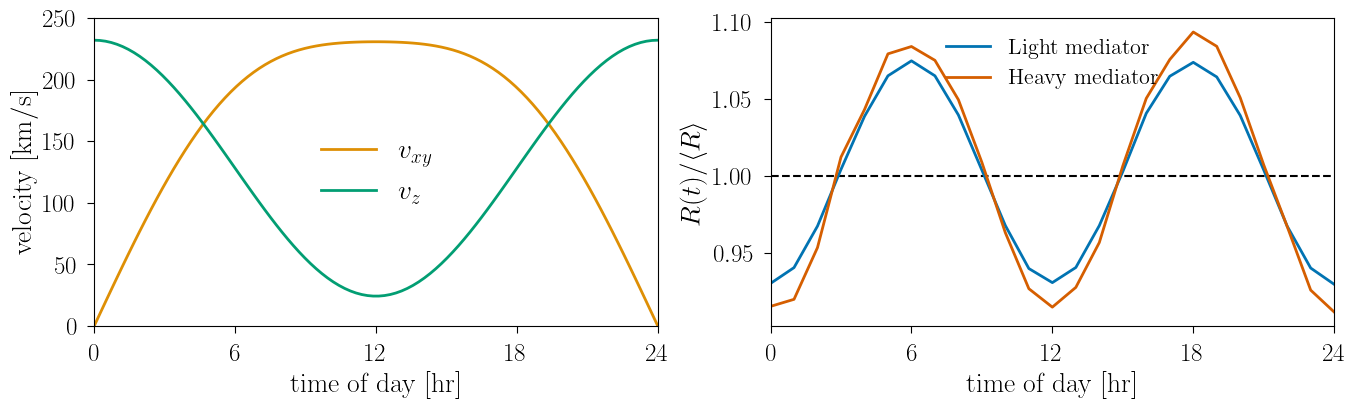

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE[0], style.FIG_DOUBLE_SIZE[1]/1.5)

for ax in (ax1, ax2):
    ax.set_xlim(0., 24.)
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xlabel('time of day [hr]')

ax = ax1

ax.plot(24*times, vxy*vels[0, 2]/s.kms, c=style.COLORS[1], label=r'$v_{xy}$', lw=2)
ax.plot(24*times, vels[:, 2]/s.kms, c=style.COLORS[2], label=r'$v_z$', lw=2)
ax.set_ylabel('velocity [$\SI{}{\kilo\meter/\second}$]')
ax.set_ylim(0, 250)
ax.legend(fontsize=20)

ax = ax2

ax.axhline(1.0, ls='--', c='k')
ax.plot(24*rate_times, rates_lm/np.mean(rates_lm), lw=2, label='Light mediator', c=style.COLORS[0])
ax.plot(24*rate_times, rates_hm/np.mean(rates_hm), lw=2, label='Heavy mediator', c=style.COLORS[3])
ax.set_ylabel(r'$R(t) / \langle R\rangle$')
ax.legend()
plt.show()

In [18]:
np.savez('day_demo_rates.npz',
         rates_hm=rates_hm, errs_hm=errs_hm,
         rates_lm=rates_lm, errs_lm=errs_lm,
         rate_times=rate_times)

In [19]:
fig.savefig('figures/diptych.pdf', bbox_inches='tight', transparent=True)

## Triptych version

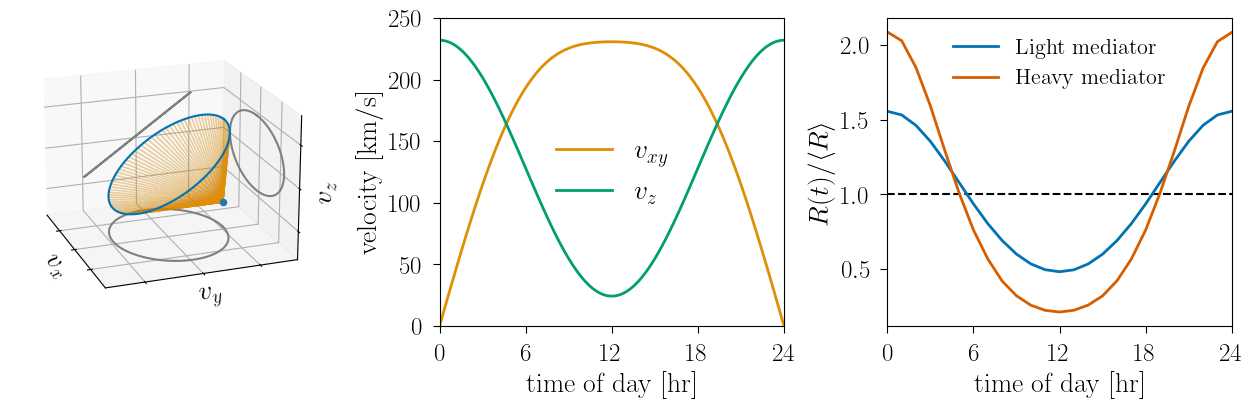

In [16]:
fig = plt.figure()
fig.set_size_inches(style.FIG_DOUBLE_SIZE[0], style.FIG_DOUBLE_SIZE[1]/1.5)

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax = ax1

ax.view_init(elev=20., azim=-20)
ax.set_xlim(-0.9, 0.9)
ax.set_ylim(-1.3, 0.3)
ax.set_zlim(-0.3, 1.3)
ax.plot(vhat[:, 0], vhat[:, 1], np.zeros_like(times)+ax.get_zlim()[0], c='gray', label=r'$\bb{\hat{v}}_x$')
ax.plot(vhat[:, 0], np.zeros_like(times)+ax.get_ylim()[1], vhat[:, 2], c='gray', label=r'$\bb{\hat{v}}_x$')
ax.plot(np.zeros_like(times)+ax.get_xlim()[0], vhat[:, 1], vhat[:, 2], c='gray', label=r'$\bb{\hat{v}}_x$')
n_spokes = 1000
for i in range(n_spokes):
    ax.plot3D(
        *np.vstack(([0, 0, 0], vels[int(i/n_spokes*len(times)), :]/vels[0, 2])).T,
        c=style.COLORS[1], ls='-', lw=1, label=r'$\bb{\hat{v}}_x$', alpha=0.05)
ax.scatter3D([0], [0], [0])
ax.plot3D(*vels.T/vels[0, 2], c=style.COLORS[0], label=r'$\bb{\hat{v}}_x$')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('$v_x$', labelpad=-10, fontsize=20)
ax.set_ylabel('$v_y$', labelpad=-10, fontsize=20)
ax.set_zlabel('$v_z$', labelpad=-10, fontsize=20)

ax2 = fig.add_subplot(1, 3, 2)
ax = ax2

ax.plot(24*times, vxy*vels[0, 2]/s.kms, c=style.COLORS[1], label=r'$v_{xy}$', lw=2)
ax.plot(24*times, vels[:, 2]/s.kms, c=style.COLORS[2], label=r'$v_z$', lw=2)
ax.set_ylabel('velocity [$\SI{}{\kilo\meter/\second}$]')
ax.set_ylim(0, 250)
ax.legend(fontsize=20)

ax3 = fig.add_subplot(1, 3, 3)
ax = ax3

ax.axhline(1.0, ls='--', c='k')
ax.plot(24*rate_times, rates_lm/np.mean(rates_lm), lw=2, label='Light mediator', c=style.COLORS[0])
ax.plot(24*rate_times, rates_hm/np.mean(rates_hm), lw=2, label='Heavy mediator', c=style.COLORS[3])
ax.set_ylabel(r'$R(t) / \langle R\rangle$')
ax.legend()

for ax in (ax2, ax3):
    ax.set_xlim(0., 24.)
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xlabel('time of day [hr]')
    
fig.subplots_adjust(wspace=0.3)

In [17]:
fig.savefig('figures/triptych.pdf', bbox_inches='tight', transparent=True)

# Anisotropic loss function

In [10]:
from aeg.rate import make_rate_integrand, mass_vector

In [11]:
Delta = 1
delta = 0.1
me = 1
kF = 1
EF = 1
hbar = np.sqrt(EF / (kF**2 / (2*me)))
vF = hbar * kF / me
e = np.sqrt(4*np.pi/137.)
second_eV = 1.519e15
kms_c = 3.34e-6
gram_eV = 5.61e32
me_eV = 511e3
theta_earth = np.radians(42)

def Q(mvec, qvec):
    return np.linalg.norm(qvec / np.sqrt(mvec))

def response(mvec, qvec, w, d=delta):
    p = Q(mvec, qvec)
    s = 1j*d
    return (
        1./(64.*p**3 * np.linalg.norm(qvec)**2)
        * 3 * (
            4*p*(-p**2 + s + w) - 4*p*(p**2 + s + w)
            + (d + 1j*((-2+p)*p-w)) * (d+1j*(p*(2+p)-w))
                * (np.log(-((-2+p)*p)+s+w) - np.log(-p*(2+p)+s+w))
            + (d - 1j*((-2+p)*p+w))*(d-1j*(p*(2+p)+w))
                * (np.log((-2+p)*p+s+w) - np.log(p*(2+p)+s+w))
        )
    )

def loss(mvec, qvec, w, **kwargs):
    vx = response(mvec, qvec, w, **kwargs)
    return -np.imag(vx) / np.abs(1 - vx)**2

def deposit(mX, v, q):
    return np.dot(q, v) - np.linalg.norm(q)**2 / (2*mX)

def scattering_fixed_v(mX, v, m, **kwargs):
    w_min = kwargs.get('w_min', 0)

    def _integrand(qx, qy, qz):
        q = np.asarray([qx, qy, qx])
        if np.linalg.norm(q) == 0:
            return 0
        w = deposit(mX, v, q)
        if np.imag(w) != 0:
            return 0
        if w < w_min:
            return 0
        return loss(m, q, w, **kwargs)

    return integrate.tplquad(
        _integrand,
        -4, 4, -4, 4, -4, 4,
        epsrel=1e-2
    )

In [12]:
qs = np.geomspace(0.1, 2., 200)
omegas = np.geomspace(0.1, 10, 200)
X, Y = np.meshgrid(qs, omegas)
Z_z = np.zeros_like(X)
Z_x = np.zeros_like(X)
for j, row in enumerate(Y):
    for i, col in enumerate(row):
        Z_x[i, j] = loss(
            mass_vector(REF_MASS_RATIO),
            X[i,j]*np.asarray([1, 0, 0]), Y[i, j]
        )
        Z_z[i, j] = loss(
            mass_vector(REF_MASS_RATIO),
            X[i,j]*np.asarray([0, 0, 1]), Y[i, j]
        )

In [23]:
s.s_earth + s.v_esc

1.867083194632312

/var/folders/pf/9lbz79vx1gn6tpskd5cbmthr0000gn/T/ipykernel_9405/4065275870.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.yaxis.set_ticklabels(['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1', '10']);


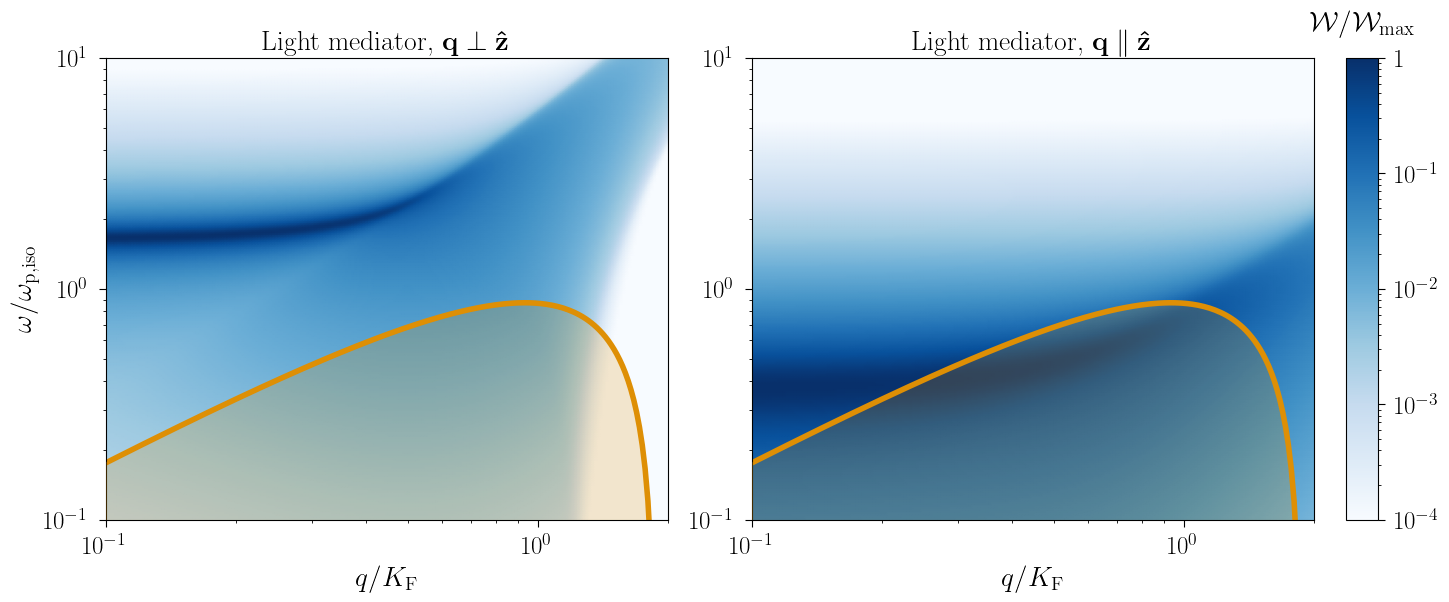

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)
fig.subplots_adjust(right=0.88, wspace=0.15)

s = Scaler(REF_EF)
vmax = s.s_earth + s.v_esc

for ax in (ax1, ax2):
    ax.loglog()
    ax.set_xlim(0.1, 2)
    ax.set_ylim(0.1, 10)
    ax.set_xlabel('$q/K_{\mathrm F}$')
    wmax = qs*vmax - qs**2/(2*0.5)
    ax.plot(qs, wmax, color=style.COLORS[1], lw=4)
    ax.fill_between(qs, wmax, [1e-2 for _ in qs], color=style.COLORS[1], alpha=0.2, zorder=99)

ax = ax1

vmin, vmax = 1e-4, 1e0
levels = np.geomspace(vmin, 1e0, 100)

#ax.contour(X, Y, Z_x/np.amax(Z_x), levels=[1e-4, 1e-3, 1e-2, 1e-1], colors='k', linewidths=0.2)
cs = ax.pcolormesh(X, Y, Z_x/np.amax(Z_x),
                 cmap='Blues', norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), shading='gouraud')
ax.set_ylabel('$\omega/\omega_{\mathrm{p,iso}}$')
ax.set_title(r"Light mediator, $\bb q\perp\bb{\hat z}$")

ax = ax2
#ax.contour(X, Y, Z_z/np.amax(Z_z), levels=[1e-4, 1e-3, 1e-2, 1e-1], colors='k', linewidths=0.2)
cs = ax.pcolormesh(X, Y, Z_z/np.amax(Z_z),
                 cmap='Blues', norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), shading='gouraud')
ax.set_title(r"Light mediator, $\bb q\parallel\bb{\hat z}$")
cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])
fig.colorbar(cs, cax=cbar_ax)
#cbar_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
cbar_ax.xaxis.set_label_position('top')
#cbar_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
cbar_ax.set_xlabel('$\mathcal W/\mathcal W_{\mathrm{max}}$', labelpad=20)
cbar_ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=12))
cbar_ax.yaxis.set_minor_locator(
    ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
        numticks=12
    )
)
cbar_ax.yaxis.set_ticklabels(['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1', '10']);

In [74]:
fig.savefig('figures/loss_function.png', bbox_inches='tight', transparent=True, dpi=500)

# Modulation traces for different DM masses

In [15]:
from aeg.rate import Scaler, rate, mass_vector, make_rate_integrand
from vegasflow import float_me

In [16]:
%%time
s = Scaler(REF_EF)
masses = [0.01, 0.1, 1, 10, 100]
times = np.linspace(0., 1., 25)
rates_mass_lm = np.zeros((len(masses), len(times)))
errs_mass_lm = np.zeros_like(rates_mass_lm)
rates_mass_hm = np.zeros((len(masses), len(times)))
errs_mass_hm = np.zeros_like(rates_mass_lm)
for j, mass in enumerate(masses):
    print(j+1, '/', len(masses), '\n')
    for i, time in enumerate(times):
        rates_mass_lm[j, i], errs_mass_lm[j, i] = rate(
            s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
            t=time, mX=mass, spherical=True
        )
        rates_mass_hm[j, i], errs_mass_hm[j, i] = rate(
            s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
            t=time, mX=mass, spherical=True,
            m_med=1000
        )

1 / 5 

2 / 5  sent to the computing device: 100.0 %

3 / 5  sent to the computing device: 100.0 %

4 / 5  sent to the computing device: 100.0 %

5 / 5  sent to the computing device: 100.0 %

CPU times: user 15h 26min 17s, sys: 5h 28min 31s, total: 20h 54min 49s
Wall time: 2h 49min 33s


In [18]:
np.savez('day_trace_dm_mass.npz',
         rates_mass_lm=rates_mass_lm, errs_mass_lm=errs_mass_lm,
         errs_mass_hm=errs_mass_hm, rates_mass_hm=rates_mass_hm,
         masses=masses, times=times)

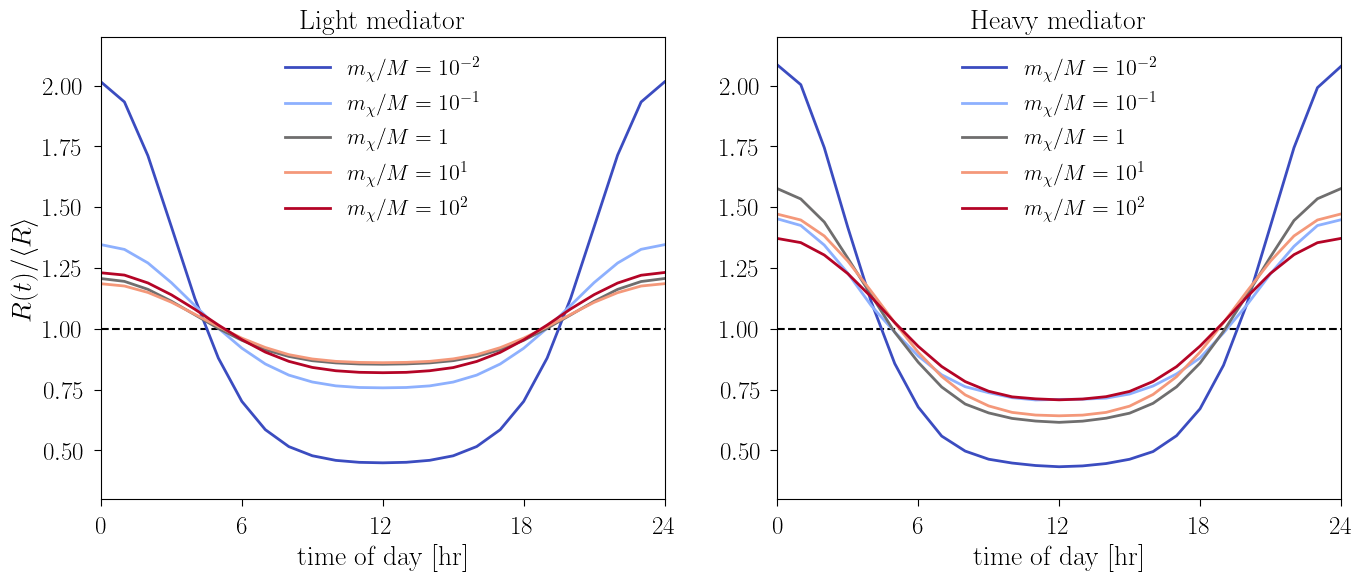

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)

for ax in axes:
    ax.set_xlim(0, 24)
    ax.set_xlabel(r'time of day [hr]')
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.axhline(1, ls='--', c='k')

ax = axes[0]
ax.set_ylabel(r'$R(t)/\langle R\rangle$')
ax.set_title('Light mediator')

cmap = cm.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, len(masses)))
colors[2, :-1] *= 0.5
for i, (mass, color) in enumerate(zip(masses, colors)):
    if mass == 1:
        label = r'$m_\chi/M=1$'
    else:
        label = r'$m_\chi/M=10^{%d}$' % (np.log10(mass))
    axes[0].plot(
        24*times, rates_mass_lm[i] / np.mean(rates_mass_lm[i]),
        label=label, color=color, lw=2
    )
    axes[1].plot(
        24*times, rates_mass_hm[i] / np.mean(rates_mass_hm[i]),
        label=label, color=color, lw=2
    )

ax = axes[1]
ax.set_title('Heavy mediator')

for ax in axes:
    ax.set_ylim(0.3, 2.2)
    ax.legend()

In [26]:
fig.savefig('figures/day_trace_dm_mass.pdf', bbox_inches='tight', transparent=True)

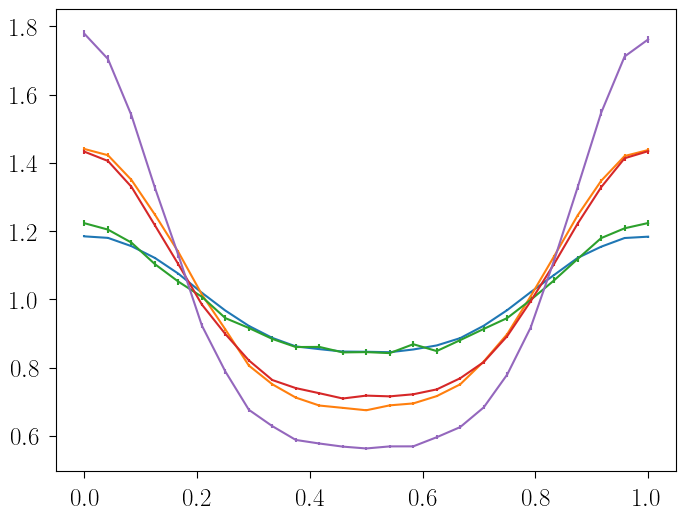

In [71]:
data = np.load('output/day_dm_mass_hm.npz')
for i in range(5):
    mask = np.isfinite(data['Z'][i, :, 0])
    plt.errorbar(
        data['X'][i][mask], data['Z'][i, :, 0][mask]/np.mean(data['Z'][i, :, 0][mask]),
        yerr=data['Z'][i, :, 1][mask]/np.mean(data['Z'][i, :, 0][mask])
    )

# Modulation traces for particle–hole only

In [3]:
from aeg.rate import Scaler, rate, mass_vector, make_rate_integrand
from vegasflow import float_me

In [4]:
v_ratios = [0.7, 7.0]
times = np.linspace(0., 1., 25)
rates_vr_lm_ph = np.zeros((len(v_ratios), len(times)))
rates_vr_hm_ph = np.zeros((len(v_ratios), len(times)))
rates_vr_lm = np.zeros((len(v_ratios), len(times)))
rates_vr_hm = np.zeros((len(v_ratios), len(times)))
errs_vr_lm_ph = np.zeros_like(rates_vr_lm_ph)
errs_vr_hm_ph = np.zeros_like(rates_vr_hm_ph)
errs_vr_lm = np.zeros_like(rates_vr_lm)
errs_vr_hm = np.zeros_like(rates_vr_hm)

In [6]:
%%time
mass = 1.
with pb.ProgressBar(max_value=len(v_ratios)*len(times)) as bar:
    count = 0
    for j, vr in enumerate(v_ratios):
        s = Scaler(v0_over_vF=vr)
        for i, time in enumerate(times):
            bar.update(count)
            rates_vr_lm_ph[j, i], errs_vr_lm_ph[j, i] = rate(
                s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
                t=time, mX=mass, spherical=True, ph_only=True
            )
            rates_vr_hm_ph[j, i], errs_vr_hm_ph[j, i] = rate(
                s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
                t=time, mX=mass, spherical=True, ph_only=True, m_med=1000
            )
            rates_vr_lm[j, i], errs_vr_lm[j, i] = rate(
                s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
                t=time, mX=mass, spherical=True
            )
            rates_vr_hm[j, i], errs_vr_hm[j, i] = rate(
                s, w_min=1e-2*s.eV, w_max=10*s.eV, m=mass_vector(REF_MASS_RATIO),
                t=time, mX=mass, spherical=True, m_med=1000
            )
            count += 1

  0% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  2% (1 of 50) |                         | Elapsed Time: 0:00:17 ETA:   0:13:59

  4% (2 of 50) |#                        | Elapsed Time: 0:00:33 ETA:   0:13:22

  6% (3 of 50) |#                        | Elapsed Time: 0:00:51 ETA:   0:13:28

  8% (4 of 50) |##                       | Elapsed Time: 0:01:08 ETA:   0:13:04

 10% (5 of 50) |##                       | Elapsed Time: 0:01:24 ETA:   0:12:37

 12% (6 of 50) |###                      | Elapsed Time: 0:01:42 ETA:   0:12:43

 14% (7 of 50) |###                      | Elapsed Time: 0:01:59 ETA:   0:12:20

 16% (8 of 50) |####                     | Elapsed Time: 0:02:16 ETA:   0:12:10

 18% (9 of 50) |####                     | Elapsed Time: 0:02:34 ETA:   0:11:54

 20% (10 of 50) |####                    | Elapsed Time: 0:02:51 ETA:   0:11:20

 22% (11 of 50) |#####                   | Elapsed Time: 0:03:08 ETA:   0:11:01

 24% (12 of 50) |#####                   | Elapsed Time: 0:03:25 ETA:   0:10:42

 26% (13 of 50) |######                  | Elapsed Time: 0:03:42 ETA:   0:10:45

 28% (14 of 50) |######                  | Elapsed Time: 0:04:00 ETA:   0:10:36

 30% (15 of 50) |#######                 | Elapsed Time: 0:04:17 ETA:   0:10:14

 32% (16 of 50) |#######                 | Elapsed Time: 0:04:34 ETA:   0:09:40

 34% (17 of 50) |########                | Elapsed Time: 0:04:52 ETA:   0:09:28

 36% (18 of 50) |########                | Elapsed Time: 0:05:09 ETA:   0:09:02

 38% (19 of 50) |#########               | Elapsed Time: 0:05:26 ETA:   0:08:52

 40% (20 of 50) |#########               | Elapsed Time: 0:05:43 ETA:   0:08:32

 42% (21 of 50) |##########              | Elapsed Time: 0:06:00 ETA:   0:08:14

 44% (22 of 50) |##########              | Elapsed Time: 0:06:17 ETA:   0:07:55

 46% (23 of 50) |###########             | Elapsed Time: 0:06:34 ETA:   0:07:38

 48% (24 of 50) |###########             | Elapsed Time: 0:06:51 ETA:   0:07:24

 50% (25 of 50) |############            | Elapsed Time: 0:07:08 ETA:   0:07:04

 52% (26 of 50) |############            | Elapsed Time: 0:07:25 ETA:   0:06:47

 54% (27 of 50) |############            | Elapsed Time: 0:07:42 ETA:   0:06:30

 56% (28 of 50) |#############           | Elapsed Time: 0:07:59 ETA:   0:06:13

 58% (29 of 50) |#############           | Elapsed Time: 0:08:16 ETA:   0:05:57

 60% (30 of 50) |##############          | Elapsed Time: 0:08:33 ETA:   0:05:47

 62% (31 of 50) |##############          | Elapsed Time: 0:08:50 ETA:   0:05:26

 64% (32 of 50) |###############         | Elapsed Time: 0:09:08 ETA:   0:05:08

 66% (33 of 50) |###############         | Elapsed Time: 0:09:25 ETA:   0:04:50

 68% (34 of 50) |################        | Elapsed Time: 0:09:42 ETA:   0:04:32

 70% (35 of 50) |################        | Elapsed Time: 0:09:59 ETA:   0:04:17

 72% (36 of 50) |#################       | Elapsed Time: 0:10:16 ETA:   0:03:58

 74% (37 of 50) |#################       | Elapsed Time: 0:10:33 ETA:   0:03:40

 76% (38 of 50) |##################      | Elapsed Time: 0:10:50 ETA:   0:03:25

 78% (39 of 50) |##################      | Elapsed Time: 0:11:07 ETA:   0:03:07

 80% (40 of 50) |###################     | Elapsed Time: 0:11:24 ETA:   0:02:50

 82% (41 of 50) |###################     | Elapsed Time: 0:11:42 ETA:   0:02:38

 84% (42 of 50) |####################    | Elapsed Time: 0:12:00 ETA:   0:02:26

 86% (43 of 50) |####################    | Elapsed Time: 0:12:19 ETA:   0:02:08

 88% (44 of 50) |#####################   | Elapsed Time: 0:12:36 ETA:   0:01:46

 90% (45 of 50) |#####################   | Elapsed Time: 0:12:54 ETA:   0:01:27

 92% (46 of 50) |######################  | Elapsed Time: 0:13:11 ETA:   0:01:09

 94% (47 of 50) |######################  | Elapsed Time: 0:13:29 ETA:   0:00:52

 96% (48 of 50) |####################### | Elapsed Time: 0:13:46 ETA:   0:00:34

 98% (49 of 50) |####################### | Elapsed Time: 0:14:03 ETA:   0:00:17

100% (50 of 50) |########################| Elapsed Time: 0:14:20 Time:  0:14:20


CPU times: user 1h 14min 26s, sys: 24min 53s, total: 1h 39min 19s
Wall time: 14min 20s


In [8]:
np.savez('day_trace_dm_vr_ph.npz',
         rates_vr_lm_ph=rates_vr_lm_ph, errs_vr_lm_ph=errs_vr_lm_ph,
         rates_vr_hm_ph=rates_vr_hm_ph, errs_vr_hm_ph=errs_vr_hm_ph,
         rates_vr_lm=rates_vr_lm, errs_vr_lm=errs_vr_lm,
         rates_vr_hm=rates_vr_hm, errs_vr_hm=errs_vr_hm,
         v_ratios=v_ratios, times=times)

In [11]:
data = np.load('day_trace_dm_mass_ph.npz')
rates_mass_hm = data['rates_mass_hm']

In [10]:
data = np.load('day_trace_dm_vr_ph.npz')
v_ratios = data['v_ratios']
times = data['times']
rates_vr_lm_ph = data['rates_vr_lm_ph']
rates_vr_hm_ph = data['rates_vr_hm_ph']
rates_vr_lm = data['rates_vr_lm']
rates_vr_hm = data['rates_vr_hm']
errs_vr_lm_ph = data['errs_vr_lm_ph']
errs_vr_hm_ph = data['errs_vr_hm_ph']
errs_vr_lm = data['errs_vr_lm']
errs_vr_hm = data['errs_vr_hm']

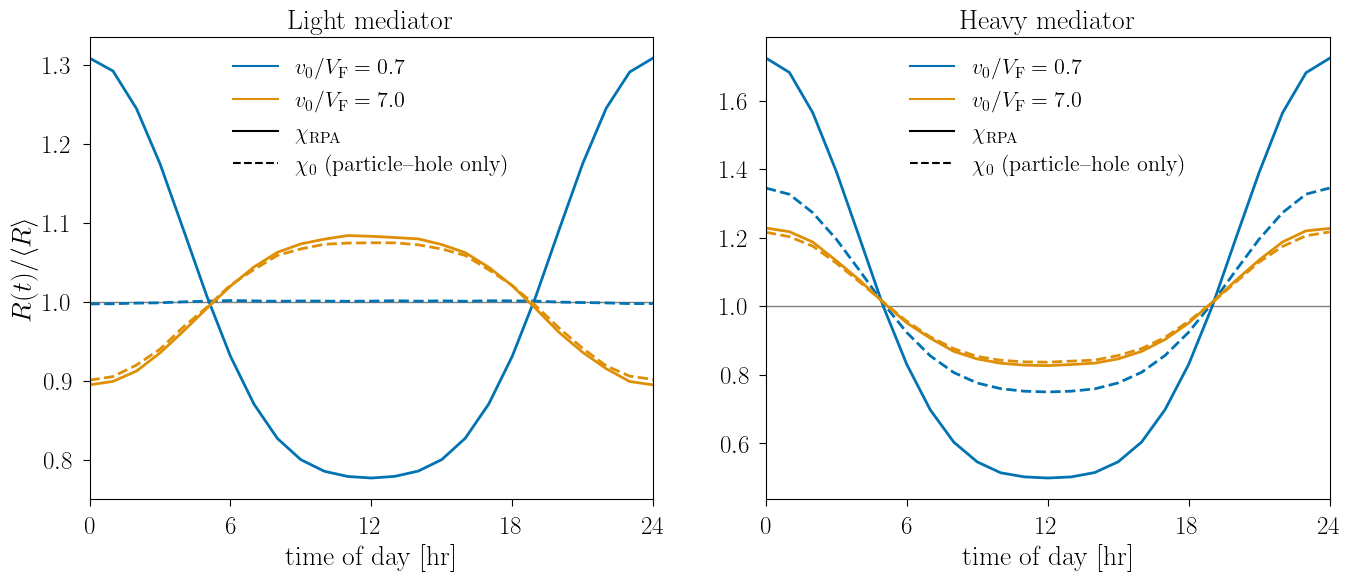

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)

for ax in axes:
    ax.set_xlim(0, 24)
    ax.set_xlabel(r'time of day [hr]')
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.axhline(1, ls='-', c='gray', lw=1)

ax = axes[0]
ax.set_ylabel(r'$R(t)/\langle R\rangle$')
ax.set_title('Light mediator')

for i, (vr, color) in enumerate(zip(v_ratios, style.COLORS)):
    label = r'$v_0/V_{\mathrm{F}} = %.1f$' % vr
    err = errs_vr_lm[i] / np.mean(rates_vr_lm[i])
    axes[0].plot(
        24*times, rates_vr_lm[i] / np.mean(rates_vr_lm[i]),
        label=label, color=color, lw=2
    )
    axes[0].plot(
        24*times, rates_vr_lm_ph[i] / np.mean(rates_vr_lm_ph[i]),
        color=color, lw=2, ls='--'
    )
    err = errs_vr_hm[i] / np.mean(rates_vr_hm[i])
    axes[1].plot(
        24*times, rates_vr_hm[i] / np.mean(rates_vr_hm[i]),
        label=label, color=color, lw=2
    )
    axes[1].plot(
        24*times, rates_vr_hm_ph[i] / np.mean(rates_vr_hm_ph[i]),
        color=color, lw=2, ls='--'
    )

ax = axes[1]
ax.set_title('Heavy mediator')

for ax in axes:
    handles = [
        mlines.Line2D([], [], color=style.COLORS[0], label='$v_0/V_{\mathrm{F}} = %.1f$' % v_ratios[0]),
        mlines.Line2D([], [], color=style.COLORS[1], label='$v_0/V_{\mathrm{F}} = %.1f$' % v_ratios[1]),
        mlines.Line2D([], [], color='k', label='$\chi_{\mathrm{RPA}}$'),
        mlines.Line2D([], [], color='k', ls='--', label='$\chi_0$ (particle--hole only)'),
    ]
    ax.legend(handles=handles, ncols=1)

In [15]:
fig.savefig('figures/day_trace_dm_mass_ph.pdf', bbox_inches='tight', transparent=True)

# Modulation traces for URu2Si2

In [3]:
from aeg.rate import Scaler, rate, mass_vector, make_rate_integrand
from vegasflow import float_me

In [4]:
s = Scaler(0.137593 / 0.1**2 * 2)
s.v_0

0.10013051040326172

In [5]:
mxyz = mass_vector(1.56)
mxyz

array([0.86223398, 0.86223398, 1.34508501])

In [6]:
masses = [0.01, 0.1, 1, 10, 100]

In [7]:
times = np.linspace(0., 1., 20)
rates_mass_lm = np.zeros((len(masses), len(times)))
errs_mass_lm = np.zeros_like(rates_mass_lm)
rates_mass_hm = np.zeros((len(masses), len(times)))
errs_mass_hm = np.zeros_like(rates_mass_lm)

In [9]:
%%time
with pb.ProgressBar(max_value=len(times)*len(masses)) as bar:
    k = 0
    for j, mass in enumerate(masses):
        for i, time in enumerate(times):
            k += 1
            bar.update(k)
            kwargs = dict(
                w_min=1e-2*s.eV, w_max=10*s.eV, m=mxyz,
                t=time, mX=mass, spherical=True
            )
            #rates_mass_lm[j, i], errs_mass_lm[j, i] = rate(s, **kwargs)
            rates_mass_hm[j, i], errs_mass_hm[j, i] = rate(s, m_med=1000, err_tol=1e-2, **kwargs)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--2022-12-06 19:58:54.170463: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  2% (2 of 100) |                        | Elapsed Time: 0:06:03 ETA:   4:56:44

  3% (3 of 100) |                        | Elapsed Time: 0:12:03 ETA:   9:42:50

  4% (4 of 100) |                        | Elapsed Time: 0:18:07 ETA:   9:41:45

  5% (5 of 100) |#                       | Elapsed Time: 0:24:03 ETA:   9:23:05

  6% (6 of 100) |#                       | Elapsed Time: 0:29:59 ETA:   9:18:55

  7% (7 of 100) |#                       | Elapsed Time: 0:35:55 ETA:   9:10:54

  8% (8 of 100) |#                       | Elapsed Time: 0:41:55 ETA:   9:11:41

  9% (9 of 100) |##                      | Elapsed Time: 0:47:55 ETA:   9:06:28

 10% (10 of 100) |##                     | Elapsed Time: 0:53:58 ETA:   9:05:20

 11% (11 of 100) |##                     | Elapsed Time: 1:00:11 ETA:   9:12:09

 12% (12 of 100) |##                     | Elapsed Time: 1:06:19 ETA:   8:59:39

 13% (13 of 100) |##                     | Elapsed Time: 1:12:23 ETA:   8:48:24

 14% (14 of 100) |###                    | Elapsed Time: 1:18:19 ETA:   8:29:49

 15% (15 of 100) |###                    | Elapsed Time: 1:24:15 ETA:   8:24:39

 16% (16 of 100) |###                    | Elapsed Time: 1:30:18 ETA:   8:27:40

 17% (17 of 100) |###                    | Elapsed Time: 1:36:21 ETA:   8:22:20

 18% (18 of 100) |####                   | Elapsed Time: 1:42:22 ETA:   8:13:42

 19% (19 of 100) |####                   | Elapsed Time: 1:48:23 ETA:   8:07:17

 20% (20 of 100) |####                   | Elapsed Time: 1:54:24 ETA:   8:01:10

 21% (21 of 100) |####                   | Elapsed Time: 2:00:22 ETA:   7:51:24

 22% (22 of 100) |#####                  | Elapsed Time: 2:00:36 ETA:   0:17:52

 23% (23 of 100) |#####                  | Elapsed Time: 2:00:50 ETA:   0:18:00

 24% (24 of 100) |#####                  | Elapsed Time: 2:01:03 ETA:   0:17:22

 25% (25 of 100) |#####                  | Elapsed Time: 2:01:17 ETA:   0:16:59

 26% (26 of 100) |#####                  | Elapsed Time: 2:01:30 ETA:   0:16:37

 27% (27 of 100) |######                 | Elapsed Time: 2:01:44 ETA:   0:16:54

 28% (28 of 100) |######                 | Elapsed Time: 2:01:58 ETA:   0:16:13

 29% (29 of 100) |######                 | Elapsed Time: 2:02:12 ETA:   0:16:11

 30% (30 of 100) |######                 | Elapsed Time: 2:02:25 ETA:   0:16:04

 31% (31 of 100) |#######                | Elapsed Time: 2:02:39 ETA:   0:15:53

 32% (32 of 100) |#######                | Elapsed Time: 2:02:53 ETA:   0:15:44

 33% (33 of 100) |#######                | Elapsed Time: 2:03:07 ETA:   0:15:02

 34% (34 of 100) |#######                | Elapsed Time: 2:03:21 ETA:   0:15:31

 35% (35 of 100) |########               | Elapsed Time: 2:03:34 ETA:   0:14:40

 36% (36 of 100) |########               | Elapsed Time: 2:03:48 ETA:   0:14:42

 37% (37 of 100) |########               | Elapsed Time: 2:04:02 ETA:   0:14:23

 38% (38 of 100) |########               | Elapsed Time: 2:04:15 ETA:   0:13:55

 39% (39 of 100) |########               | Elapsed Time: 2:04:29 ETA:   0:13:49

 40% (40 of 100) |#########              | Elapsed Time: 2:04:42 ETA:   0:13:34

 41% (41 of 100) |#########              | Elapsed Time: 2:04:56 ETA:   0:13:18

 42% (42 of 100) |#########              | Elapsed Time: 2:05:00 ETA:   0:04:22

 43% (43 of 100) |#########              | Elapsed Time: 2:05:05 ETA:   0:04:08

 44% (44 of 100) |##########             | Elapsed Time: 2:05:09 ETA:   0:04:07

 45% (45 of 100) |##########             | Elapsed Time: 2:05:14 ETA:   0:04:01

 46% (46 of 100) |##########             | Elapsed Time: 2:05:18 ETA:   0:04:04

 47% (47 of 100) |##########             | Elapsed Time: 2:05:22 ETA:   0:03:53

 48% (48 of 100) |###########            | Elapsed Time: 2:05:27 ETA:   0:03:50

 49% (49 of 100) |###########            | Elapsed Time: 2:05:31 ETA:   0:03:52

 50% (50 of 100) |###########            | Elapsed Time: 2:05:36 ETA:   0:03:39

 51% (51 of 100) |###########            | Elapsed Time: 2:05:40 ETA:   0:03:37

 52% (52 of 100) |###########            | Elapsed Time: 2:05:45 ETA:   0:03:47

 53% (53 of 100) |############           | Elapsed Time: 2:05:50 ETA:   0:03:36

 54% (54 of 100) |############           | Elapsed Time: 2:05:54 ETA:   0:03:20

 55% (55 of 100) |############           | Elapsed Time: 2:05:58 ETA:   0:03:21

 56% (56 of 100) |############           | Elapsed Time: 2:06:03 ETA:   0:03:20

 57% (57 of 100) |#############          | Elapsed Time: 2:06:07 ETA:   0:03:09

 58% (58 of 100) |#############          | Elapsed Time: 2:06:12 ETA:   0:03:04

 59% (59 of 100) |#############          | Elapsed Time: 2:06:16 ETA:   0:02:58

 60% (60 of 100) |#############          | Elapsed Time: 2:06:21 ETA:   0:03:01

 61% (61 of 100) |##############         | Elapsed Time: 2:06:25 ETA:   0:02:50

 62% (62 of 100) |##############         | Elapsed Time: 2:06:29 ETA:   0:02:43

 63% (63 of 100) |##############         | Elapsed Time: 2:06:34 ETA:   0:02:47

 64% (64 of 100) |##############         | Elapsed Time: 2:06:38 ETA:   0:02:35

 65% (65 of 100) |##############         | Elapsed Time: 2:06:43 ETA:   0:02:37

 66% (66 of 100) |###############        | Elapsed Time: 2:06:47 ETA:   0:02:30

 67% (67 of 100) |###############        | Elapsed Time: 2:06:52 ETA:   0:02:30

 68% (68 of 100) |###############        | Elapsed Time: 2:06:56 ETA:   0:02:20

 69% (69 of 100) |###############        | Elapsed Time: 2:07:00 ETA:   0:02:14

 70% (70 of 100) |################       | Elapsed Time: 2:07:05 ETA:   0:02:11

 71% (71 of 100) |################       | Elapsed Time: 2:07:09 ETA:   0:02:10

 72% (72 of 100) |################       | Elapsed Time: 2:07:14 ETA:   0:02:04

 73% (73 of 100) |################       | Elapsed Time: 2:07:18 ETA:   0:01:57

 74% (74 of 100) |#################      | Elapsed Time: 2:07:23 ETA:   0:01:56

 75% (75 of 100) |#################      | Elapsed Time: 2:07:27 ETA:   0:01:48

 76% (76 of 100) |#################      | Elapsed Time: 2:07:31 ETA:   0:01:45

 77% (77 of 100) |#################      | Elapsed Time: 2:07:36 ETA:   0:01:40

 78% (78 of 100) |#################      | Elapsed Time: 2:07:40 ETA:   0:01:38

 79% (79 of 100) |##################     | Elapsed Time: 2:07:45 ETA:   0:01:35

 80% (80 of 100) |##################     | Elapsed Time: 2:07:49 ETA:   0:01:26

 81% (81 of 100) |##################     | Elapsed Time: 2:07:53 ETA:   0:01:22

 82% (82 of 100) |##################     | Elapsed Time: 2:07:58 ETA:   0:01:20

 83% (83 of 100) |###################    | Elapsed Time: 2:08:02 ETA:   0:01:14

 84% (84 of 100) |###################    | Elapsed Time: 2:08:07 ETA:   0:01:10

 85% (85 of 100) |###################    | Elapsed Time: 2:08:11 ETA:   0:01:07

 86% (86 of 100) |###################    | Elapsed Time: 2:08:16 ETA:   0:01:00

 87% (87 of 100) |####################   | Elapsed Time: 2:08:20 ETA:   0:00:56

 88% (88 of 100) |####################   | Elapsed Time: 2:08:24 ETA:   0:00:52

 89% (89 of 100) |####################   | Elapsed Time: 2:08:29 ETA:   0:00:49

 90% (90 of 100) |####################   | Elapsed Time: 2:08:33 ETA:   0:00:43

 91% (91 of 100) |####################   | Elapsed Time: 2:08:38 ETA:   0:00:39

 92% (92 of 100) |#####################  | Elapsed Time: 2:08:42 ETA:   0:00:37

 93% (93 of 100) |#####################  | Elapsed Time: 2:08:47 ETA:   0:00:32

 94% (94 of 100) |#####################  | Elapsed Time: 2:08:51 ETA:   0:00:26

 95% (95 of 100) |#####################  | Elapsed Time: 2:08:56 ETA:   0:00:21

 96% (96 of 100) |###################### | Elapsed Time: 2:09:00 ETA:   0:00:18

 97% (97 of 100) |###################### | Elapsed Time: 2:09:05 ETA:   0:00:13

 98% (98 of 100) |###################### | Elapsed Time: 2:09:09 ETA:   0:00:08

 99% (99 of 100) |###################### | Elapsed Time: 2:09:13 ETA:   0:00:04

100% (100 of 100) |######################| Elapsed Time: 2:09:18 ETA:  00:00:00

100% (100 of 100) |######################| Elapsed Time: 2:09:22 Time:  2:09:22


CPU times: user 12h 5min, sys: 4h 10min 23s, total: 16h 15min 23s
Wall time: 2h 9min 22s


(array([20.,  4.,  6., 18., 12., 10.,  6., 12.,  2., 10.]),
 array([0.00103292, 0.00149463, 0.00195635, 0.00241806, 0.00287977,
        0.00334149, 0.0038032 , 0.00426491, 0.00472662, 0.00518834,
        0.00565005]),
 <BarContainer object of 10 artists>)

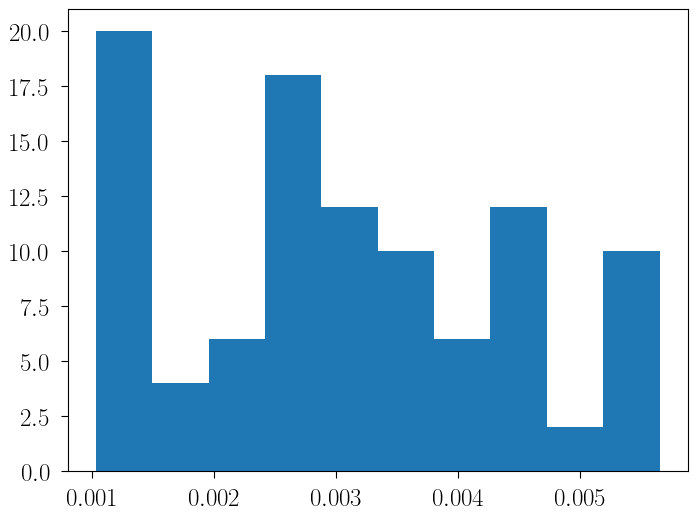

In [12]:
plt.hist((errs_mass_hm / rates_mass_hm).ravel())

In [13]:
temp_rates = rates_mass_hm
temp_errs = errs_mass_hm

In [14]:
np.savez('day_trace_urusi_hm.npz',
         rates_mass_hm=rates_mass_hm, errs_mass_hm=errs_mass_hm,
         masses=masses, times=times)

In [3]:
data = np.load('day_trace_urusi.npz')
rates_mass_lm = data['rates_mass_lm']
errs_mass_lm = data['errs_mass_lm']
times_lm = data['times']

In [4]:
data = np.load('day_trace_urusi.npz')
times_hm_b = data['times']
rates_mass_hm_b = data['rates_mass_hm']
data = np.load('day_trace_urusi_joh.npz')
rates_mass_hm_2 = data['rates_mass_hm']
times_hm = data['times']
masses = data['masses']
data = np.load('output/urusi_hm.npz')
rates_mass_hm_3 = data['Z'][::-1, :, 0]
data = np.load('output/urusi_hm_2.npz')
rates_mass_hm_4 = data['Z'][::-1, :, 0]

In [5]:
rates_mass_hm_1 = np.zeros_like(rates_mass_hm_2)
for i in range(len(rates_mass_hm_1)):
    ifunc = interpolate.interp1d(times_hm_b, rates_mass_hm_b)
    rates_mass_hm_1 = ifunc(times_hm)

In [6]:
rates_mass_hm_mean = np.mean(np.stack((
    rates_mass_hm_1 / np.mean(rates_mass_hm_1, axis=1)[:, None],
    rates_mass_hm_2 / np.mean(rates_mass_hm_2, axis=1)[:, None],
    rates_mass_hm_3 / np.mean(rates_mass_hm_3, axis=1)[:, None],
    rates_mass_hm_4 / np.mean(rates_mass_hm_4, axis=1)[:, None]
)), axis=0)

In [38]:
np.savez('day_trace_urusi.npz',
         rates_mass_lm=rates_mass_lm, errs_mass_lm=errs_mass_lm,
         rates_mass_hm=rates_mass_hm, errs_mass_hm=errs_mass_hm,
         masses=masses, times=times)

In [16]:
np.amax(errs_mass_hm / rates_mass_hm)

0.005650049672406815

In [17]:
np.amax(errs_mass_lm / rates_mass_lm)

0.00037927371815081243

In [23]:
data = np.load('output/urusi_hm.npz')

In [25]:
list(data.keys())

['X', 'Y', 'Z', 'n_points', 'success']

In [42]:
data['Y'][:, 0]

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02])

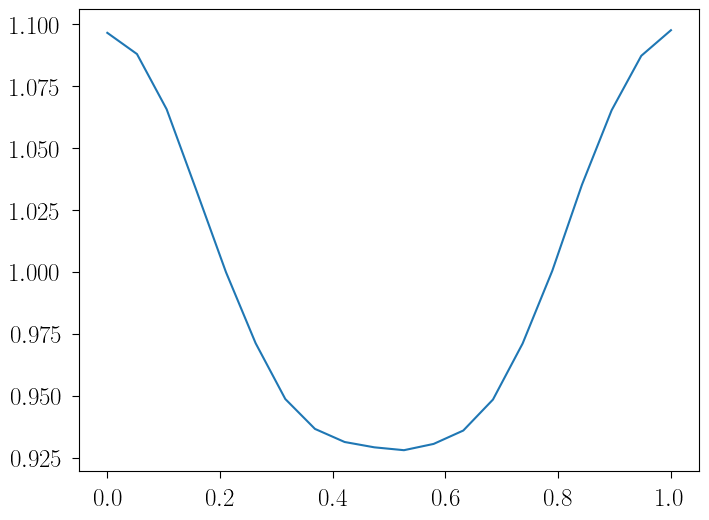

In [35]:
plt.plot(data['X'][1], data['Z'][1, :, 0] / np.mean(data['Z'][1, :, 0]))

0.01
0.1
1.0
10.0
100.0


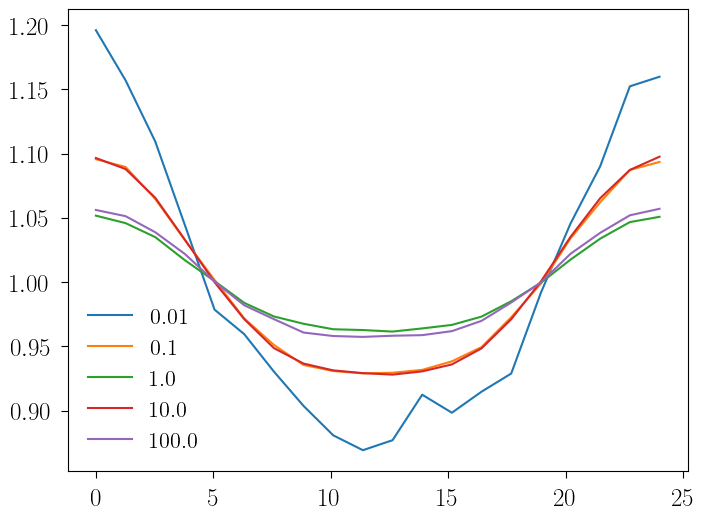

In [57]:
for i in range(5):
    print(data['Y'][:, 0][-(i+1)])
    plt.plot(24*data['X'][-(i+1)], data['Z'][-(i+1), :, 0] / np.mean(data['Z'][-(i+1), :, 0]), label=data['Y'][:, 0][-(i+1)])
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


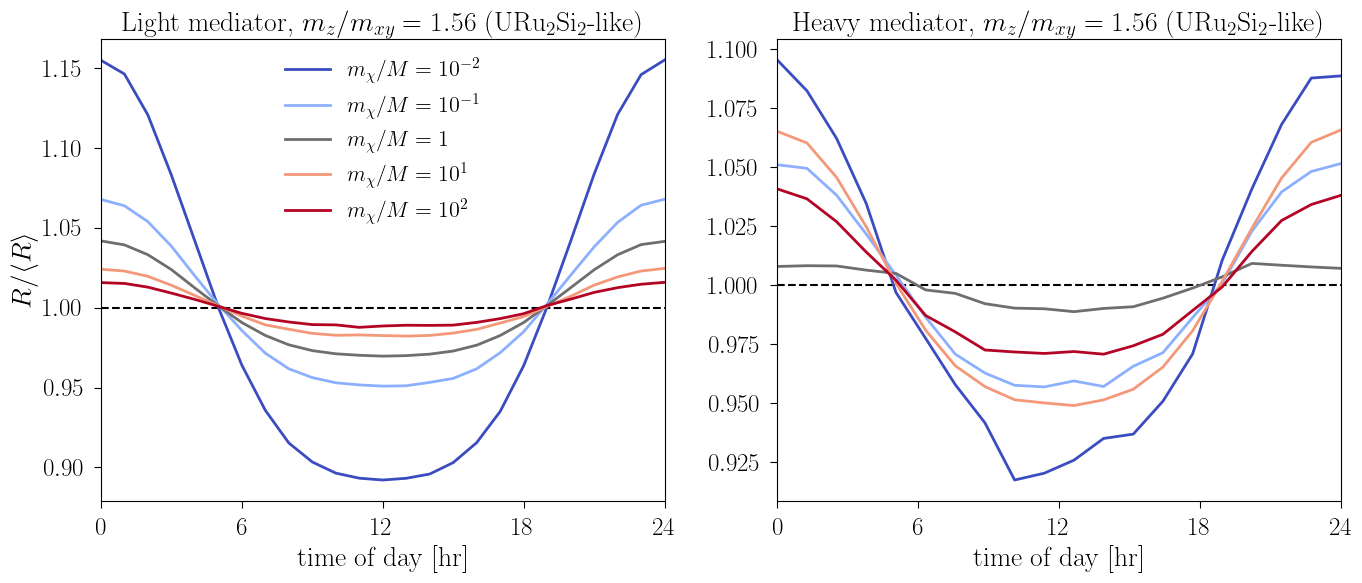

In [8]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)

for ax in axes:
    ax.set_xlim(0, 24)
    ax.set_xlabel(r'time of day [hr]')
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.axhline(1, ls='--', c='k')

ax = axes[0]
ax.set_ylabel(r'$R/\langle R\rangle$')
ax.set_title('Light mediator, $m_z/m_{xy} = 1.56$ ($\mathrm{URu}_2\mathrm{Si}_2$-like)')

cmap = cm.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, len(masses)))
colors[2, :-1] *= 0.5
for i, (mass, color) in enumerate(zip(masses, colors)):
    if mass == 1:
        label = r'$m_\chi/M=1$'
    else:
        label = r'$m_\chi/M=10^{%d}$' % (np.log10(mass))
    axes[0].plot(
        24*times_lm, rates_mass_lm[i] / np.mean(rates_mass_lm[i]),
        label=label, color=color, lw=2
    )
    """
    axes[1].errorbar(
        24*times, rates_mass_hm[i] / np.mean(rates_mass_hm[i]),
        yerr=errs_mass_hm[i] / np.mean(rates_mass_hm[i]),
        label=label, color=color, lw=2
    )
    """
    #axes[1].plot(24*data['X'][-i-1], data['Z'][-i-1, :, 0] / np.mean(data['Z'][-i-1, :, 0]), color=color)
    axes[1].plot(24*times_hm, rates_mass_hm_mean[i],
                 color=color, lw=2)

ax = axes[1]
ax.set_title('Heavy mediator, $m_z/m_{xy} = 1.56$ ($\mathrm{URu}_2\mathrm{Si}_2$-like)')

for ax in axes:
    ax.legend()

In [9]:
fig.savefig('figures/day_trace_urusi.pdf', bbox_inches='tight', transparent=True)

# Kinematics

In [75]:
from aeg.rate import hbar
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [76]:
qs = np.geomspace(0.001, 100, 300)
omegas = np.geomspace(0.001, 1000, 300)
X, Y = np.meshgrid(qs, omegas)
Z_z = np.zeros_like(X)
Z_x = np.zeros_like(X)
mass_ratio = 20
for j, row in enumerate(Y):
    for i, col in enumerate(row):
        Z_x[i, j] = loss(
            mass_vector(mass_ratio),
            X[i,j]*np.asarray([1, 0, 0]), Y[i, j]
        )
        Z_z[i, j] = loss(
            mass_vector(mass_ratio),
            X[i,j]*np.asarray([0, 0, 1]), Y[i, j]
        )

In [77]:
def wpi(wp0, q):
    return wp0*(1 + hbar**2 * 3/5/wp0**2 * q**2 + hbar**4 * (
        hbar/(8*me**2 * wp0**2) - 3/280/wp0**4) * q**4)

def wp(m, wp0, q):
    nq = np.linalg.norm(q, axis=-1)
    return wpi(wp0, nq) * np.linalg.norm(np.asarray(q)*np.sqrt(1./m), axis=-1) / nq

''

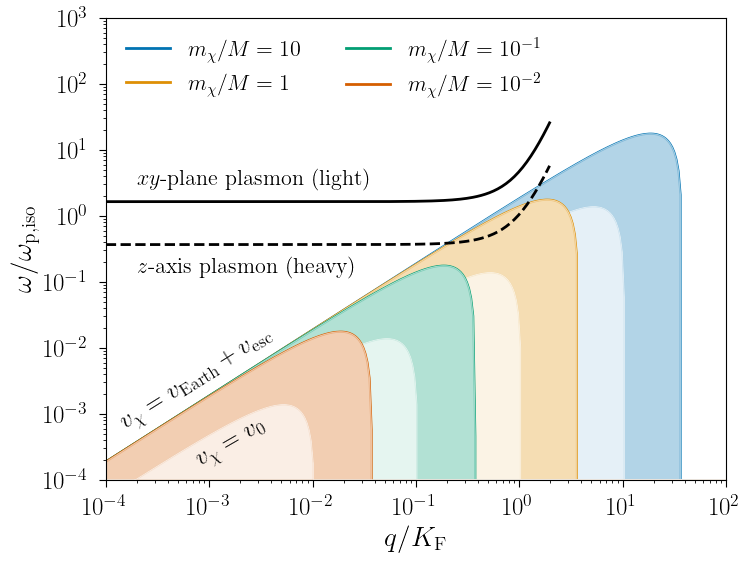

In [102]:
fig, ax = plt.subplots()
fig.set_size_inches(style.FIG_SINGLE_SIZE)

qs = np.geomspace(0.0001, 100, 300)
#s = Scaler(0.137593 / 2.)
s = Scaler(REF_EF)
speeds = np.array([s.v_0, s.s_earth + s.v_esc])
ax.loglog()
ax.set_xlim(0.0001, 100)
ax.set_ylim(0.0001, 1000)
ax.set_xlabel('$q/K_{\mathrm F}$')
for mX, color in zip([1e-2, 1e-1, 1e0, 1e1][::-1], style.COLORS):
    wmaxes = []
    for i, (v, ls) in enumerate(zip(speeds, ['-', '--', ':'])):
        wmax = qs*v - qs**2/(2*mX)
        wmaxes.append(wmax)
        if i == 0:
            if mX in (1, 10):
                label = '$m_\chi/M=%d$' % mX
            else:
                label = '$m_\chi/M=10^{%d}$' % np.log10(mX)
        else:
            label = None
        ax.plot(qs, wmax, color=color, zorder=1, lw=2, label=label)
    ax.fill_between(qs, wmaxes[0], wmaxes[-1], color='w')
    ax.fill_between(qs, wmaxes[0], wmaxes[-1], color=color, alpha=0.3)
    ax.fill_between(qs, wmaxes[0], [1e-4]*len(qs), color='w', alpha=1)
    ax.fill_between(qs, wmaxes[0], [1e-4]*len(qs), color=color, alpha=0.1)

qs = qs[qs < 2]
ax.plot(qs, wp(mass_vector(REF_MASS_RATIO), 1., qs[:, None] * np.array([1, 0, 0])), c='k', lw=2, ls='-')
ax.plot(qs, wp(mass_vector(REF_MASS_RATIO), 1., qs[:, None] * np.array([0, 0, 1])), c='k', lw=2, ls='--')
ax.set_ylabel('$\omega/\omega_{\mathrm{p,iso}}$')

color_legend = ax.legend(ncols=2, loc=2)

#handles = [
#    mlines.Line2D([], [], color='k', label='$xy$-plane plasmon (light)'),
#    mlines.Line2D([], [], color='k', ls='--', label='$z$-axis plasmon (heavy)'),
#]
#ax.legend(handles=handles, bbox_to_anchor=[0.543, 0.55])
#ax.add_artist(color_legend)

ax.text(2e-4, 3e+0, '$xy$-plane plasmon (light)', fontsize=16)
ax.text(2e-4, 1.4e-1, '$z$-axis plasmon (heavy)', fontsize=16)

ax.text(1.3e-4, 6e-4, '$v_\chi = v_{\mathrm{Earth}} + v_{\mathrm{esc}}$', rotation=32, fontsize=18)
ax.text(7e-4, 1.7e-4, '$v_\chi = v_0$', rotation=30, fontsize=18)
;

In [103]:
fig.savefig('figures/kinematics.pdf', bbox_inches='tight', transparent=True)

# Modulation by $V_F$ and mass ratio

### Compute directly

In [3]:
from aeg.rate import delta_r, mass_vector, Scaler

In [4]:
v_ratios = np.geomspace(0.08, 10, 20)
m_ratios = np.geomspace(1, 1e2, 20)
X, Y = np.meshgrid(v_ratios, m_ratios)
Z_lm = np.zeros((X.shape[0], X.shape[1], 2))
Z_hm = np.zeros_like(Z_lm)

In [5]:
%%time
with pb.ProgressBar(max_value=X.size*2) as bar:
    count = 0
    for i, row in enumerate(Y):
        for j, _ in enumerate(row):
            bar.update(count)
            s = Scaler(v0_over_vF=X[i, j])
            Z_lm[i, j] = delta_r(s, m=mass_vector(Y[i, j]), w_min=1e-2*s.eV, w_max=10*s.eV)
            count += 1
            bar.update(count)
            Z_hm[i, j] = delta_r(s, m=mass_vector(Y[i, j]), w_min=1e-2*s.eV, w_max=10*s.eV, m_med=1000)
            count += 1
            bar.update(count)

  0% (0 of 800) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--2022-12-08 08:40:59.648297: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  0% (1 of 800) |                        | Elapsed Time: 0:00:12 ETA:   2:45:01

  0% (2 of 800) |                        | Elapsed Time: 0:00:22 ETA:   2:14:01

  0% (3 of 800) |                        | Elapsed Time: 0:00:32 ETA:   2:13:42

  0% (4 of 800) |                        | Elapsed Time: 0:00:42 ETA:   2:15:14

  0% (5 of 800) |                        | Elapsed Time: 0:00:52 ETA:   2:14:38

  0% (6 of 800) |                        | Elapsed Time: 0:01:02 ETA:   2:11:53

  0% (7 of 800) |                        | Elapsed Time: 0:01:13 ETA:   2:18:26

  1% (8 of 800) |                        | Elapsed Time: 0:01:23 ETA:   2:17:26

  1% (9 of 800) |                        | Elapsed Time: 0:01:34 ETA:   2:17:11

  1% (10 of 800) |                       | Elapsed Time: 0:01:44 ETA:   2:15:10

  1% (11 of 800) |                       | Elapsed Time: 0:01:54 ETA:   2:15:26

  1% (12 of 800) |                       | Elapsed Time: 0:02:05 ETA:   2:15:17

  1% (13 of 800) |                       | Elapsed Time: 0:02:15 ETA:   2:17:57

  1% (14 of 800) |                       | Elapsed Time: 0:02:25 ETA:   2:16:12

  1% (15 of 800) |                       | Elapsed Time: 0:02:36 ETA:   2:15:19

  2% (16 of 800) |                       | Elapsed Time: 0:02:46 ETA:   2:14:57

  2% (17 of 800) |                       | Elapsed Time: 0:02:56 ETA:   2:13:00

  2% (18 of 800) |                       | Elapsed Time: 0:03:07 ETA:   2:14:02

  2% (19 of 800) |                       | Elapsed Time: 0:03:17 ETA:   2:16:07

  2% (20 of 800) |                       | Elapsed Time: 0:03:27 ETA:   2:14:19

  2% (21 of 800) |                       | Elapsed Time: 0:03:38 ETA:   2:13:29

  2% (22 of 800) |                       | Elapsed Time: 0:03:48 ETA:   2:12:55

  2% (23 of 800) |                       | Elapsed Time: 0:03:58 ETA:   2:14:16

  3% (24 of 800) |                       | Elapsed Time: 0:04:09 ETA:   2:12:58

  3% (25 of 800) |                       | Elapsed Time: 0:04:19 ETA:   2:11:02

  3% (26 of 800) |                       | Elapsed Time: 0:04:29 ETA:   2:11:30

  3% (27 of 800) |                       | Elapsed Time: 0:04:39 ETA:   2:10:36

  3% (28 of 800) |                       | Elapsed Time: 0:04:49 ETA:   2:09:10

  3% (29 of 800) |                       | Elapsed Time: 0:05:00 ETA:   2:17:40

  3% (30 of 800) |                       | Elapsed Time: 0:05:11 ETA:   2:19:09

  3% (31 of 800) |                       | Elapsed Time: 0:05:21 ETA:   2:11:38

  4% (32 of 800) |                       | Elapsed Time: 0:05:31 ETA:   2:12:37

  4% (33 of 800) |                       | Elapsed Time: 0:05:42 ETA:   2:11:11

  4% (34 of 800) |                       | Elapsed Time: 0:05:52 ETA:   2:15:21

  4% (35 of 800) |#                      | Elapsed Time: 0:06:03 ETA:   2:14:38

  4% (36 of 800) |#                      | Elapsed Time: 0:06:13 ETA:   2:15:55

  4% (37 of 800) |#                      | Elapsed Time: 0:06:24 ETA:   2:13:47

  4% (38 of 800) |#                      | Elapsed Time: 0:06:34 ETA:   2:11:51

  4% (39 of 800) |#                      | Elapsed Time: 0:06:45 ETA:   2:10:35

  5% (40 of 800) |#                      | Elapsed Time: 0:06:55 ETA:   2:10:27

  5% (41 of 800) |#                      | Elapsed Time: 0:07:06 ETA:   2:16:10

  5% (42 of 800) |#                      | Elapsed Time: 0:07:16 ETA:   2:15:41

  5% (43 of 800) |#                      | Elapsed Time: 0:07:27 ETA:   2:16:59

  5% (44 of 800) |#                      | Elapsed Time: 0:07:38 ETA:   2:16:37

  5% (45 of 800) |#                      | Elapsed Time: 0:07:49 ETA:   2:15:00

  5% (46 of 800) |#                      | Elapsed Time: 0:07:59 ETA:   2:13:48

  5% (47 of 800) |#                      | Elapsed Time: 0:08:10 ETA:   2:17:06

  6% (48 of 800) |#                      | Elapsed Time: 0:08:21 ETA:   2:15:42

  6% (49 of 800) |#                      | Elapsed Time: 0:08:32 ETA:   2:15:17

  6% (50 of 800) |#                      | Elapsed Time: 0:08:43 ETA:   2:15:48

  6% (51 of 800) |#                      | Elapsed Time: 0:08:53 ETA:   2:11:43

  6% (52 of 800) |#                      | Elapsed Time: 0:09:04 ETA:   2:14:05

  6% (53 of 800) |#                      | Elapsed Time: 0:09:15 ETA:   2:11:03

  6% (54 of 800) |#                      | Elapsed Time: 0:09:26 ETA:   2:16:19

  6% (55 of 800) |#                      | Elapsed Time: 0:09:36 ETA:   2:12:47

  7% (56 of 800) |#                      | Elapsed Time: 0:09:47 ETA:   2:12:35

  7% (57 of 800) |#                      | Elapsed Time: 0:09:58 ETA:   2:09:24

  7% (58 of 800) |#                      | Elapsed Time: 0:10:08 ETA:   2:13:33

  7% (59 of 800) |#                      | Elapsed Time: 0:10:19 ETA:   2:10:47

  7% (60 of 800) |#                      | Elapsed Time: 0:10:30 ETA:   2:10:57

  7% (61 of 800) |#                      | Elapsed Time: 0:10:40 ETA:   2:09:46

  7% (62 of 800) |#                      | Elapsed Time: 0:10:51 ETA:   2:09:12

  7% (63 of 800) |#                      | Elapsed Time: 0:11:01 ETA:   2:12:37

  8% (64 of 800) |#                      | Elapsed Time: 0:11:12 ETA:   2:10:07

  8% (65 of 800) |#                      | Elapsed Time: 0:11:23 ETA:   2:10:53

  8% (66 of 800) |#                      | Elapsed Time: 0:11:33 ETA:   2:11:25

  8% (67 of 800) |#                      | Elapsed Time: 0:11:44 ETA:   2:14:39

  8% (68 of 800) |#                      | Elapsed Time: 0:11:55 ETA:   2:10:34

  8% (69 of 800) |#                      | Elapsed Time: 0:12:06 ETA:   2:09:01

  8% (70 of 800) |##                     | Elapsed Time: 0:12:17 ETA:   2:13:45

  8% (71 of 800) |##                     | Elapsed Time: 0:12:28 ETA:   2:15:11

  9% (72 of 800) |##                     | Elapsed Time: 0:12:38 ETA:   2:09:30

  9% (73 of 800) |##                     | Elapsed Time: 0:12:49 ETA:   2:09:06

  9% (74 of 800) |##                     | Elapsed Time: 0:13:00 ETA:   2:07:21

  9% (75 of 800) |##                     | Elapsed Time: 0:13:10 ETA:   2:06:56

  9% (76 of 800) |##                     | Elapsed Time: 0:13:21 ETA:   2:08:47

  9% (77 of 800) |##                     | Elapsed Time: 0:13:32 ETA:   2:10:15

  9% (78 of 800) |##                     | Elapsed Time: 0:13:42 ETA:   2:09:00

  9% (79 of 800) |##                     | Elapsed Time: 0:13:53 ETA:   2:04:44

 10% (80 of 800) |##                     | Elapsed Time: 0:14:03 ETA:   2:05:36

 10% (81 of 800) |##                     | Elapsed Time: 0:14:14 ETA:   2:11:50

 10% (82 of 800) |##                     | Elapsed Time: 0:14:25 ETA:   2:08:58

 10% (83 of 800) |##                     | Elapsed Time: 0:14:36 ETA:   2:07:17

 10% (84 of 800) |##                     | Elapsed Time: 0:14:46 ETA:   2:08:09

 10% (85 of 800) |##                     | Elapsed Time: 0:14:57 ETA:   2:05:17

 10% (86 of 800) |##                     | Elapsed Time: 0:15:08 ETA:   2:11:39

 10% (87 of 800) |##                     | Elapsed Time: 0:15:19 ETA:   2:10:33

 11% (88 of 800) |##                     | Elapsed Time: 0:15:30 ETA:   2:07:30

 11% (89 of 800) |##                     | Elapsed Time: 0:15:41 ETA:   2:08:30

 11% (90 of 800) |##                     | Elapsed Time: 0:15:51 ETA:   2:07:20

 11% (91 of 800) |##                     | Elapsed Time: 0:16:02 ETA:   2:06:03

 11% (92 of 800) |##                     | Elapsed Time: 0:16:13 ETA:   2:05:42

 11% (93 of 800) |##                     | Elapsed Time: 0:16:24 ETA:   2:11:27

 11% (94 of 800) |##                     | Elapsed Time: 0:16:34 ETA:   2:04:50

 11% (95 of 800) |##                     | Elapsed Time: 0:16:45 ETA:   2:04:21

 12% (96 of 800) |##                     | Elapsed Time: 0:16:56 ETA:   2:03:40

 12% (97 of 800) |##                     | Elapsed Time: 0:17:06 ETA:   2:05:44

 12% (98 of 800) |##                     | Elapsed Time: 0:17:17 ETA:   2:03:50

 12% (99 of 800) |##                     | Elapsed Time: 0:17:28 ETA:   2:05:49

 12% (100 of 800) |##                    | Elapsed Time: 0:17:38 ETA:   2:03:51

 12% (101 of 800) |##                    | Elapsed Time: 0:17:49 ETA:   2:02:58

 12% (102 of 800) |##                    | Elapsed Time: 0:18:00 ETA:   2:07:02

 12% (103 of 800) |##                    | Elapsed Time: 0:18:10 ETA:   2:02:46

 13% (104 of 800) |##                    | Elapsed Time: 0:18:21 ETA:   2:03:12

 13% (105 of 800) |##                    | Elapsed Time: 0:18:31 ETA:   2:02:39

 13% (106 of 800) |##                    | Elapsed Time: 0:18:42 ETA:   2:03:38

 13% (107 of 800) |##                    | Elapsed Time: 0:18:53 ETA:   2:01:42

 13% (108 of 800) |##                    | Elapsed Time: 0:19:03 ETA:   2:04:13

 13% (109 of 800) |##                    | Elapsed Time: 0:19:14 ETA:   2:02:55

 13% (110 of 800) |###                   | Elapsed Time: 0:19:25 ETA:   2:03:48

 13% (111 of 800) |###                   | Elapsed Time: 0:19:36 ETA:   2:02:43

 14% (112 of 800) |###                   | Elapsed Time: 0:19:46 ETA:   2:01:15

 14% (113 of 800) |###                   | Elapsed Time: 0:19:57 ETA:   2:00:42

 14% (114 of 800) |###                   | Elapsed Time: 0:20:07 ETA:   1:59:47

 14% (115 of 800) |###                   | Elapsed Time: 0:20:18 ETA:   2:02:24

 14% (116 of 800) |###                   | Elapsed Time: 0:20:29 ETA:   2:06:15

 14% (117 of 800) |###                   | Elapsed Time: 0:20:40 ETA:   2:00:53

 14% (118 of 800) |###                   | Elapsed Time: 0:20:50 ETA:   2:01:45

 14% (119 of 800) |###                   | Elapsed Time: 0:21:01 ETA:   2:02:15

 15% (120 of 800) |###                   | Elapsed Time: 0:21:12 ETA:   2:01:53

 15% (121 of 800) |###                   | Elapsed Time: 0:21:23 ETA:   2:08:37

 15% (122 of 800) |###                   | Elapsed Time: 0:21:35 ETA:   2:07:41

 15% (123 of 800) |###                   | Elapsed Time: 0:21:45 ETA:   2:01:28

 15% (124 of 800) |###                   | Elapsed Time: 0:21:56 ETA:   2:01:28

 15% (125 of 800) |###                   | Elapsed Time: 0:22:07 ETA:   2:08:05

 15% (126 of 800) |###                   | Elapsed Time: 0:22:18 ETA:   2:01:34

 15% (127 of 800) |###                   | Elapsed Time: 0:22:29 ETA:   1:59:51

 16% (128 of 800) |###                   | Elapsed Time: 0:22:40 ETA:   2:01:13

 16% (129 of 800) |###                   | Elapsed Time: 0:22:50 ETA:   1:57:24

 16% (130 of 800) |###                   | Elapsed Time: 0:23:01 ETA:   2:00:13

 16% (131 of 800) |###                   | Elapsed Time: 0:23:12 ETA:   1:57:51

 16% (132 of 800) |###                   | Elapsed Time: 0:23:22 ETA:   1:59:08

 16% (133 of 800) |###                   | Elapsed Time: 0:23:33 ETA:   1:59:48

 16% (134 of 800) |###                   | Elapsed Time: 0:23:44 ETA:   1:56:31

 16% (135 of 800) |###                   | Elapsed Time: 0:23:54 ETA:   1:56:38

 17% (136 of 800) |###                   | Elapsed Time: 0:24:05 ETA:   1:57:35

 17% (137 of 800) |###                   | Elapsed Time: 0:24:15 ETA:   1:56:59

 17% (138 of 800) |###                   | Elapsed Time: 0:24:26 ETA:   1:56:17

 17% (139 of 800) |###                   | Elapsed Time: 0:24:37 ETA:   1:59:10

 17% (140 of 800) |###                   | Elapsed Time: 0:24:47 ETA:   1:58:18

 17% (141 of 800) |###                   | Elapsed Time: 0:24:59 ETA:   2:05:25

 17% (142 of 800) |###                   | Elapsed Time: 0:25:10 ETA:   1:56:59

 17% (143 of 800) |###                   | Elapsed Time: 0:25:20 ETA:   1:55:30

 18% (144 of 800) |###                   | Elapsed Time: 0:25:31 ETA:   2:01:39

 18% (145 of 800) |###                   | Elapsed Time: 0:25:42 ETA:   1:55:51

 18% (146 of 800) |####                  | Elapsed Time: 0:25:53 ETA:   1:59:31

 18% (147 of 800) |####                  | Elapsed Time: 0:26:04 ETA:   2:03:29

 18% (148 of 800) |####                  | Elapsed Time: 0:26:15 ETA:   1:56:24

 18% (149 of 800) |####                  | Elapsed Time: 0:26:26 ETA:   1:56:57

 18% (150 of 800) |####                  | Elapsed Time: 0:26:37 ETA:   1:57:38

 18% (151 of 800) |####                  | Elapsed Time: 0:26:48 ETA:   1:59:37

 19% (152 of 800) |####                  | Elapsed Time: 0:26:58 ETA:   1:56:21

 19% (153 of 800) |####                  | Elapsed Time: 0:27:09 ETA:   1:59:26

 19% (154 of 800) |####                  | Elapsed Time: 0:27:20 ETA:   1:58:51

 19% (155 of 800) |####                  | Elapsed Time: 0:27:31 ETA:   1:56:14

 19% (156 of 800) |####                  | Elapsed Time: 0:27:42 ETA:   1:52:42

 19% (157 of 800) |####                  | Elapsed Time: 0:27:53 ETA:   1:57:51

 19% (158 of 800) |####                  | Elapsed Time: 0:28:04 ETA:   2:00:59

 19% (159 of 800) |####                  | Elapsed Time: 0:28:15 ETA:   1:52:53

 20% (160 of 800) |####                  | Elapsed Time: 0:28:25 ETA:   1:54:59

 20% (161 of 800) |####                  | Elapsed Time: 0:28:36 ETA:   1:55:57

 20% (162 of 800) |####                  | Elapsed Time: 0:28:47 ETA:   1:54:37

 20% (163 of 800) |####                  | Elapsed Time: 0:28:58 ETA:   2:00:16

 20% (164 of 800) |####                  | Elapsed Time: 0:29:10 ETA:   1:57:52

 20% (165 of 800) |####                  | Elapsed Time: 0:29:20 ETA:   1:55:40

 20% (166 of 800) |####                  | Elapsed Time: 0:29:31 ETA:   1:56:27

 20% (167 of 800) |####                  | Elapsed Time: 0:29:42 ETA:   1:53:16

 21% (168 of 800) |####                  | Elapsed Time: 0:29:53 ETA:   1:53:12

 21% (169 of 800) |####                  | Elapsed Time: 0:30:04 ETA:   1:54:54

 21% (170 of 800) |####                  | Elapsed Time: 0:30:14 ETA:   1:50:36

 21% (171 of 800) |####                  | Elapsed Time: 0:30:25 ETA:   1:51:40

 21% (172 of 800) |####                  | Elapsed Time: 0:30:36 ETA:   1:55:38

 21% (173 of 800) |####                  | Elapsed Time: 0:30:47 ETA:   1:57:18

 21% (174 of 800) |####                  | Elapsed Time: 0:30:58 ETA:   1:54:00

 21% (175 of 800) |####                  | Elapsed Time: 0:31:10 ETA:   1:57:05

 22% (176 of 800) |####                  | Elapsed Time: 0:31:20 ETA:   1:50:41

 22% (177 of 800) |####                  | Elapsed Time: 0:31:31 ETA:   1:53:30

 22% (178 of 800) |####                  | Elapsed Time: 0:31:42 ETA:   1:53:25

 22% (179 of 800) |####                  | Elapsed Time: 0:31:53 ETA:   1:55:21

 22% (180 of 800) |####                  | Elapsed Time: 0:32:05 ETA:   1:59:39

 22% (181 of 800) |####                  | Elapsed Time: 0:32:16 ETA:   1:52:03

 22% (182 of 800) |#####                 | Elapsed Time: 0:32:27 ETA:   1:53:50

 22% (183 of 800) |#####                 | Elapsed Time: 0:32:38 ETA:   1:52:27

 23% (184 of 800) |#####                 | Elapsed Time: 0:32:49 ETA:   1:57:13

 23% (185 of 800) |#####                 | Elapsed Time: 0:33:00 ETA:   1:51:28

 23% (186 of 800) |#####                 | Elapsed Time: 0:33:11 ETA:   1:50:15

 23% (187 of 800) |#####                 | Elapsed Time: 0:33:22 ETA:   1:58:42

 23% (188 of 800) |#####                 | Elapsed Time: 0:33:33 ETA:   1:50:07

 23% (189 of 800) |#####                 | Elapsed Time: 0:33:44 ETA:   1:48:52

 23% (190 of 800) |#####                 | Elapsed Time: 0:33:54 ETA:   1:47:57

 23% (191 of 800) |#####                 | Elapsed Time: 0:34:05 ETA:   1:46:53

 24% (192 of 800) |#####                 | Elapsed Time: 0:34:15 ETA:   1:46:43

 24% (193 of 800) |#####                 | Elapsed Time: 0:34:26 ETA:   1:44:26

 24% (194 of 800) |#####                 | Elapsed Time: 0:34:36 ETA:   1:45:03

 24% (195 of 800) |#####                 | Elapsed Time: 0:34:47 ETA:   1:45:06

 24% (196 of 800) |#####                 | Elapsed Time: 0:34:57 ETA:   1:44:55

 24% (197 of 800) |#####                 | Elapsed Time: 0:35:08 ETA:   1:49:10

 24% (198 of 800) |#####                 | Elapsed Time: 0:35:19 ETA:   1:47:47

 24% (199 of 800) |#####                 | Elapsed Time: 0:35:30 ETA:   1:51:04

 25% (200 of 800) |#####                 | Elapsed Time: 0:35:41 ETA:   1:48:48

 25% (201 of 800) |#####                 | Elapsed Time: 0:35:51 ETA:   1:47:07

 25% (202 of 800) |#####                 | Elapsed Time: 0:36:02 ETA:   1:47:57

 25% (203 of 800) |#####                 | Elapsed Time: 0:36:14 ETA:   1:53:29

 25% (204 of 800) |#####                 | Elapsed Time: 0:36:24 ETA:   1:46:58

 25% (205 of 800) |#####                 | Elapsed Time: 0:36:35 ETA:   1:46:09

 25% (206 of 800) |#####                 | Elapsed Time: 0:36:46 ETA:   1:45:48

 25% (207 of 800) |#####                 | Elapsed Time: 0:36:56 ETA:   1:45:30

 26% (208 of 800) |#####                 | Elapsed Time: 0:37:07 ETA:   1:45:41

 26% (209 of 800) |#####                 | Elapsed Time: 0:37:18 ETA:   1:45:07

 26% (210 of 800) |#####                 | Elapsed Time: 0:37:29 ETA:   1:45:16

 26% (211 of 800) |#####                 | Elapsed Time: 0:37:39 ETA:   1:43:21

 26% (212 of 800) |#####                 | Elapsed Time: 0:37:50 ETA:   1:44:43

 26% (213 of 800) |#####                 | Elapsed Time: 0:38:00 ETA:   1:44:28

 26% (214 of 800) |#####                 | Elapsed Time: 0:38:11 ETA:   1:41:59

 26% (215 of 800) |#####                 | Elapsed Time: 0:38:21 ETA:   1:41:58

 27% (216 of 800) |#####                 | Elapsed Time: 0:38:32 ETA:   1:41:23

 27% (217 of 800) |#####                 | Elapsed Time: 0:38:42 ETA:   1:41:36

 27% (218 of 800) |#####                 | Elapsed Time: 0:38:53 ETA:   1:41:39

 27% (219 of 800) |######                | Elapsed Time: 0:39:03 ETA:   1:41:09

 27% (220 of 800) |######                | Elapsed Time: 0:39:14 ETA:   1:40:47

 27% (221 of 800) |######                | Elapsed Time: 0:39:24 ETA:   1:39:50

 27% (222 of 800) |######                | Elapsed Time: 0:39:34 ETA:   1:40:54

 27% (223 of 800) |######                | Elapsed Time: 0:39:45 ETA:   1:40:07

 28% (224 of 800) |######                | Elapsed Time: 0:39:55 ETA:   1:40:28

 28% (225 of 800) |######                | Elapsed Time: 0:40:06 ETA:   1:40:15

 28% (226 of 800) |######                | Elapsed Time: 0:40:17 ETA:   1:43:31

 28% (227 of 800) |######                | Elapsed Time: 0:40:28 ETA:   1:49:30

 28% (228 of 800) |######                | Elapsed Time: 0:40:39 ETA:   1:47:08

 28% (229 of 800) |######                | Elapsed Time: 0:40:51 ETA:   1:49:30

 28% (230 of 800) |######                | Elapsed Time: 0:41:03 ETA:   2:00:02

 28% (231 of 800) |######                | Elapsed Time: 0:41:15 ETA:   1:49:13

 29% (232 of 800) |######                | Elapsed Time: 0:41:26 ETA:   1:44:04

 29% (233 of 800) |######                | Elapsed Time: 0:41:37 ETA:   1:41:48

 29% (234 of 800) |######                | Elapsed Time: 0:41:47 ETA:   1:40:50

 29% (235 of 800) |######                | Elapsed Time: 0:41:59 ETA:   1:46:10

 29% (236 of 800) |######                | Elapsed Time: 0:42:09 ETA:   1:41:21

 29% (237 of 800) |######                | Elapsed Time: 0:42:21 ETA:   1:44:25

 29% (238 of 800) |######                | Elapsed Time: 0:42:31 ETA:   1:38:28

 29% (239 of 800) |######                | Elapsed Time: 0:42:42 ETA:   1:38:04

 30% (240 of 800) |######                | Elapsed Time: 0:42:52 ETA:   1:37:57

 30% (241 of 800) |######                | Elapsed Time: 0:43:03 ETA:   1:45:53

 30% (242 of 800) |######                | Elapsed Time: 0:43:14 ETA:   1:38:59

 30% (243 of 800) |######                | Elapsed Time: 0:43:25 ETA:   1:38:59

 30% (244 of 800) |######                | Elapsed Time: 0:43:35 ETA:   1:38:13

 30% (245 of 800) |######                | Elapsed Time: 0:43:46 ETA:   1:38:04

 30% (246 of 800) |######                | Elapsed Time: 0:43:57 ETA:   1:37:52

 30% (247 of 800) |######                | Elapsed Time: 0:44:07 ETA:   1:37:29

 31% (248 of 800) |######                | Elapsed Time: 0:44:18 ETA:   1:37:12

 31% (249 of 800) |######                | Elapsed Time: 0:44:28 ETA:   1:36:31

 31% (250 of 800) |######                | Elapsed Time: 0:44:39 ETA:   1:35:40

 31% (251 of 800) |######                | Elapsed Time: 0:44:49 ETA:   1:36:14

 31% (252 of 800) |######                | Elapsed Time: 0:45:00 ETA:   1:36:48

 31% (253 of 800) |######                | Elapsed Time: 0:45:10 ETA:   1:36:18

 31% (254 of 800) |######                | Elapsed Time: 0:45:21 ETA:   1:35:58

 31% (255 of 800) |#######               | Elapsed Time: 0:45:32 ETA:   1:43:51

 32% (256 of 800) |#######               | Elapsed Time: 0:45:43 ETA:   1:35:46

 32% (257 of 800) |#######               | Elapsed Time: 0:45:53 ETA:   1:35:34

 32% (258 of 800) |#######               | Elapsed Time: 0:46:04 ETA:   1:35:05

 32% (259 of 800) |#######               | Elapsed Time: 0:46:15 ETA:   1:35:26

 32% (260 of 800) |#######               | Elapsed Time: 0:46:25 ETA:   1:35:09

 32% (261 of 800) |#######               | Elapsed Time: 0:46:36 ETA:   1:33:53

 32% (262 of 800) |#######               | Elapsed Time: 0:46:46 ETA:   1:34:42

 32% (263 of 800) |#######               | Elapsed Time: 0:46:57 ETA:   1:35:04

 33% (264 of 800) |#######               | Elapsed Time: 0:47:07 ETA:   1:34:13

 33% (265 of 800) |#######               | Elapsed Time: 0:47:18 ETA:   1:33:52

 33% (266 of 800) |#######               | Elapsed Time: 0:47:28 ETA:   1:32:45

 33% (267 of 800) |#######               | Elapsed Time: 0:47:39 ETA:   1:33:30

 33% (268 of 800) |#######               | Elapsed Time: 0:47:49 ETA:   1:33:32

 33% (269 of 800) |#######               | Elapsed Time: 0:48:00 ETA:   1:33:15

 33% (270 of 800) |#######               | Elapsed Time: 0:48:11 ETA:   1:35:03

 33% (271 of 800) |#######               | Elapsed Time: 0:48:21 ETA:   1:34:10

 34% (272 of 800) |#######               | Elapsed Time: 0:48:32 ETA:   1:31:46

 34% (273 of 800) |#######               | Elapsed Time: 0:48:42 ETA:   1:32:17

 34% (274 of 800) |#######               | Elapsed Time: 0:48:53 ETA:   1:32:50

 34% (275 of 800) |#######               | Elapsed Time: 0:49:03 ETA:   1:32:33

 34% (276 of 800) |#######               | Elapsed Time: 0:49:14 ETA:   1:31:45

 34% (277 of 800) |#######               | Elapsed Time: 0:49:24 ETA:   1:31:36

 34% (278 of 800) |#######               | Elapsed Time: 0:49:35 ETA:   1:31:03

 34% (279 of 800) |#######               | Elapsed Time: 0:49:45 ETA:   1:31:40

 35% (280 of 800) |#######               | Elapsed Time: 0:49:56 ETA:   1:30:44

 35% (281 of 800) |#######               | Elapsed Time: 0:50:07 ETA:   1:38:54

 35% (282 of 800) |#######               | Elapsed Time: 0:50:18 ETA:   1:32:15

 35% (283 of 800) |#######               | Elapsed Time: 0:50:29 ETA:   1:31:28

 35% (284 of 800) |#######               | Elapsed Time: 0:50:39 ETA:   1:32:15

 35% (285 of 800) |#######               | Elapsed Time: 0:50:50 ETA:   1:32:54

 35% (286 of 800) |#######               | Elapsed Time: 0:51:01 ETA:   1:31:25

 35% (287 of 800) |#######               | Elapsed Time: 0:51:12 ETA:   1:32:12

 36% (288 of 800) |#######               | Elapsed Time: 0:51:23 ETA:   1:35:54

 36% (289 of 800) |#######               | Elapsed Time: 0:51:34 ETA:   1:38:41

 36% (290 of 800) |#######               | Elapsed Time: 0:51:45 ETA:   1:31:48

 36% (291 of 800) |########              | Elapsed Time: 0:51:56 ETA:   1:32:26

 36% (292 of 800) |########              | Elapsed Time: 0:52:07 ETA:   1:31:30

 36% (293 of 800) |########              | Elapsed Time: 0:52:18 ETA:   1:29:23

 36% (294 of 800) |########              | Elapsed Time: 0:52:28 ETA:   1:28:40

 36% (295 of 800) |########              | Elapsed Time: 0:52:39 ETA:   1:27:55

 37% (296 of 800) |########              | Elapsed Time: 0:52:49 ETA:   1:28:32

 37% (297 of 800) |########              | Elapsed Time: 0:53:00 ETA:   1:28:23

 37% (298 of 800) |########              | Elapsed Time: 0:53:10 ETA:   1:28:04

 37% (299 of 800) |########              | Elapsed Time: 0:53:21 ETA:   1:28:24

 37% (300 of 800) |########              | Elapsed Time: 0:53:31 ETA:   1:27:47

 37% (301 of 800) |########              | Elapsed Time: 0:53:42 ETA:   1:28:06

 37% (302 of 800) |########              | Elapsed Time: 0:53:52 ETA:   1:26:38

 37% (303 of 800) |########              | Elapsed Time: 0:54:03 ETA:   1:26:25

 38% (304 of 800) |########              | Elapsed Time: 0:54:13 ETA:   1:26:01

 38% (305 of 800) |########              | Elapsed Time: 0:54:24 ETA:   1:26:07

 38% (306 of 800) |########              | Elapsed Time: 0:54:34 ETA:   1:25:00

 38% (307 of 800) |########              | Elapsed Time: 0:54:44 ETA:   1:25:30

 38% (308 of 800) |########              | Elapsed Time: 0:54:55 ETA:   1:26:07

 38% (309 of 800) |########              | Elapsed Time: 0:55:05 ETA:   1:27:01

 38% (310 of 800) |########              | Elapsed Time: 0:55:16 ETA:   1:27:02

 38% (311 of 800) |########              | Elapsed Time: 0:55:27 ETA:   1:25:47

 39% (312 of 800) |########              | Elapsed Time: 0:55:37 ETA:   1:24:51

 39% (313 of 800) |########              | Elapsed Time: 0:55:48 ETA:   1:26:50

 39% (314 of 800) |########              | Elapsed Time: 0:55:58 ETA:   1:25:38

 39% (315 of 800) |########              | Elapsed Time: 0:56:09 ETA:   1:24:09

 39% (316 of 800) |########              | Elapsed Time: 0:56:19 ETA:   1:24:20

 39% (317 of 800) |########              | Elapsed Time: 0:56:30 ETA:   1:23:30

 39% (318 of 800) |########              | Elapsed Time: 0:56:40 ETA:   1:22:31

 39% (319 of 800) |########              | Elapsed Time: 0:56:50 ETA:   1:23:08

 40% (320 of 800) |########              | Elapsed Time: 0:57:01 ETA:   1:23:53

 40% (321 of 800) |########              | Elapsed Time: 0:57:11 ETA:   1:24:22

 40% (322 of 800) |########              | Elapsed Time: 0:57:22 ETA:   1:23:14

 40% (323 of 800) |########              | Elapsed Time: 0:57:32 ETA:   1:22:53

 40% (324 of 800) |########              | Elapsed Time: 0:57:43 ETA:   1:23:17

 40% (325 of 800) |########              | Elapsed Time: 0:57:53 ETA:   1:23:12

 40% (326 of 800) |########              | Elapsed Time: 0:58:04 ETA:   1:23:00

 40% (327 of 800) |########              | Elapsed Time: 0:58:15 ETA:   1:31:48

 41% (328 of 800) |#########             | Elapsed Time: 0:58:27 ETA:   1:28:50

 41% (329 of 800) |#########             | Elapsed Time: 0:58:37 ETA:   1:24:56

 41% (330 of 800) |#########             | Elapsed Time: 0:58:48 ETA:   1:22:45

 41% (331 of 800) |#########             | Elapsed Time: 0:58:59 ETA:   1:22:40

 41% (332 of 800) |#########             | Elapsed Time: 0:59:09 ETA:   1:22:28

 41% (333 of 800) |#########             | Elapsed Time: 0:59:20 ETA:   1:22:31

 41% (334 of 800) |#########             | Elapsed Time: 0:59:30 ETA:   1:20:51

 41% (335 of 800) |#########             | Elapsed Time: 0:59:41 ETA:   1:22:38

 42% (336 of 800) |#########             | Elapsed Time: 0:59:51 ETA:   1:21:59

 42% (337 of 800) |#########             | Elapsed Time: 1:00:02 ETA:   1:21:07

 42% (338 of 800) |#########             | Elapsed Time: 1:00:12 ETA:   1:20:51

 42% (339 of 800) |#########             | Elapsed Time: 1:00:23 ETA:   1:21:03

 42% (340 of 800) |#########             | Elapsed Time: 1:00:33 ETA:   1:20:28

 42% (341 of 800) |#########             | Elapsed Time: 1:00:44 ETA:   1:21:01

 42% (342 of 800) |#########             | Elapsed Time: 1:00:55 ETA:   1:21:52

 42% (343 of 800) |#########             | Elapsed Time: 1:01:05 ETA:   1:20:15

 43% (344 of 800) |#########             | Elapsed Time: 1:01:16 ETA:   1:20:11

 43% (345 of 800) |#########             | Elapsed Time: 1:01:26 ETA:   1:19:44

 43% (346 of 800) |#########             | Elapsed Time: 1:01:37 ETA:   1:19:13

 43% (347 of 800) |#########             | Elapsed Time: 1:01:48 ETA:   1:21:26

 43% (348 of 800) |#########             | Elapsed Time: 1:01:58 ETA:   1:19:20

 43% (349 of 800) |#########             | Elapsed Time: 1:02:09 ETA:   1:18:56

 43% (350 of 800) |#########             | Elapsed Time: 1:02:19 ETA:   1:18:58

 43% (351 of 800) |#########             | Elapsed Time: 1:02:30 ETA:   1:19:18

 44% (352 of 800) |#########             | Elapsed Time: 1:02:40 ETA:   1:17:52

 44% (353 of 800) |#########             | Elapsed Time: 1:02:51 ETA:   1:19:00

 44% (354 of 800) |#########             | Elapsed Time: 1:03:01 ETA:   1:17:59

 44% (355 of 800) |#########             | Elapsed Time: 1:03:12 ETA:   1:18:18

 44% (356 of 800) |#########             | Elapsed Time: 1:03:22 ETA:   1:18:19

 44% (357 of 800) |#########             | Elapsed Time: 1:03:33 ETA:   1:17:06

 44% (358 of 800) |#########             | Elapsed Time: 1:03:44 ETA:   1:18:06

 44% (359 of 800) |#########             | Elapsed Time: 1:03:54 ETA:   1:17:52

 45% (360 of 800) |#########             | Elapsed Time: 1:04:05 ETA:   1:17:21

 45% (361 of 800) |#########             | Elapsed Time: 1:04:15 ETA:   1:18:07

 45% (362 of 800) |#########             | Elapsed Time: 1:04:26 ETA:   1:17:47

 45% (363 of 800) |#########             | Elapsed Time: 1:04:37 ETA:   1:17:27

 45% (364 of 800) |##########            | Elapsed Time: 1:04:47 ETA:   1:17:09

 45% (365 of 800) |##########            | Elapsed Time: 1:04:58 ETA:   1:17:03

 45% (366 of 800) |##########            | Elapsed Time: 1:05:08 ETA:   1:16:48

 45% (367 of 800) |##########            | Elapsed Time: 1:05:19 ETA:   1:16:43

 46% (368 of 800) |##########            | Elapsed Time: 1:05:30 ETA:   1:15:08

 46% (369 of 800) |##########            | Elapsed Time: 1:05:40 ETA:   1:16:16

 46% (370 of 800) |##########            | Elapsed Time: 1:05:51 ETA:   1:15:41

 46% (371 of 800) |##########            | Elapsed Time: 1:06:01 ETA:   1:15:29

 46% (372 of 800) |##########            | Elapsed Time: 1:06:12 ETA:   1:15:23

 46% (373 of 800) |##########            | Elapsed Time: 1:06:22 ETA:   1:15:22

 46% (374 of 800) |##########            | Elapsed Time: 1:06:33 ETA:   1:15:18

 46% (375 of 800) |##########            | Elapsed Time: 1:06:44 ETA:   1:14:56

 47% (376 of 800) |##########            | Elapsed Time: 1:06:54 ETA:   1:14:31

 47% (377 of 800) |##########            | Elapsed Time: 1:07:05 ETA:   1:14:35

 47% (378 of 800) |##########            | Elapsed Time: 1:07:15 ETA:   1:14:37

 47% (379 of 800) |##########            | Elapsed Time: 1:07:26 ETA:   1:14:13

 47% (380 of 800) |##########            | Elapsed Time: 1:07:36 ETA:   1:13:16

 47% (381 of 800) |##########            | Elapsed Time: 1:07:47 ETA:   1:13:28

 47% (382 of 800) |##########            | Elapsed Time: 1:07:58 ETA:   1:13:42

 47% (383 of 800) |##########            | Elapsed Time: 1:08:08 ETA:   1:13:21

 48% (384 of 800) |##########            | Elapsed Time: 1:08:19 ETA:   1:13:41

 48% (385 of 800) |##########            | Elapsed Time: 1:08:29 ETA:   1:13:38

 48% (386 of 800) |##########            | Elapsed Time: 1:08:40 ETA:   1:12:16

 48% (387 of 800) |##########            | Elapsed Time: 1:08:50 ETA:   1:12:39

 48% (388 of 800) |##########            | Elapsed Time: 1:09:01 ETA:   1:12:26

 48% (389 of 800) |##########            | Elapsed Time: 1:09:11 ETA:   1:12:02

 48% (390 of 800) |##########            | Elapsed Time: 1:09:22 ETA:   1:11:43

 48% (391 of 800) |##########            | Elapsed Time: 1:09:32 ETA:   1:10:58

 49% (392 of 800) |##########            | Elapsed Time: 1:09:43 ETA:   1:12:04

 49% (393 of 800) |##########            | Elapsed Time: 1:09:54 ETA:   1:11:49

 49% (394 of 800) |##########            | Elapsed Time: 1:10:04 ETA:   1:11:23

 49% (395 of 800) |##########            | Elapsed Time: 1:10:15 ETA:   1:11:32

 49% (396 of 800) |##########            | Elapsed Time: 1:10:25 ETA:   1:10:53

 49% (397 of 800) |##########            | Elapsed Time: 1:10:36 ETA:   1:10:07

 49% (398 of 800) |##########            | Elapsed Time: 1:10:46 ETA:   1:10:46

 49% (399 of 800) |##########            | Elapsed Time: 1:10:57 ETA:   1:10:28

 50% (400 of 800) |###########           | Elapsed Time: 1:11:07 ETA:   1:10:13

 50% (401 of 800) |###########           | Elapsed Time: 1:11:18 ETA:   1:11:01

 50% (402 of 800) |###########           | Elapsed Time: 1:11:29 ETA:   1:10:09

 50% (403 of 800) |###########           | Elapsed Time: 1:11:39 ETA:   1:10:57

 50% (404 of 800) |###########           | Elapsed Time: 1:11:50 ETA:   1:10:37

 50% (405 of 800) |###########           | Elapsed Time: 1:12:01 ETA:   1:10:13

 50% (406 of 800) |###########           | Elapsed Time: 1:12:11 ETA:   1:09:55

 50% (407 of 800) |###########           | Elapsed Time: 1:12:22 ETA:   1:09:32

 51% (408 of 800) |###########           | Elapsed Time: 1:12:33 ETA:   1:09:32

 51% (409 of 800) |###########           | Elapsed Time: 1:12:43 ETA:   1:09:03

 51% (410 of 800) |###########           | Elapsed Time: 1:12:54 ETA:   1:08:22

 51% (411 of 800) |###########           | Elapsed Time: 1:13:04 ETA:   1:08:17

 51% (412 of 800) |###########           | Elapsed Time: 1:13:15 ETA:   1:08:02

 51% (413 of 800) |###########           | Elapsed Time: 1:13:25 ETA:   1:07:51

 51% (414 of 800) |###########           | Elapsed Time: 1:13:36 ETA:   1:07:12

 51% (415 of 800) |###########           | Elapsed Time: 1:13:46 ETA:   1:08:38

 52% (416 of 800) |###########           | Elapsed Time: 1:13:57 ETA:   1:07:01

 52% (417 of 800) |###########           | Elapsed Time: 1:14:07 ETA:   1:06:39

 52% (418 of 800) |###########           | Elapsed Time: 1:14:18 ETA:   1:06:36

 52% (419 of 800) |###########           | Elapsed Time: 1:14:28 ETA:   1:06:25

 52% (420 of 800) |###########           | Elapsed Time: 1:14:38 ETA:   1:04:59

 52% (421 of 800) |###########           | Elapsed Time: 1:14:49 ETA:   1:05:58

 52% (422 of 800) |###########           | Elapsed Time: 1:14:59 ETA:   1:05:35

 52% (423 of 800) |###########           | Elapsed Time: 1:15:10 ETA:   1:05:29

 53% (424 of 800) |###########           | Elapsed Time: 1:15:20 ETA:   1:05:19

 53% (425 of 800) |###########           | Elapsed Time: 1:15:31 ETA:   1:04:39

 53% (426 of 800) |###########           | Elapsed Time: 1:15:41 ETA:   1:05:27

 53% (427 of 800) |###########           | Elapsed Time: 1:15:52 ETA:   1:05:02

 53% (428 of 800) |###########           | Elapsed Time: 1:16:02 ETA:   1:04:46

 53% (429 of 800) |###########           | Elapsed Time: 1:16:12 ETA:   1:04:34

 53% (430 of 800) |###########           | Elapsed Time: 1:16:23 ETA:   1:04:30

 53% (431 of 800) |###########           | Elapsed Time: 1:16:33 ETA:   1:03:45

 54% (432 of 800) |###########           | Elapsed Time: 1:16:44 ETA:   1:04:16

 54% (433 of 800) |###########           | Elapsed Time: 1:16:54 ETA:   1:04:18

 54% (434 of 800) |###########           | Elapsed Time: 1:17:05 ETA:   1:03:52

 54% (435 of 800) |###########           | Elapsed Time: 1:17:15 ETA:   1:03:21

 54% (436 of 800) |###########           | Elapsed Time: 1:17:25 ETA:   1:03:02

 54% (437 of 800) |############          | Elapsed Time: 1:17:36 ETA:   1:03:33

 54% (438 of 800) |############          | Elapsed Time: 1:17:47 ETA:   1:03:48

 54% (439 of 800) |############          | Elapsed Time: 1:17:57 ETA:   1:03:12

 55% (440 of 800) |############          | Elapsed Time: 1:18:08 ETA:   1:03:18

 55% (441 of 800) |############          | Elapsed Time: 1:18:18 ETA:   1:04:10

 55% (442 of 800) |############          | Elapsed Time: 1:18:29 ETA:   1:02:39

 55% (443 of 800) |############          | Elapsed Time: 1:18:40 ETA:   1:03:17

 55% (444 of 800) |############          | Elapsed Time: 1:18:50 ETA:   1:02:38

 55% (445 of 800) |############          | Elapsed Time: 1:19:01 ETA:   1:03:15

 55% (446 of 800) |############          | Elapsed Time: 1:19:11 ETA:   1:02:30

 55% (447 of 800) |############          | Elapsed Time: 1:19:22 ETA:   1:02:29

 56% (448 of 800) |############          | Elapsed Time: 1:19:32 ETA:   1:01:16

 56% (449 of 800) |############          | Elapsed Time: 1:19:43 ETA:   1:01:38

 56% (450 of 800) |############          | Elapsed Time: 1:19:54 ETA:   1:01:43

 56% (451 of 800) |############          | Elapsed Time: 1:20:04 ETA:   1:01:30

 56% (452 of 800) |############          | Elapsed Time: 1:20:15 ETA:   1:00:57

 56% (453 of 800) |############          | Elapsed Time: 1:20:25 ETA:   1:01:05

 56% (454 of 800) |############          | Elapsed Time: 1:20:36 ETA:   1:00:00

 56% (455 of 800) |############          | Elapsed Time: 1:20:46 ETA:   1:01:06

 57% (456 of 800) |############          | Elapsed Time: 1:20:57 ETA:   1:00:25

 57% (457 of 800) |############          | Elapsed Time: 1:21:07 ETA:   1:00:54

 57% (458 of 800) |############          | Elapsed Time: 1:21:18 ETA:   1:00:26

 57% (459 of 800) |############          | Elapsed Time: 1:21:28 ETA:   0:59:07

 57% (460 of 800) |############          | Elapsed Time: 1:21:39 ETA:   1:00:01

 57% (461 of 800) |############          | Elapsed Time: 1:21:50 ETA:   0:59:43

 57% (462 of 800) |############          | Elapsed Time: 1:22:00 ETA:   0:59:18

 57% (463 of 800) |############          | Elapsed Time: 1:22:11 ETA:   0:59:26

 58% (464 of 800) |############          | Elapsed Time: 1:22:21 ETA:   0:59:12

 58% (465 of 800) |############          | Elapsed Time: 1:22:32 ETA:   0:58:09

 58% (466 of 800) |############          | Elapsed Time: 1:22:42 ETA:   0:58:42

 58% (467 of 800) |############          | Elapsed Time: 1:22:54 ETA:   1:03:25

 58% (468 of 800) |############          | Elapsed Time: 1:23:08 ETA:   1:19:54

 58% (469 of 800) |############          | Elapsed Time: 1:23:19 ETA:   1:00:28

 58% (470 of 800) |############          | Elapsed Time: 1:23:30 ETA:   1:00:39

 58% (471 of 800) |############          | Elapsed Time: 1:23:42 ETA:   1:03:38

 59% (472 of 800) |############          | Elapsed Time: 1:23:53 ETA:   1:02:48

 59% (473 of 800) |#############         | Elapsed Time: 1:24:04 ETA:   1:00:32

 59% (474 of 800) |#############         | Elapsed Time: 1:24:15 ETA:   0:58:01

 59% (475 of 800) |#############         | Elapsed Time: 1:24:26 ETA:   0:58:09

 59% (476 of 800) |#############         | Elapsed Time: 1:24:36 ETA:   0:56:33

 59% (477 of 800) |#############         | Elapsed Time: 1:24:47 ETA:   0:56:37

 59% (478 of 800) |#############         | Elapsed Time: 1:24:58 ETA:   0:58:34

 59% (479 of 800) |#############         | Elapsed Time: 1:25:09 ETA:   0:59:08

 60% (480 of 800) |#############         | Elapsed Time: 1:25:19 ETA:   0:56:34

 60% (481 of 800) |#############         | Elapsed Time: 1:25:30 ETA:   0:56:48

 60% (482 of 800) |#############         | Elapsed Time: 1:25:41 ETA:   0:56:19

 60% (483 of 800) |#############         | Elapsed Time: 1:25:51 ETA:   0:55:38

 60% (484 of 800) |#############         | Elapsed Time: 1:26:02 ETA:   0:56:07

 60% (485 of 800) |#############         | Elapsed Time: 1:26:13 ETA:   0:56:28

 60% (486 of 800) |#############         | Elapsed Time: 1:26:23 ETA:   0:57:00

 60% (487 of 800) |#############         | Elapsed Time: 1:26:34 ETA:   0:54:43

 61% (488 of 800) |#############         | Elapsed Time: 1:26:45 ETA:   0:55:26

 61% (489 of 800) |#############         | Elapsed Time: 1:26:55 ETA:   0:54:44

 61% (490 of 800) |#############         | Elapsed Time: 1:27:06 ETA:   0:54:45

 61% (491 of 800) |#############         | Elapsed Time: 1:27:17 ETA:   0:56:51

 61% (492 of 800) |#############         | Elapsed Time: 1:27:28 ETA:   0:55:15

 61% (493 of 800) |#############         | Elapsed Time: 1:27:38 ETA:   0:55:55

 61% (494 of 800) |#############         | Elapsed Time: 1:27:49 ETA:   0:55:00

 61% (495 of 800) |#############         | Elapsed Time: 1:28:00 ETA:   0:54:14

 62% (496 of 800) |#############         | Elapsed Time: 1:28:11 ETA:   0:54:52

 62% (497 of 800) |#############         | Elapsed Time: 1:28:22 ETA:   0:55:55

 62% (498 of 800) |#############         | Elapsed Time: 1:28:33 ETA:   0:55:43

 62% (499 of 800) |#############         | Elapsed Time: 1:28:44 ETA:   0:53:52

 62% (500 of 800) |#############         | Elapsed Time: 1:28:54 ETA:   0:52:59

 62% (501 of 800) |#############         | Elapsed Time: 1:29:05 ETA:   0:53:32

 62% (502 of 800) |#############         | Elapsed Time: 1:29:16 ETA:   0:53:45

 62% (503 of 800) |#############         | Elapsed Time: 1:29:26 ETA:   0:51:48

 63% (504 of 800) |#############         | Elapsed Time: 1:29:37 ETA:   0:52:22

 63% (505 of 800) |#############         | Elapsed Time: 1:29:48 ETA:   0:53:30

 63% (506 of 800) |#############         | Elapsed Time: 1:29:58 ETA:   0:51:58

 63% (507 of 800) |#############         | Elapsed Time: 1:30:09 ETA:   0:51:12

 63% (508 of 800) |#############         | Elapsed Time: 1:30:20 ETA:   0:53:48

 63% (509 of 800) |#############         | Elapsed Time: 1:30:31 ETA:   0:51:44

 63% (510 of 800) |##############        | Elapsed Time: 1:30:41 ETA:   0:51:36

 63% (511 of 800) |##############        | Elapsed Time: 1:30:52 ETA:   0:51:00

 64% (512 of 800) |##############        | Elapsed Time: 1:31:03 ETA:   0:51:58

 64% (513 of 800) |##############        | Elapsed Time: 1:31:14 ETA:   0:52:03

 64% (514 of 800) |##############        | Elapsed Time: 1:31:24 ETA:   0:51:14

 64% (515 of 800) |##############        | Elapsed Time: 1:31:35 ETA:   0:51:05

 64% (516 of 800) |##############        | Elapsed Time: 1:31:46 ETA:   0:50:49

 64% (517 of 800) |##############        | Elapsed Time: 1:31:57 ETA:   0:50:25

 64% (518 of 800) |##############        | Elapsed Time: 1:32:07 ETA:   0:50:26

 64% (519 of 800) |##############        | Elapsed Time: 1:32:18 ETA:   0:51:28

 65% (520 of 800) |##############        | Elapsed Time: 1:32:29 ETA:   0:52:03

 65% (521 of 800) |##############        | Elapsed Time: 1:32:41 ETA:   0:51:53

 65% (522 of 800) |##############        | Elapsed Time: 1:32:51 ETA:   0:49:52

 65% (523 of 800) |##############        | Elapsed Time: 1:33:02 ETA:   0:50:57

 65% (524 of 800) |##############        | Elapsed Time: 1:33:13 ETA:   0:50:19

 65% (525 of 800) |##############        | Elapsed Time: 1:33:24 ETA:   0:50:13

 65% (526 of 800) |##############        | Elapsed Time: 1:33:35 ETA:   0:48:58

 65% (527 of 800) |##############        | Elapsed Time: 1:33:46 ETA:   0:48:03

 66% (528 of 800) |##############        | Elapsed Time: 1:33:56 ETA:   0:47:45

 66% (529 of 800) |##############        | Elapsed Time: 1:34:07 ETA:   0:48:06

 66% (530 of 800) |##############        | Elapsed Time: 1:34:17 ETA:   0:47:43

 66% (531 of 800) |##############        | Elapsed Time: 1:34:28 ETA:   0:47:12

 66% (532 of 800) |##############        | Elapsed Time: 1:34:38 ETA:   0:47:00

 66% (533 of 800) |##############        | Elapsed Time: 1:34:49 ETA:   0:46:23

 66% (534 of 800) |##############        | Elapsed Time: 1:34:59 ETA:   0:46:57

 66% (535 of 800) |##############        | Elapsed Time: 1:35:10 ETA:   0:47:13

 67% (536 of 800) |##############        | Elapsed Time: 1:35:21 ETA:   0:46:38

 67% (537 of 800) |##############        | Elapsed Time: 1:35:32 ETA:   0:47:25

 67% (538 of 800) |##############        | Elapsed Time: 1:35:42 ETA:   0:47:21

 67% (539 of 800) |##############        | Elapsed Time: 1:35:53 ETA:   0:46:14

 67% (540 of 800) |##############        | Elapsed Time: 1:36:04 ETA:   0:45:51

 67% (541 of 800) |##############        | Elapsed Time: 1:36:14 ETA:   0:46:01

 67% (542 of 800) |##############        | Elapsed Time: 1:36:25 ETA:   0:46:56

 67% (543 of 800) |##############        | Elapsed Time: 1:36:36 ETA:   0:45:38

 68% (544 of 800) |##############        | Elapsed Time: 1:36:46 ETA:   0:44:49

 68% (545 of 800) |##############        | Elapsed Time: 1:36:57 ETA:   0:45:33

 68% (546 of 800) |###############       | Elapsed Time: 1:37:08 ETA:   0:45:20

 68% (547 of 800) |###############       | Elapsed Time: 1:37:19 ETA:   0:46:40

 68% (548 of 800) |###############       | Elapsed Time: 1:37:29 ETA:   0:44:45

 68% (549 of 800) |###############       | Elapsed Time: 1:37:41 ETA:   0:46:53

 68% (550 of 800) |###############       | Elapsed Time: 1:37:51 ETA:   0:43:34

 68% (551 of 800) |###############       | Elapsed Time: 1:38:02 ETA:   0:44:05

 69% (552 of 800) |###############       | Elapsed Time: 1:38:13 ETA:   0:44:28

 69% (553 of 800) |###############       | Elapsed Time: 1:38:23 ETA:   0:45:02

 69% (554 of 800) |###############       | Elapsed Time: 1:38:34 ETA:   0:43:15

 69% (555 of 800) |###############       | Elapsed Time: 1:38:45 ETA:   0:43:27

 69% (556 of 800) |###############       | Elapsed Time: 1:38:56 ETA:   0:44:37

 69% (557 of 800) |###############       | Elapsed Time: 1:39:07 ETA:   0:44:15

 69% (558 of 800) |###############       | Elapsed Time: 1:39:17 ETA:   0:43:40

 69% (559 of 800) |###############       | Elapsed Time: 1:39:28 ETA:   0:42:50

 70% (560 of 800) |###############       | Elapsed Time: 1:39:39 ETA:   0:42:27

 70% (561 of 800) |###############       | Elapsed Time: 1:39:50 ETA:   0:43:16

 70% (562 of 800) |###############       | Elapsed Time: 1:40:00 ETA:   0:42:50

 70% (563 of 800) |###############       | Elapsed Time: 1:40:11 ETA:   0:42:59

 70% (564 of 800) |###############       | Elapsed Time: 1:40:22 ETA:   0:43:05

 70% (565 of 800) |###############       | Elapsed Time: 1:40:33 ETA:   0:42:09

 70% (566 of 800) |###############       | Elapsed Time: 1:40:44 ETA:   0:41:52

 70% (567 of 800) |###############       | Elapsed Time: 1:40:54 ETA:   0:41:46

 71% (568 of 800) |###############       | Elapsed Time: 1:41:05 ETA:   0:41:41

 71% (569 of 800) |###############       | Elapsed Time: 1:41:16 ETA:   0:41:42

 71% (570 of 800) |###############       | Elapsed Time: 1:41:27 ETA:   0:41:42

 71% (571 of 800) |###############       | Elapsed Time: 1:41:38 ETA:   0:41:14

 71% (572 of 800) |###############       | Elapsed Time: 1:41:48 ETA:   0:40:15

 71% (573 of 800) |###############       | Elapsed Time: 1:41:59 ETA:   0:40:15

 71% (574 of 800) |###############       | Elapsed Time: 1:42:10 ETA:   0:40:18

 71% (575 of 800) |###############       | Elapsed Time: 1:42:20 ETA:   0:40:15

 72% (576 of 800) |###############       | Elapsed Time: 1:42:31 ETA:   0:40:20

 72% (577 of 800) |###############       | Elapsed Time: 1:42:42 ETA:   0:40:09

 72% (578 of 800) |###############       | Elapsed Time: 1:42:53 ETA:   0:38:50

 72% (579 of 800) |###############       | Elapsed Time: 1:43:03 ETA:   0:38:49

 72% (580 of 800) |###############       | Elapsed Time: 1:43:14 ETA:   0:39:45

 72% (581 of 800) |###############       | Elapsed Time: 1:43:25 ETA:   0:39:35

 72% (582 of 800) |################      | Elapsed Time: 1:43:36 ETA:   0:39:21

 72% (583 of 800) |################      | Elapsed Time: 1:43:46 ETA:   0:38:53

 73% (584 of 800) |################      | Elapsed Time: 1:43:57 ETA:   0:38:48

 73% (585 of 800) |################      | Elapsed Time: 1:44:08 ETA:   0:39:02

 73% (586 of 800) |################      | Elapsed Time: 1:44:19 ETA:   0:37:40

 73% (587 of 800) |################      | Elapsed Time: 1:44:29 ETA:   0:37:29

 73% (588 of 800) |################      | Elapsed Time: 1:44:40 ETA:   0:37:23

 73% (589 of 800) |################      | Elapsed Time: 1:44:51 ETA:   0:38:34

 73% (590 of 800) |################      | Elapsed Time: 1:45:02 ETA:   0:38:14

 73% (591 of 800) |################      | Elapsed Time: 1:45:13 ETA:   0:39:08

 74% (592 of 800) |################      | Elapsed Time: 1:45:23 ETA:   0:36:44

 74% (593 of 800) |################      | Elapsed Time: 1:45:34 ETA:   0:37:14

 74% (594 of 800) |################      | Elapsed Time: 1:45:45 ETA:   0:38:12

 74% (595 of 800) |################      | Elapsed Time: 1:45:56 ETA:   0:35:53

 74% (596 of 800) |################      | Elapsed Time: 1:46:07 ETA:   0:36:41

 74% (597 of 800) |################      | Elapsed Time: 1:46:18 ETA:   0:37:44

 74% (598 of 800) |################      | Elapsed Time: 1:46:29 ETA:   0:36:25

 74% (599 of 800) |################      | Elapsed Time: 1:46:39 ETA:   0:36:02

 75% (600 of 800) |################      | Elapsed Time: 1:46:50 ETA:   0:35:19

 75% (601 of 800) |################      | Elapsed Time: 1:47:01 ETA:   0:35:53

 75% (602 of 800) |################      | Elapsed Time: 1:47:12 ETA:   0:37:06

 75% (603 of 800) |################      | Elapsed Time: 1:47:23 ETA:   0:35:54

 75% (604 of 800) |################      | Elapsed Time: 1:47:34 ETA:   0:36:59

 75% (605 of 800) |################      | Elapsed Time: 1:47:45 ETA:   0:35:09

 75% (606 of 800) |################      | Elapsed Time: 1:47:56 ETA:   0:36:04

 75% (607 of 800) |################      | Elapsed Time: 1:48:07 ETA:   0:35:14

 76% (608 of 800) |################      | Elapsed Time: 1:48:18 ETA:   0:34:14

 76% (609 of 800) |################      | Elapsed Time: 1:48:29 ETA:   0:33:51

 76% (610 of 800) |################      | Elapsed Time: 1:48:39 ETA:   0:34:18

 76% (611 of 800) |################      | Elapsed Time: 1:48:50 ETA:   0:33:49

 76% (612 of 800) |################      | Elapsed Time: 1:49:01 ETA:   0:34:18

 76% (613 of 800) |################      | Elapsed Time: 1:49:12 ETA:   0:33:48

 76% (614 of 800) |################      | Elapsed Time: 1:49:23 ETA:   0:33:37

 76% (615 of 800) |################      | Elapsed Time: 1:49:34 ETA:   0:33:24

 77% (616 of 800) |################      | Elapsed Time: 1:49:44 ETA:   0:32:19

 77% (617 of 800) |################      | Elapsed Time: 1:49:55 ETA:   0:33:02

 77% (618 of 800) |################      | Elapsed Time: 1:50:06 ETA:   0:32:34

 77% (619 of 800) |#################     | Elapsed Time: 1:50:17 ETA:   0:33:32

 77% (620 of 800) |#################     | Elapsed Time: 1:50:28 ETA:   0:33:09

 77% (621 of 800) |#################     | Elapsed Time: 1:50:39 ETA:   0:31:49

 77% (622 of 800) |#################     | Elapsed Time: 1:50:50 ETA:   0:33:11

 77% (623 of 800) |#################     | Elapsed Time: 1:51:01 ETA:   0:31:49

 78% (624 of 800) |#################     | Elapsed Time: 1:51:11 ETA:   0:31:55

 78% (625 of 800) |#################     | Elapsed Time: 1:51:22 ETA:   0:31:17

 78% (626 of 800) |#################     | Elapsed Time: 1:51:33 ETA:   0:32:42

 78% (627 of 800) |#################     | Elapsed Time: 1:51:45 ETA:   0:32:06

 78% (628 of 800) |#################     | Elapsed Time: 1:51:56 ETA:   0:31:39

 78% (629 of 800) |#################     | Elapsed Time: 1:52:07 ETA:   0:33:02

 78% (630 of 800) |#################     | Elapsed Time: 1:52:18 ETA:   0:30:59

 78% (631 of 800) |#################     | Elapsed Time: 1:52:30 ETA:   0:32:43

 79% (632 of 800) |#################     | Elapsed Time: 1:52:41 ETA:   0:30:05

 79% (633 of 800) |#################     | Elapsed Time: 1:52:52 ETA:   0:30:56

 79% (634 of 800) |#################     | Elapsed Time: 1:53:03 ETA:   0:30:31

 79% (635 of 800) |#################     | Elapsed Time: 1:53:14 ETA:   0:29:50

 79% (636 of 800) |#################     | Elapsed Time: 1:53:25 ETA:   0:30:02

 79% (637 of 800) |#################     | Elapsed Time: 1:53:35 ETA:   0:28:59

 79% (638 of 800) |#################     | Elapsed Time: 1:53:46 ETA:   0:29:01

 79% (639 of 800) |#################     | Elapsed Time: 1:53:57 ETA:   0:28:47

 80% (640 of 800) |#################     | Elapsed Time: 1:54:08 ETA:   0:28:55

 80% (641 of 800) |#################     | Elapsed Time: 1:54:19 ETA:   0:30:04

 80% (642 of 800) |#################     | Elapsed Time: 1:54:30 ETA:   0:28:06

 80% (643 of 800) |#################     | Elapsed Time: 1:54:40 ETA:   0:28:28

 80% (644 of 800) |#################     | Elapsed Time: 1:54:51 ETA:   0:27:33

 80% (645 of 800) |#################     | Elapsed Time: 1:55:02 ETA:   0:29:05

 80% (646 of 800) |#################     | Elapsed Time: 1:55:13 ETA:   0:28:06

 80% (647 of 800) |#################     | Elapsed Time: 1:55:25 ETA:   0:28:56

 81% (648 of 800) |#################     | Elapsed Time: 1:55:36 ETA:   0:27:38

 81% (649 of 800) |#################     | Elapsed Time: 1:55:46 ETA:   0:27:06

 81% (650 of 800) |#################     | Elapsed Time: 1:55:57 ETA:   0:26:25

 81% (651 of 800) |#################     | Elapsed Time: 1:56:07 ETA:   0:26:15

 81% (652 of 800) |#################     | Elapsed Time: 1:56:18 ETA:   0:26:18

 81% (653 of 800) |#################     | Elapsed Time: 1:56:29 ETA:   0:26:44

 81% (654 of 800) |#################     | Elapsed Time: 1:56:40 ETA:   0:25:45

 81% (655 of 800) |##################    | Elapsed Time: 1:56:50 ETA:   0:26:01

 82% (656 of 800) |##################    | Elapsed Time: 1:57:01 ETA:   0:25:23

 82% (657 of 800) |##################    | Elapsed Time: 1:57:12 ETA:   0:25:13

 82% (658 of 800) |##################    | Elapsed Time: 1:57:22 ETA:   0:24:39

 82% (659 of 800) |##################    | Elapsed Time: 1:57:33 ETA:   0:24:53

 82% (660 of 800) |##################    | Elapsed Time: 1:57:43 ETA:   0:24:37

 82% (661 of 800) |##################    | Elapsed Time: 1:57:54 ETA:   0:24:38

 82% (662 of 800) |##################    | Elapsed Time: 1:58:04 ETA:   0:24:12

 82% (663 of 800) |##################    | Elapsed Time: 1:58:15 ETA:   0:24:17

 83% (664 of 800) |##################    | Elapsed Time: 1:58:26 ETA:   0:24:14

 83% (665 of 800) |##################    | Elapsed Time: 1:58:36 ETA:   0:23:55

 83% (666 of 800) |##################    | Elapsed Time: 1:58:47 ETA:   0:23:36

 83% (667 of 800) |##################    | Elapsed Time: 1:58:57 ETA:   0:23:24

 83% (668 of 800) |##################    | Elapsed Time: 1:59:08 ETA:   0:23:20

 83% (669 of 800) |##################    | Elapsed Time: 1:59:19 ETA:   0:23:01

 83% (670 of 800) |##################    | Elapsed Time: 1:59:29 ETA:   0:23:05

 83% (671 of 800) |##################    | Elapsed Time: 1:59:40 ETA:   0:22:52

 84% (672 of 800) |##################    | Elapsed Time: 1:59:50 ETA:   0:22:36

 84% (673 of 800) |##################    | Elapsed Time: 2:00:01 ETA:   0:22:26

 84% (674 of 800) |##################    | Elapsed Time: 2:00:11 ETA:   0:22:01

 84% (675 of 800) |##################    | Elapsed Time: 2:00:22 ETA:   0:22:10

 84% (676 of 800) |##################    | Elapsed Time: 2:00:33 ETA:   0:22:03

 84% (677 of 800) |##################    | Elapsed Time: 2:00:43 ETA:   0:21:44

 84% (678 of 800) |##################    | Elapsed Time: 2:00:54 ETA:   0:21:31

 84% (679 of 800) |##################    | Elapsed Time: 2:01:05 ETA:   0:21:53

 85% (680 of 800) |##################    | Elapsed Time: 2:01:15 ETA:   0:21:11

 85% (681 of 800) |##################    | Elapsed Time: 2:01:26 ETA:   0:21:23

 85% (682 of 800) |##################    | Elapsed Time: 2:01:37 ETA:   0:21:16

 85% (683 of 800) |##################    | Elapsed Time: 2:01:48 ETA:   0:21:25

 85% (684 of 800) |##################    | Elapsed Time: 2:02:00 ETA:   0:22:09

 85% (685 of 800) |##################    | Elapsed Time: 2:02:11 ETA:   0:21:11

 85% (686 of 800) |##################    | Elapsed Time: 2:02:21 ETA:   0:20:39

 85% (687 of 800) |##################    | Elapsed Time: 2:02:33 ETA:   0:21:29

 86% (688 of 800) |##################    | Elapsed Time: 2:02:44 ETA:   0:20:19

 86% (689 of 800) |##################    | Elapsed Time: 2:02:55 ETA:   0:20:10

 86% (690 of 800) |##################    | Elapsed Time: 2:03:06 ETA:   0:21:01

 86% (691 of 800) |###################   | Elapsed Time: 2:03:17 ETA:   0:19:36

 86% (692 of 800) |###################   | Elapsed Time: 2:03:28 ETA:   0:20:11

 86% (693 of 800) |###################   | Elapsed Time: 2:03:39 ETA:   0:20:13

 86% (694 of 800) |###################   | Elapsed Time: 2:03:51 ETA:   0:20:25

 86% (695 of 800) |###################   | Elapsed Time: 2:04:03 ETA:   0:20:10

 87% (696 of 800) |###################   | Elapsed Time: 2:04:14 ETA:   0:19:19

 87% (697 of 800) |###################   | Elapsed Time: 2:04:24 ETA:   0:18:12

 87% (698 of 800) |###################   | Elapsed Time: 2:04:36 ETA:   0:19:08

 87% (699 of 800) |###################   | Elapsed Time: 2:04:47 ETA:   0:18:36

 87% (700 of 800) |###################   | Elapsed Time: 2:04:57 ETA:   0:17:59

 87% (701 of 800) |###################   | Elapsed Time: 2:05:09 ETA:   0:18:35

 87% (702 of 800) |###################   | Elapsed Time: 2:05:20 ETA:   0:18:15

 87% (703 of 800) |###################   | Elapsed Time: 2:05:31 ETA:   0:17:45

 88% (704 of 800) |###################   | Elapsed Time: 2:05:42 ETA:   0:17:28

 88% (705 of 800) |###################   | Elapsed Time: 2:05:53 ETA:   0:17:30

 88% (706 of 800) |###################   | Elapsed Time: 2:06:04 ETA:   0:16:56

 88% (707 of 800) |###################   | Elapsed Time: 2:06:14 ETA:   0:16:28

 88% (708 of 800) |###################   | Elapsed Time: 2:06:25 ETA:   0:16:29

 88% (709 of 800) |###################   | Elapsed Time: 2:06:36 ETA:   0:16:42

 88% (710 of 800) |###################   | Elapsed Time: 2:06:47 ETA:   0:16:18

 88% (711 of 800) |###################   | Elapsed Time: 2:06:58 ETA:   0:16:18

 89% (712 of 800) |###################   | Elapsed Time: 2:07:09 ETA:   0:16:20

 89% (713 of 800) |###################   | Elapsed Time: 2:07:20 ETA:   0:15:43

 89% (714 of 800) |###################   | Elapsed Time: 2:07:30 ETA:   0:14:58

 89% (715 of 800) |###################   | Elapsed Time: 2:07:41 ETA:   0:15:30

 89% (716 of 800) |###################   | Elapsed Time: 2:07:52 ETA:   0:15:31

 89% (717 of 800) |###################   | Elapsed Time: 2:08:04 ETA:   0:15:42

 89% (718 of 800) |###################   | Elapsed Time: 2:08:15 ETA:   0:15:24

 89% (719 of 800) |###################   | Elapsed Time: 2:08:26 ETA:   0:15:03

 90% (720 of 800) |###################   | Elapsed Time: 2:08:37 ETA:   0:14:12

 90% (721 of 800) |###################   | Elapsed Time: 2:08:48 ETA:   0:14:18

 90% (722 of 800) |###################   | Elapsed Time: 2:08:58 ETA:   0:13:58

 90% (723 of 800) |###################   | Elapsed Time: 2:09:09 ETA:   0:13:53

 90% (724 of 800) |###################   | Elapsed Time: 2:09:20 ETA:   0:13:33

 90% (725 of 800) |###################   | Elapsed Time: 2:09:31 ETA:   0:13:17

 90% (726 of 800) |###################   | Elapsed Time: 2:09:41 ETA:   0:13:06

 90% (727 of 800) |###################   | Elapsed Time: 2:09:52 ETA:   0:13:11

 91% (728 of 800) |####################  | Elapsed Time: 2:10:03 ETA:   0:13:12

 91% (729 of 800) |####################  | Elapsed Time: 2:10:14 ETA:   0:12:43

 91% (730 of 800) |####################  | Elapsed Time: 2:10:25 ETA:   0:12:43

 91% (731 of 800) |####################  | Elapsed Time: 2:10:36 ETA:   0:13:29

 91% (732 of 800) |####################  | Elapsed Time: 2:10:47 ETA:   0:12:07

 91% (733 of 800) |####################  | Elapsed Time: 2:10:58 ETA:   0:12:07

 91% (734 of 800) |####################  | Elapsed Time: 2:11:09 ETA:   0:12:19

 91% (735 of 800) |####################  | Elapsed Time: 2:11:21 ETA:   0:12:17

 92% (736 of 800) |####################  | Elapsed Time: 2:11:31 ETA:   0:11:39

 92% (737 of 800) |####################  | Elapsed Time: 2:11:42 ETA:   0:11:33

 92% (738 of 800) |####################  | Elapsed Time: 2:11:54 ETA:   0:11:27

 92% (739 of 800) |####################  | Elapsed Time: 2:12:05 ETA:   0:11:10

 92% (740 of 800) |####################  | Elapsed Time: 2:12:16 ETA:   0:11:14

 92% (741 of 800) |####################  | Elapsed Time: 2:12:27 ETA:   0:10:57

 92% (742 of 800) |####################  | Elapsed Time: 2:12:38 ETA:   0:10:51

 92% (743 of 800) |####################  | Elapsed Time: 2:12:49 ETA:   0:10:20

 93% (744 of 800) |####################  | Elapsed Time: 2:13:00 ETA:   0:09:53

 93% (745 of 800) |####################  | Elapsed Time: 2:13:11 ETA:   0:10:05

 93% (746 of 800) |####################  | Elapsed Time: 2:13:21 ETA:   0:09:38

 93% (747 of 800) |####################  | Elapsed Time: 2:13:32 ETA:   0:09:41

 93% (748 of 800) |####################  | Elapsed Time: 2:13:43 ETA:   0:09:33

 93% (749 of 800) |####################  | Elapsed Time: 2:13:54 ETA:   0:09:19

 93% (750 of 800) |####################  | Elapsed Time: 2:14:05 ETA:   0:09:02

 93% (751 of 800) |####################  | Elapsed Time: 2:14:16 ETA:   0:08:39

 94% (752 of 800) |####################  | Elapsed Time: 2:14:27 ETA:   0:08:52

 94% (753 of 800) |####################  | Elapsed Time: 2:14:38 ETA:   0:08:40

 94% (754 of 800) |####################  | Elapsed Time: 2:14:49 ETA:   0:08:11

 94% (755 of 800) |####################  | Elapsed Time: 2:14:59 ETA:   0:08:05

 94% (756 of 800) |####################  | Elapsed Time: 2:15:11 ETA:   0:08:10

 94% (757 of 800) |####################  | Elapsed Time: 2:15:22 ETA:   0:08:02

 94% (758 of 800) |####################  | Elapsed Time: 2:15:33 ETA:   0:07:34

 94% (759 of 800) |####################  | Elapsed Time: 2:15:44 ETA:   0:07:32

 95% (760 of 800) |####################  | Elapsed Time: 2:15:54 ETA:   0:06:58

 95% (761 of 800) |####################  | Elapsed Time: 2:16:05 ETA:   0:06:57

 95% (762 of 800) |####################  | Elapsed Time: 2:16:16 ETA:   0:07:04

 95% (763 of 800) |####################  | Elapsed Time: 2:16:27 ETA:   0:06:56

 95% (764 of 800) |##################### | Elapsed Time: 2:16:39 ETA:   0:06:45

 95% (765 of 800) |##################### | Elapsed Time: 2:16:49 ETA:   0:06:20

 95% (766 of 800) |##################### | Elapsed Time: 2:17:00 ETA:   0:06:16

 95% (767 of 800) |##################### | Elapsed Time: 2:17:11 ETA:   0:06:02

 96% (768 of 800) |##################### | Elapsed Time: 2:17:22 ETA:   0:05:43

 96% (769 of 800) |##################### | Elapsed Time: 2:17:33 ETA:   0:05:34

 96% (770 of 800) |##################### | Elapsed Time: 2:17:45 ETA:   0:05:48

 96% (771 of 800) |##################### | Elapsed Time: 2:17:55 ETA:   0:05:10

 96% (772 of 800) |##################### | Elapsed Time: 2:18:06 ETA:   0:04:58

 96% (773 of 800) |##################### | Elapsed Time: 2:18:18 ETA:   0:05:11

 96% (774 of 800) |##################### | Elapsed Time: 2:18:29 ETA:   0:04:46

 96% (775 of 800) |##################### | Elapsed Time: 2:18:40 ETA:   0:04:45

 97% (776 of 800) |##################### | Elapsed Time: 2:18:51 ETA:   0:04:18

 97% (777 of 800) |##################### | Elapsed Time: 2:19:02 ETA:   0:04:08

 97% (778 of 800) |##################### | Elapsed Time: 2:19:12 ETA:   0:03:55

 97% (779 of 800) |##################### | Elapsed Time: 2:19:23 ETA:   0:03:55

 97% (780 of 800) |##################### | Elapsed Time: 2:19:35 ETA:   0:03:49

 97% (781 of 800) |##################### | Elapsed Time: 2:19:46 ETA:   0:03:31

 97% (782 of 800) |##################### | Elapsed Time: 2:19:57 ETA:   0:03:18

 97% (783 of 800) |##################### | Elapsed Time: 2:20:09 ETA:   0:03:16

 98% (784 of 800) |##################### | Elapsed Time: 2:20:20 ETA:   0:03:00

 98% (785 of 800) |##################### | Elapsed Time: 2:20:31 ETA:   0:02:49

 98% (786 of 800) |##################### | Elapsed Time: 2:20:42 ETA:   0:02:35

 98% (787 of 800) |##################### | Elapsed Time: 2:20:53 ETA:   0:02:20

 98% (788 of 800) |##################### | Elapsed Time: 2:21:04 ETA:   0:02:16

 98% (789 of 800) |##################### | Elapsed Time: 2:21:16 ETA:   0:02:07

 98% (790 of 800) |##################### | Elapsed Time: 2:21:27 ETA:   0:01:46

 98% (791 of 800) |##################### | Elapsed Time: 2:21:38 ETA:   0:01:36

 99% (792 of 800) |##################### | Elapsed Time: 2:21:48 ETA:   0:01:26

 99% (793 of 800) |##################### | Elapsed Time: 2:21:59 ETA:   0:01:16

 99% (794 of 800) |##################### | Elapsed Time: 2:22:10 ETA:   0:01:03

 99% (795 of 800) |##################### | Elapsed Time: 2:22:21 ETA:   0:00:53

 99% (796 of 800) |##################### | Elapsed Time: 2:22:31 ETA:   0:00:42

 99% (797 of 800) |##################### | Elapsed Time: 2:22:42 ETA:   0:00:33

 99% (798 of 800) |##################### | Elapsed Time: 2:22:53 ETA:   0:00:21

 99% (799 of 800) |##################### | Elapsed Time: 2:23:04 ETA:   0:00:10

100% (800 of 800) |######################| Elapsed Time: 2:23:15 Time:  2:23:15


CPU times: user 11h 24min 1s, sys: 3h 56min 10s, total: 15h 20min 12s
Wall time: 2h 23min 15s


In [6]:
np.savez('vary_mass_ratio.npz', v_ratios=v_ratios, m_ratios=m_ratios, X=X, Y=Y, Z_lm=Z_lm, Z_hm=Z_hm)

In [3]:
data = np.load('output/vary_mass_ratio_lm.npz')
X_lm, Y_lm, Z_lm = data['X'], data['Y'], data['Z']
X_lm = 0.3709/np.sqrt(X_lm)
data = np.load('output/vary_mass_ratio_hm.npz')
X_hm, Y_hm, Z_hm = data['X'], data['Y'], data['Z']

In [4]:
min(np.amin(Z_lm[:, :, 0]), np.amin(Z_hm[:, :, 0]))

-0.22188670686107057

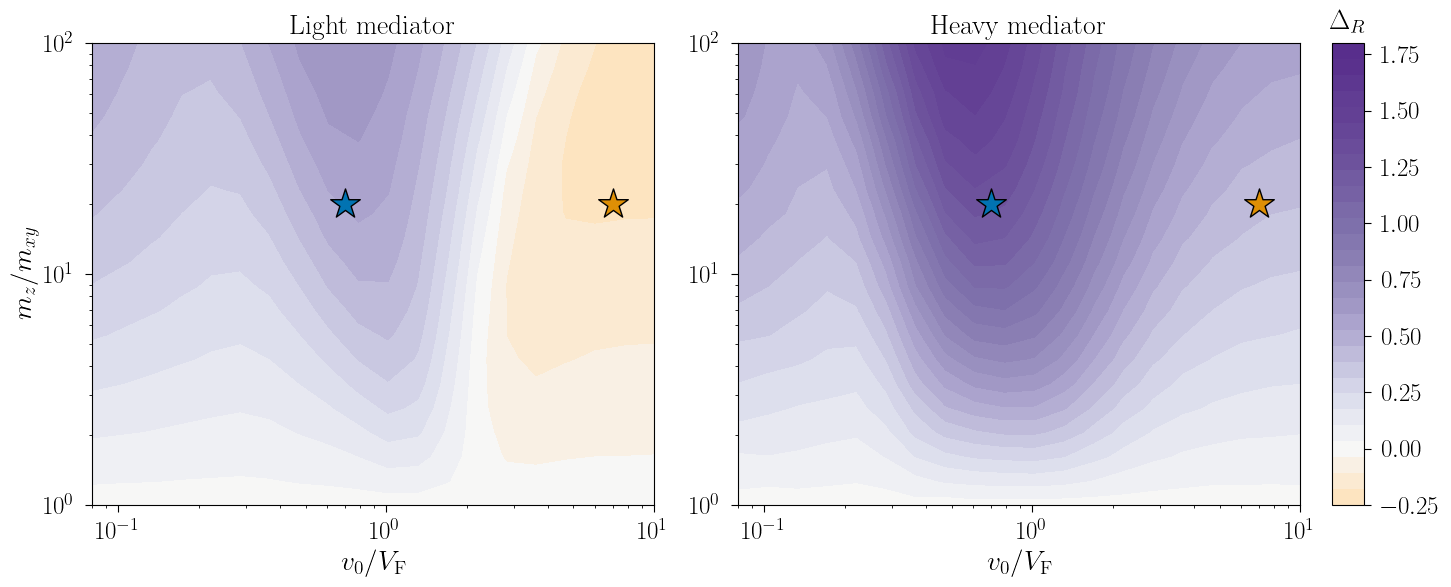

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)
fig.subplots_adjust(right=0.88, wspace=0.15)

for ax in (ax1, ax2):
    ax.loglog()
    ax.set_xlabel(r'$v_0/V_{\mathrm{F}}$')
    
upper_bound = 1.8
lower_bound = -0.25
levels = np.linspace(lower_bound, upper_bound, 30)
norm = mcolors.SymLogNorm(linthresh=0.5, linscale=0.5, vmin=-2*upper_bound, vmax=2*upper_bound, base=10)

ax = ax1
#cs = ax.contourf(X_lm, Y_lm, Z_lm[:, :, 0], levels=levels, cmap='PuOr', vmin=-upper_bound, vmax=upper_bound)
#X, Y, Z = refine(X_lm, Y_lm, Z_lm[:, :, 0], nside=50)
#X, Y, Z = X_lm, Y_lm, Z_lm[:, :, 0]
Z = Z_lm[:, :, 0]
cs = ax.contourf(X, Y, Z, cmap='PuOr', norm=norm, levels=levels)
#cs_div = ax.contour(X, Y, Z, levels=[0], colors='k', linestyles='-')
ax.set_ylabel(r'$m_z/m_{xy}$')
ax.set_title('Light mediator')

ax = ax2
#X, Y, Z = refine(X_hm, Y_hm, Z_hm[:, :, 0], nside=200)
#X, Y, Z = X_hm, Y_hm, Z_hm[:, :, 0]
Z = Z_hm[:, :, 0]
cs = ax.contourf(X, Y, Z, cmap='PuOr', norm=norm, levels=levels)
#cs_div = ax.contour(X_hm, Y_hm, Z_hm[:, :, 0], levels=[0], colors='k', linestyles='-')
ax.set_title('Heavy mediator')

cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar_ax.set_ylim(-0.25, None)
cbar_ax.set_yticks([-0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75])
#cbar_ax.set_yticklabels([-0.2, 0.2, 0.6, 1.8])
#cbar.add_lines(cs_div)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xlabel('$\Delta_R$', labelpad=10)

for ax in (ax1, ax2):
    ax.scatter([0.7], [20], marker='*', color=style.COLORS[0], s=500, edgecolor='k')
    ax.scatter([7.0], [20], marker='*', color=style.COLORS[1], s=500, edgecolor='k')

In [9]:
 fig.savefig('figures/modulation_mass_ratio.pdf', bbox_inches='tight', transparent=True)

In [1]:
from aeg.rate import delta_r, mass_vector, mean_rate, Scaler

In [2]:
s = Scaler(v0_over_vF=0.1)

In [3]:
s.v_0

0.1

In [10]:
vr = 3e-3
mass = 1.
s = Scaler(0.137593 / vr**2)
delta_r(s, mX=mass, m=mass_vector(10.), w_min=1e-2*s.eV, w_max=1e1*s.eV)

2022-12-07 09:56:12.320170: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(0.17772863840671063, 0.00039821561405691035)

# Modulation by $V_F$ and DM mass

### Compute directly

In [3]:
from aeg.rate import delta_r, mass_vector, Scaler

In [4]:
v_ratios = np.geomspace(0.08, 10, 20)
masses = np.geomspace(1e-2, 1e2, 20)
X, Y = np.meshgrid(v_ratios, masses)
Z_lm = np.zeros((X.shape[0], X.shape[1], 2))
Z_hm = np.zeros_like(Z_lm)

In [6]:
%%time
with pb.ProgressBar(max_value=X.size) as bar:
    count = 0
    for i, row in enumerate(Y):
        for j, _ in enumerate(row):
            bar.update(count)
            s = Scaler(v0_over_vF=X[i, j])
            Z_lm[i, j] = delta_r(s, mX=Y[i, j], m=mass_vector(20.), w_min=1e-2*s.eV, w_max=10*s.eV)
            count += 1

  0% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 400) |                        | Elapsed Time: 0:00:10 ETA:   1:07:46

  0% (2 of 400) |                        | Elapsed Time: 0:00:20 ETA:   1:08:26

  0% (3 of 400) |                        | Elapsed Time: 0:00:30 ETA:   1:07:15

  1% (4 of 400) |                        | Elapsed Time: 0:00:41 ETA:   1:08:13

  1% (5 of 400) |                        | Elapsed Time: 0:00:51 ETA:   1:08:26

  1% (6 of 400) |                        | Elapsed Time: 0:01:03 ETA:   1:16:33

  1% (7 of 400) |                        | Elapsed Time: 0:01:13 ETA:   1:09:43

  2% (8 of 400) |                        | Elapsed Time: 0:01:24 ETA:   1:08:50

  2% (9 of 400) |                        | Elapsed Time: 0:01:34 ETA:   1:08:17

  2% (10 of 400) |                       | Elapsed Time: 0:01:45 ETA:   1:09:53

  2% (11 of 400) |                       | Elapsed Time: 0:01:56 ETA:   1:09:12

  3% (12 of 400) |                       | Elapsed Time: 0:02:07 ETA:   1:13:10

  3% (13 of 400) |                       | Elapsed Time: 0:04:59 ETA:  18:32:38

  3% (14 of 400) |                       | Elapsed Time: 0:05:10 ETA:   1:08:40

  3% (15 of 400) |                | Elapsed Time: 0:12:22 ETA:  1 day, 22:11:26

  4% (16 of 400) |                       | Elapsed Time: 0:13:22 ETA:   6:21:44

  4% (17 of 400) |                       | Elapsed Time: 0:13:32 ETA:   1:05:03

  4% (18 of 400) |                | Elapsed Time: 0:29:47 ETA:  4 days, 7:29:17

  4% (19 of 400) |                | Elapsed Time: 0:45:06 ETA:  4 days, 1:13:31

  5% (20 of 400) |                | Elapsed Time: 1:12:14 ETA:  7 days, 3:50:37

  5% (21 of 400) |#                      | Elapsed Time: 1:12:25 ETA:   1:09:14

  5% (22 of 400) |#                      | Elapsed Time: 1:13:33 ETA:   7:08:04

  5% (23 of 400) |#                      | Elapsed Time: 1:13:46 ETA:   1:20:53

  6% (24 of 400) |#                      | Elapsed Time: 1:13:57 ETA:   1:09:57

  6% (25 of 400) |#                      | Elapsed Time: 1:14:08 ETA:   1:08:16

  6% (26 of 400) |#                      | Elapsed Time: 1:14:20 ETA:   1:19:06

  6% (27 of 400) |#                      | Elapsed Time: 1:14:31 ETA:   1:07:07

  7% (28 of 400) |#                      | Elapsed Time: 1:14:43 ETA:   1:11:58

  7% (29 of 400) |#                      | Elapsed Time: 1:14:53 ETA:   1:05:55

  7% (30 of 400) |#                      | Elapsed Time: 1:15:04 ETA:   1:07:23

  7% (31 of 400) |#                      | Elapsed Time: 1:15:15 ETA:   1:06:43

  8% (32 of 400) |#                      | Elapsed Time: 1:15:26 ETA:   1:04:59

  8% (33 of 400) |#                      | Elapsed Time: 1:15:36 ETA:   1:03:59

  8% (34 of 400) |#                      | Elapsed Time: 1:15:47 ETA:   1:04:47

  8% (35 of 400) |##                     | Elapsed Time: 1:15:57 ETA:   1:03:54

  9% (36 of 400) |##                     | Elapsed Time: 1:16:10 ETA:   1:16:50

  9% (37 of 400) |##                     | Elapsed Time: 1:16:23 ETA:   1:17:24

  9% (38 of 400) |##                     | Elapsed Time: 1:16:36 ETA:   1:17:42

  9% (39 of 400) |##                     | Elapsed Time: 1:16:49 ETA:   1:17:41

 10% (40 of 400) |##                     | Elapsed Time: 1:17:00 ETA:   1:09:19

 10% (41 of 400) |##                     | Elapsed Time: 1:17:12 ETA:   1:08:30

 10% (42 of 400) |##                     | Elapsed Time: 1:17:23 ETA:   1:06:32

 10% (43 of 400) |##                     | Elapsed Time: 1:17:34 ETA:   1:03:57

 11% (44 of 400) |##                     | Elapsed Time: 1:17:44 ETA:   1:03:46

 11% (45 of 400) |##                     | Elapsed Time: 1:17:55 ETA:   1:02:30

 11% (46 of 400) |##                     | Elapsed Time: 1:18:06 ETA:   1:02:40

 11% (47 of 400) |##                     | Elapsed Time: 1:18:16 ETA:   1:02:53

 12% (48 of 400) |##                     | Elapsed Time: 1:18:27 ETA:   1:01:26

 12% (49 of 400) |##                     | Elapsed Time: 1:18:37 ETA:   1:02:57

 12% (50 of 400) |##                     | Elapsed Time: 1:18:48 ETA:   1:01:25

 12% (51 of 400) |##                     | Elapsed Time: 1:18:58 ETA:   1:00:29

 13% (52 of 400) |##                     | Elapsed Time: 1:19:09 ETA:   1:01:03

 13% (53 of 400) |###                    | Elapsed Time: 1:19:19 ETA:   1:01:03

 13% (54 of 400) |###                    | Elapsed Time: 1:19:30 ETA:   0:59:47

 13% (55 of 400) |###                    | Elapsed Time: 1:19:40 ETA:   1:00:17

 14% (56 of 400) |###                    | Elapsed Time: 1:19:51 ETA:   0:59:52

 14% (57 of 400) |###                    | Elapsed Time: 1:20:01 ETA:   0:58:44

 14% (58 of 400) |###                    | Elapsed Time: 1:20:12 ETA:   0:59:58

 14% (59 of 400) |###                    | Elapsed Time: 1:20:22 ETA:   0:59:42

 15% (60 of 400) |###                    | Elapsed Time: 1:20:32 ETA:   0:58:39

 15% (61 of 400) |###                    | Elapsed Time: 1:20:43 ETA:   1:00:27

 15% (62 of 400) |###                    | Elapsed Time: 1:20:54 ETA:   1:00:01

 15% (63 of 400) |###                    | Elapsed Time: 1:21:04 ETA:   0:59:20

 16% (64 of 400) |###                    | Elapsed Time: 1:21:15 ETA:   0:59:42

 16% (65 of 400) |###                    | Elapsed Time: 1:21:26 ETA:   0:59:15

 16% (66 of 400) |###                    | Elapsed Time: 1:21:36 ETA:   0:58:33

 16% (67 of 400) |###                    | Elapsed Time: 1:21:47 ETA:   0:59:03

 17% (68 of 400) |###                    | Elapsed Time: 1:21:57 ETA:   0:58:43

 17% (69 of 400) |###                    | Elapsed Time: 1:22:08 ETA:   0:58:04

 17% (70 of 400) |####                   | Elapsed Time: 1:22:19 ETA:   0:58:44

 17% (71 of 400) |####                   | Elapsed Time: 1:22:29 ETA:   0:58:17

 18% (72 of 400) |####                   | Elapsed Time: 1:22:40 ETA:   0:57:22

 18% (73 of 400) |####                   | Elapsed Time: 1:22:50 ETA:   0:57:54

 18% (74 of 400) |####                   | Elapsed Time: 1:23:01 ETA:   0:57:36

 18% (75 of 400) |####                   | Elapsed Time: 1:23:11 ETA:   0:56:35

 19% (76 of 400) |####                   | Elapsed Time: 1:23:22 ETA:   0:57:05

 19% (77 of 400) |####                   | Elapsed Time: 1:23:32 ETA:   0:56:27

 19% (78 of 400) |####                   | Elapsed Time: 1:23:43 ETA:   0:55:51

 19% (79 of 400) |####                   | Elapsed Time: 1:23:53 ETA:   0:56:40

 20% (80 of 400) |####                   | Elapsed Time: 1:24:04 ETA:   0:56:17

 20% (81 of 400) |####                   | Elapsed Time: 1:24:15 ETA:   0:56:44

 20% (82 of 400) |####                   | Elapsed Time: 1:24:25 ETA:   0:57:10

 20% (83 of 400) |####                   | Elapsed Time: 1:24:36 ETA:   0:57:08

 21% (84 of 400) |####                   | Elapsed Time: 1:24:47 ETA:   0:56:09

 21% (85 of 400) |####                   | Elapsed Time: 1:24:58 ETA:   0:57:12

 21% (86 of 400) |####                   | Elapsed Time: 1:25:09 ETA:   0:56:57

 21% (87 of 400) |#####                  | Elapsed Time: 1:25:19 ETA:   0:55:04

 22% (88 of 400) |#####                  | Elapsed Time: 1:25:30 ETA:   0:55:32

 22% (89 of 400) |#####                  | Elapsed Time: 1:25:41 ETA:   0:54:44

 22% (90 of 400) |#####                  | Elapsed Time: 1:25:51 ETA:   0:53:40

 22% (91 of 400) |#####                  | Elapsed Time: 1:26:01 ETA:   0:54:26

 23% (92 of 400) |#####                  | Elapsed Time: 1:26:12 ETA:   0:54:30

 23% (93 of 400) |#####                  | Elapsed Time: 1:26:23 ETA:   0:53:10

 23% (94 of 400) |#####                  | Elapsed Time: 1:26:33 ETA:   0:53:44

 23% (95 of 400) |#####                  | Elapsed Time: 1:26:44 ETA:   0:53:34

 24% (96 of 400) |#####                  | Elapsed Time: 1:26:54 ETA:   0:52:22

 24% (97 of 400) |#####                  | Elapsed Time: 1:27:04 ETA:   0:52:58

 24% (98 of 400) |#####                  | Elapsed Time: 1:27:15 ETA:   0:52:52

 24% (99 of 400) |#####                  | Elapsed Time: 1:27:25 ETA:   0:52:25

 25% (100 of 400) |#####                 | Elapsed Time: 1:27:36 ETA:   0:53:48

 25% (101 of 400) |#####                 | Elapsed Time: 1:27:47 ETA:   0:53:48

 25% (102 of 400) |#####                 | Elapsed Time: 1:27:58 ETA:   0:52:52

 25% (103 of 400) |#####                 | Elapsed Time: 1:28:08 ETA:   0:53:47

 26% (104 of 400) |#####                 | Elapsed Time: 1:28:19 ETA:   0:53:41

 26% (105 of 400) |#####                 | Elapsed Time: 1:28:30 ETA:   0:53:23

 26% (106 of 400) |#####                 | Elapsed Time: 1:28:41 ETA:   0:53:01

 26% (107 of 400) |#####                 | Elapsed Time: 1:28:52 ETA:   0:52:08

 27% (108 of 400) |#####                 | Elapsed Time: 1:29:02 ETA:   0:51:20

 27% (109 of 400) |#####                 | Elapsed Time: 1:29:13 ETA:   0:51:43

 27% (110 of 400) |######                | Elapsed Time: 1:29:24 ETA:   0:51:31

 27% (111 of 400) |######                | Elapsed Time: 1:29:34 ETA:   0:50:32

 28% (112 of 400) |######                | Elapsed Time: 1:29:45 ETA:   0:50:52

 28% (113 of 400) |######                | Elapsed Time: 1:29:55 ETA:   0:50:26

 28% (114 of 400) |######                | Elapsed Time: 1:30:06 ETA:   0:49:31

 28% (115 of 400) |######                | Elapsed Time: 1:30:16 ETA:   0:50:14

 29% (116 of 400) |######                | Elapsed Time: 1:30:27 ETA:   0:49:54

 29% (117 of 400) |######                | Elapsed Time: 1:30:37 ETA:   0:49:12

 29% (118 of 400) |######                | Elapsed Time: 1:30:48 ETA:   0:49:35

 29% (119 of 400) |######                | Elapsed Time: 1:30:58 ETA:   0:49:17

 30% (120 of 400) |######                | Elapsed Time: 1:31:09 ETA:   0:48:33

 30% (121 of 400) |######                | Elapsed Time: 1:31:19 ETA:   0:49:52

 30% (122 of 400) |######                | Elapsed Time: 1:31:30 ETA:   0:49:47

 30% (123 of 400) |######                | Elapsed Time: 1:31:41 ETA:   0:48:47

 31% (124 of 400) |######                | Elapsed Time: 1:31:51 ETA:   0:49:29

 31% (125 of 400) |######                | Elapsed Time: 1:32:02 ETA:   0:49:00

 31% (126 of 400) |######                | Elapsed Time: 1:32:13 ETA:   0:48:24

 31% (127 of 400) |######                | Elapsed Time: 1:32:23 ETA:   0:48:47

 32% (128 of 400) |#######               | Elapsed Time: 1:32:34 ETA:   0:48:25

 32% (129 of 400) |#######               | Elapsed Time: 1:32:45 ETA:   0:47:21

 32% (130 of 400) |#######               | Elapsed Time: 1:32:55 ETA:   0:47:48

 32% (131 of 400) |#######               | Elapsed Time: 1:33:06 ETA:   0:47:53

 33% (132 of 400) |#######               | Elapsed Time: 1:33:16 ETA:   0:47:09

 33% (133 of 400) |#######               | Elapsed Time: 1:33:27 ETA:   0:47:52

 33% (134 of 400) |#######               | Elapsed Time: 1:33:38 ETA:   0:47:31

 33% (135 of 400) |#######               | Elapsed Time: 1:33:48 ETA:   0:46:34

 34% (136 of 400) |#######               | Elapsed Time: 1:33:59 ETA:   0:46:43

 34% (137 of 400) |#######               | Elapsed Time: 1:34:10 ETA:   0:46:16

 34% (138 of 400) |#######               | Elapsed Time: 1:34:20 ETA:   0:45:29

 34% (139 of 400) |#######               | Elapsed Time: 1:34:31 ETA:   0:45:44

 35% (140 of 400) |#######               | Elapsed Time: 1:34:41 ETA:   0:45:39

 35% (141 of 400) |#######               | Elapsed Time: 1:34:52 ETA:   0:46:10

 35% (142 of 400) |#######               | Elapsed Time: 1:35:03 ETA:   0:46:30

 35% (143 of 400) |#######               | Elapsed Time: 1:35:13 ETA:   0:45:50

 36% (144 of 400) |#######               | Elapsed Time: 1:35:24 ETA:   0:45:11

 36% (145 of 400) |#######               | Elapsed Time: 1:35:35 ETA:   0:45:21

 36% (146 of 400) |########              | Elapsed Time: 1:35:45 ETA:   0:45:08

 36% (147 of 400) |########              | Elapsed Time: 1:35:56 ETA:   0:44:22

 37% (148 of 400) |########              | Elapsed Time: 1:36:07 ETA:   0:44:56

 37% (149 of 400) |########              | Elapsed Time: 1:36:17 ETA:   0:44:55

 37% (150 of 400) |########              | Elapsed Time: 1:36:28 ETA:   0:43:57

 37% (151 of 400) |########              | Elapsed Time: 1:36:38 ETA:   0:44:07

 38% (152 of 400) |########              | Elapsed Time: 1:36:49 ETA:   0:43:48

 38% (153 of 400) |########              | Elapsed Time: 1:36:59 ETA:   0:42:56

 38% (154 of 400) |########              | Elapsed Time: 1:37:10 ETA:   0:43:11

 38% (155 of 400) |########              | Elapsed Time: 1:37:20 ETA:   0:42:45

 39% (156 of 400) |########              | Elapsed Time: 1:37:31 ETA:   0:42:30

 39% (157 of 400) |########              | Elapsed Time: 1:37:41 ETA:   0:42:20

 39% (158 of 400) |########              | Elapsed Time: 1:37:52 ETA:   0:42:02

 39% (159 of 400) |########              | Elapsed Time: 1:38:02 ETA:   0:41:19

 40% (160 of 400) |########              | Elapsed Time: 1:38:13 ETA:   0:42:00

 40% (161 of 400) |########              | Elapsed Time: 1:38:23 ETA:   0:42:32

 40% (162 of 400) |########              | Elapsed Time: 1:38:34 ETA:   0:42:00

 40% (163 of 400) |########              | Elapsed Time: 1:38:45 ETA:   0:42:08

 41% (164 of 400) |#########             | Elapsed Time: 1:38:55 ETA:   0:41:53

 41% (165 of 400) |#########             | Elapsed Time: 1:39:06 ETA:   0:41:15

 41% (166 of 400) |#########             | Elapsed Time: 1:39:16 ETA:   0:41:29

 41% (167 of 400) |#########             | Elapsed Time: 1:39:27 ETA:   0:41:05

 42% (168 of 400) |#########             | Elapsed Time: 1:39:37 ETA:   0:40:34

 42% (169 of 400) |#########             | Elapsed Time: 1:39:48 ETA:   0:40:53

 42% (170 of 400) |#########             | Elapsed Time: 1:39:59 ETA:   0:40:32

 42% (171 of 400) |#########             | Elapsed Time: 1:40:09 ETA:   0:39:49

 43% (172 of 400) |#########             | Elapsed Time: 1:40:20 ETA:   0:40:12

 43% (173 of 400) |#########             | Elapsed Time: 1:40:30 ETA:   0:39:55

 43% (174 of 400) |#########             | Elapsed Time: 1:40:41 ETA:   0:39:14

 43% (175 of 400) |#########             | Elapsed Time: 1:40:51 ETA:   0:39:45

 44% (176 of 400) |#########             | Elapsed Time: 1:41:02 ETA:   0:39:24

 44% (177 of 400) |#########             | Elapsed Time: 1:41:12 ETA:   0:38:36

 44% (178 of 400) |#########             | Elapsed Time: 1:41:23 ETA:   0:38:50

 44% (179 of 400) |#########             | Elapsed Time: 1:41:33 ETA:   0:38:20

 45% (180 of 400) |#########             | Elapsed Time: 1:41:43 ETA:   0:37:44

 45% (181 of 400) |#########             | Elapsed Time: 1:41:54 ETA:   0:38:43

 45% (182 of 400) |##########            | Elapsed Time: 1:42:05 ETA:   0:38:22

 45% (183 of 400) |##########            | Elapsed Time: 1:42:15 ETA:   0:37:31

 46% (184 of 400) |##########            | Elapsed Time: 1:42:25 ETA:   0:38:05

 46% (185 of 400) |##########            | Elapsed Time: 1:42:36 ETA:   0:37:49

 46% (186 of 400) |##########            | Elapsed Time: 1:42:46 ETA:   0:37:08

 46% (187 of 400) |##########            | Elapsed Time: 1:42:57 ETA:   0:37:44

 47% (188 of 400) |##########            | Elapsed Time: 1:43:08 ETA:   0:37:52

 47% (189 of 400) |##########            | Elapsed Time: 1:43:18 ETA:   0:36:47

 47% (190 of 400) |##########            | Elapsed Time: 1:43:29 ETA:   0:36:58

 47% (191 of 400) |##########            | Elapsed Time: 1:43:39 ETA:   0:36:50

 48% (192 of 400) |##########            | Elapsed Time: 1:43:50 ETA:   0:36:24

 48% (193 of 400) |##########            | Elapsed Time: 1:44:01 ETA:   0:36:38

 48% (194 of 400) |##########            | Elapsed Time: 1:44:11 ETA:   0:36:25

 48% (195 of 400) |##########            | Elapsed Time: 1:44:22 ETA:   0:35:32

 49% (196 of 400) |##########            | Elapsed Time: 1:44:32 ETA:   0:35:57

 49% (197 of 400) |##########            | Elapsed Time: 1:44:43 ETA:   0:35:36

 49% (198 of 400) |##########            | Elapsed Time: 1:44:54 ETA:   0:38:25

 49% (199 of 400) |##########            | Elapsed Time: 1:45:05 ETA:   0:35:33

 50% (200 of 400) |###########           | Elapsed Time: 1:45:15 ETA:   0:35:18

 50% (201 of 400) |###########           | Elapsed Time: 1:45:26 ETA:   0:34:47

 50% (202 of 400) |###########           | Elapsed Time: 1:45:36 ETA:   0:35:13

 50% (203 of 400) |###########           | Elapsed Time: 1:45:47 ETA:   0:34:58

 51% (204 of 400) |###########           | Elapsed Time: 1:45:58 ETA:   0:34:10

 51% (205 of 400) |###########           | Elapsed Time: 1:46:09 ETA:   0:36:44

 51% (206 of 400) |###########           | Elapsed Time: 1:46:21 ETA:   0:39:31

 51% (207 of 400) |###########           | Elapsed Time: 1:46:32 ETA:   0:35:34

 52% (208 of 400) |###########           | Elapsed Time: 1:46:43 ETA:   0:34:52

 52% (209 of 400) |###########           | Elapsed Time: 1:46:54 ETA:   0:34:52

 52% (210 of 400) |###########           | Elapsed Time: 1:47:05 ETA:   0:33:22

 52% (211 of 400) |###########           | Elapsed Time: 1:47:15 ETA:   0:33:05

 53% (212 of 400) |###########           | Elapsed Time: 1:47:26 ETA:   0:32:56

 53% (213 of 400) |###########           | Elapsed Time: 1:47:36 ETA:   0:32:20

 53% (214 of 400) |###########           | Elapsed Time: 1:47:46 ETA:   0:32:37

 53% (215 of 400) |###########           | Elapsed Time: 1:47:57 ETA:   0:32:25

 54% (216 of 400) |###########           | Elapsed Time: 1:48:07 ETA:   0:32:01

 54% (217 of 400) |###########           | Elapsed Time: 1:48:18 ETA:   0:32:20

 54% (218 of 400) |###########           | Elapsed Time: 1:48:29 ETA:   0:33:58

 54% (219 of 400) |############          | Elapsed Time: 1:48:41 ETA:   0:34:16

 55% (220 of 400) |############          | Elapsed Time: 1:48:52 ETA:   0:33:49

 55% (221 of 400) |############          | Elapsed Time: 1:49:03 ETA:   0:33:29

 55% (222 of 400) |############          | Elapsed Time: 1:49:14 ETA:   0:32:55

 55% (223 of 400) |############          | Elapsed Time: 1:49:25 ETA:   0:31:45

 56% (224 of 400) |############          | Elapsed Time: 1:49:36 ETA:   0:31:08

 56% (225 of 400) |############          | Elapsed Time: 1:49:46 ETA:   0:30:36

 56% (226 of 400) |############          | Elapsed Time: 1:49:57 ETA:   0:30:55

 56% (227 of 400) |############          | Elapsed Time: 1:50:07 ETA:   0:30:48

 57% (228 of 400) |############          | Elapsed Time: 1:50:18 ETA:   0:30:38

 57% (229 of 400) |############          | Elapsed Time: 1:50:29 ETA:   0:31:10

 57% (230 of 400) |############          | Elapsed Time: 1:50:40 ETA:   0:31:51

 57% (231 of 400) |############          | Elapsed Time: 1:50:51 ETA:   0:30:32

 58% (232 of 400) |############          | Elapsed Time: 1:51:02 ETA:   0:30:37

 58% (233 of 400) |############          | Elapsed Time: 1:51:13 ETA:   0:30:29

 58% (234 of 400) |############          | Elapsed Time: 1:51:24 ETA:   0:29:42

 58% (235 of 400) |############          | Elapsed Time: 1:51:35 ETA:   0:29:51

 59% (236 of 400) |############          | Elapsed Time: 1:51:46 ETA:   0:29:47

 59% (237 of 400) |#############         | Elapsed Time: 1:51:56 ETA:   0:29:12

 59% (238 of 400) |#############         | Elapsed Time: 1:52:07 ETA:   0:29:30

 59% (239 of 400) |#############         | Elapsed Time: 1:52:18 ETA:   0:29:22

 60% (240 of 400) |#############         | Elapsed Time: 1:52:29 ETA:   0:28:54

 60% (241 of 400) |#############         | Elapsed Time: 1:52:40 ETA:   0:29:05

 60% (242 of 400) |#############         | Elapsed Time: 1:52:51 ETA:   0:28:46

 60% (243 of 400) |#############         | Elapsed Time: 1:53:02 ETA:   0:28:07

 61% (244 of 400) |#############         | Elapsed Time: 1:53:13 ETA:   0:29:17

 61% (245 of 400) |#############         | Elapsed Time: 1:53:24 ETA:   0:28:19

 61% (246 of 400) |#############         | Elapsed Time: 1:53:35 ETA:   0:27:43

 61% (247 of 400) |#############         | Elapsed Time: 1:53:46 ETA:   0:27:58

 62% (248 of 400) |#############         | Elapsed Time: 1:53:57 ETA:   0:27:33

 62% (249 of 400) |#############         | Elapsed Time: 1:54:07 ETA:   0:27:34

 62% (250 of 400) |#############         | Elapsed Time: 1:54:18 ETA:   0:27:23

 62% (251 of 400) |#############         | Elapsed Time: 1:54:30 ETA:   0:27:36

 63% (252 of 400) |#############         | Elapsed Time: 1:54:40 ETA:   0:26:36

 63% (253 of 400) |#############         | Elapsed Time: 1:54:51 ETA:   0:27:19

 63% (254 of 400) |#############         | Elapsed Time: 1:55:03 ETA:   0:27:19

 63% (255 of 400) |##############        | Elapsed Time: 1:55:14 ETA:   0:26:31

 64% (256 of 400) |##############        | Elapsed Time: 1:55:25 ETA:   0:26:56

 64% (257 of 400) |##############        | Elapsed Time: 1:55:36 ETA:   0:26:32

 64% (258 of 400) |##############        | Elapsed Time: 1:55:47 ETA:   0:25:44

 64% (259 of 400) |##############        | Elapsed Time: 1:55:58 ETA:   0:25:50

 65% (260 of 400) |##############        | Elapsed Time: 1:56:09 ETA:   0:25:31

 65% (261 of 400) |##############        | Elapsed Time: 1:56:20 ETA:   0:25:07

 65% (262 of 400) |##############        | Elapsed Time: 1:56:31 ETA:   0:25:06

 65% (263 of 400) |##############        | Elapsed Time: 1:56:42 ETA:   0:25:07

 66% (264 of 400) |##############        | Elapsed Time: 1:56:52 ETA:   0:24:31

 66% (265 of 400) |##############        | Elapsed Time: 1:57:03 ETA:   0:24:41

 66% (266 of 400) |##############        | Elapsed Time: 1:57:14 ETA:   0:24:29

 66% (267 of 400) |##############        | Elapsed Time: 1:57:25 ETA:   0:23:56

 67% (268 of 400) |##############        | Elapsed Time: 1:57:36 ETA:   0:24:21

 67% (269 of 400) |##############        | Elapsed Time: 1:57:47 ETA:   0:23:50

 67% (270 of 400) |##############        | Elapsed Time: 1:57:58 ETA:   0:23:22

 67% (271 of 400) |##############        | Elapsed Time: 1:58:09 ETA:   0:23:20

 68% (272 of 400) |##############        | Elapsed Time: 1:58:20 ETA:   0:23:28

 68% (273 of 400) |###############       | Elapsed Time: 1:58:31 ETA:   0:22:43

 68% (274 of 400) |###############       | Elapsed Time: 1:58:41 ETA:   0:22:54

 68% (275 of 400) |###############       | Elapsed Time: 1:58:52 ETA:   0:22:39

 69% (276 of 400) |###############       | Elapsed Time: 1:59:03 ETA:   0:22:15

 69% (277 of 400) |###############       | Elapsed Time: 1:59:14 ETA:   0:22:19

 69% (278 of 400) |###############       | Elapsed Time: 1:59:25 ETA:   0:23:02

 69% (279 of 400) |###############       | Elapsed Time: 1:59:37 ETA:   0:23:08

 70% (280 of 400) |###############       | Elapsed Time: 1:59:48 ETA:   0:22:43

 70% (281 of 400) |###############       | Elapsed Time: 1:59:59 ETA:   0:22:05

 70% (282 of 400) |###############       | Elapsed Time: 2:00:11 ETA:   0:21:58

 70% (283 of 400) |###############       | Elapsed Time: 2:00:22 ETA:   0:21:53

 71% (284 of 400) |###############       | Elapsed Time: 2:00:33 ETA:   0:21:29

 71% (285 of 400) |###############       | Elapsed Time: 2:00:43 ETA:   0:20:16

 71% (286 of 400) |###############       | Elapsed Time: 2:00:54 ETA:   0:20:24

 71% (287 of 400) |###############       | Elapsed Time: 2:01:05 ETA:   0:20:29

 72% (288 of 400) |###############       | Elapsed Time: 2:01:16 ETA:   0:20:01

 72% (289 of 400) |###############       | Elapsed Time: 2:01:27 ETA:   0:20:13

 72% (290 of 400) |###############       | Elapsed Time: 2:01:38 ETA:   0:20:07

 72% (291 of 400) |################      | Elapsed Time: 2:01:48 ETA:   0:19:17

 73% (292 of 400) |################      | Elapsed Time: 2:01:59 ETA:   0:19:15

 73% (293 of 400) |################      | Elapsed Time: 2:02:10 ETA:   0:19:28

 73% (294 of 400) |################      | Elapsed Time: 2:02:21 ETA:   0:19:33

 73% (295 of 400) |################      | Elapsed Time: 2:02:32 ETA:   0:19:28

 74% (296 of 400) |################      | Elapsed Time: 2:02:43 ETA:   0:18:58

 74% (297 of 400) |################      | Elapsed Time: 2:02:54 ETA:   0:18:28

 74% (298 of 400) |################      | Elapsed Time: 2:03:05 ETA:   0:19:04

 74% (299 of 400) |################      | Elapsed Time: 2:03:17 ETA:   0:19:19

 75% (300 of 400) |################      | Elapsed Time: 2:03:28 ETA:   0:18:37

 75% (301 of 400) |################      | Elapsed Time: 2:03:39 ETA:   0:18:26

 75% (302 of 400) |################      | Elapsed Time: 2:03:50 ETA:   0:18:50

 75% (303 of 400) |################      | Elapsed Time: 2:04:02 ETA:   0:18:01

 76% (304 of 400) |################      | Elapsed Time: 2:04:13 ETA:   0:18:11

 76% (305 of 400) |################      | Elapsed Time: 2:04:24 ETA:   0:17:50

 76% (306 of 400) |################      | Elapsed Time: 2:04:35 ETA:   0:17:15

 76% (307 of 400) |################      | Elapsed Time: 2:04:47 ETA:   0:17:42

 77% (308 of 400) |################      | Elapsed Time: 2:04:58 ETA:   0:17:26

 77% (309 of 400) |################      | Elapsed Time: 2:05:09 ETA:   0:16:26

 77% (310 of 400) |#################     | Elapsed Time: 2:05:20 ETA:   0:16:09

 77% (311 of 400) |#################     | Elapsed Time: 2:05:30 ETA:   0:15:45

 78% (312 of 400) |#################     | Elapsed Time: 2:05:41 ETA:   0:15:20

 78% (313 of 400) |#################     | Elapsed Time: 2:05:52 ETA:   0:15:37

 78% (314 of 400) |#################     | Elapsed Time: 2:06:03 ETA:   0:16:11

 78% (315 of 400) |#################     | Elapsed Time: 2:06:14 ETA:   0:15:21

 79% (316 of 400) |#################     | Elapsed Time: 2:06:25 ETA:   0:15:33

 79% (317 of 400) |#################     | Elapsed Time: 2:06:36 ETA:   0:15:56

 79% (318 of 400) |#################     | Elapsed Time: 2:06:47 ETA:   0:14:53

 79% (319 of 400) |#################     | Elapsed Time: 2:06:58 ETA:   0:15:15

 80% (320 of 400) |#################     | Elapsed Time: 2:07:10 ETA:   0:15:03

 80% (321 of 400) |#################     | Elapsed Time: 2:07:21 ETA:   0:14:15

 80% (322 of 400) |#################     | Elapsed Time: 2:07:32 ETA:   0:14:13

 80% (323 of 400) |#################     | Elapsed Time: 2:07:42 ETA:   0:14:02

 81% (324 of 400) |#################     | Elapsed Time: 2:07:53 ETA:   0:13:30

 81% (325 of 400) |#################     | Elapsed Time: 2:08:04 ETA:   0:13:32

 81% (326 of 400) |#################     | Elapsed Time: 2:08:15 ETA:   0:13:33

 81% (327 of 400) |#################     | Elapsed Time: 2:08:26 ETA:   0:13:24

 82% (328 of 400) |##################    | Elapsed Time: 2:08:37 ETA:   0:12:58

 82% (329 of 400) |##################    | Elapsed Time: 2:08:48 ETA:   0:12:43

 82% (330 of 400) |##################    | Elapsed Time: 2:08:58 ETA:   0:12:29

 82% (331 of 400) |##################    | Elapsed Time: 2:09:09 ETA:   0:12:30

 83% (332 of 400) |##################    | Elapsed Time: 2:09:20 ETA:   0:12:19

 83% (333 of 400) |##################    | Elapsed Time: 2:09:31 ETA:   0:11:55

 83% (334 of 400) |##################    | Elapsed Time: 2:09:42 ETA:   0:11:58

 83% (335 of 400) |##################    | Elapsed Time: 2:09:53 ETA:   0:12:19

 84% (336 of 400) |##################    | Elapsed Time: 2:10:04 ETA:   0:11:58

 84% (337 of 400) |##################    | Elapsed Time: 2:10:15 ETA:   0:11:25

 84% (338 of 400) |##################    | Elapsed Time: 2:10:26 ETA:   0:11:19

 84% (339 of 400) |##################    | Elapsed Time: 2:10:37 ETA:   0:10:59

 85% (340 of 400) |##################    | Elapsed Time: 2:10:48 ETA:   0:10:50

 85% (341 of 400) |##################    | Elapsed Time: 2:10:59 ETA:   0:10:56

 85% (342 of 400) |##################    | Elapsed Time: 2:11:10 ETA:   0:10:28

 85% (343 of 400) |##################    | Elapsed Time: 2:11:21 ETA:   0:10:29

 86% (344 of 400) |##################    | Elapsed Time: 2:11:32 ETA:   0:10:09

 86% (345 of 400) |##################    | Elapsed Time: 2:11:42 ETA:   0:09:51

 86% (346 of 400) |###################   | Elapsed Time: 2:11:53 ETA:   0:09:46

 86% (347 of 400) |###################   | Elapsed Time: 2:12:04 ETA:   0:09:48

 87% (348 of 400) |###################   | Elapsed Time: 2:12:15 ETA:   0:09:19

 87% (349 of 400) |###################   | Elapsed Time: 2:12:26 ETA:   0:09:20

 87% (350 of 400) |###################   | Elapsed Time: 2:12:37 ETA:   0:09:02

 87% (351 of 400) |###################   | Elapsed Time: 2:12:48 ETA:   0:08:45

 88% (352 of 400) |###################   | Elapsed Time: 2:12:59 ETA:   0:08:48

 88% (353 of 400) |###################   | Elapsed Time: 2:13:10 ETA:   0:08:44

 88% (354 of 400) |###################   | Elapsed Time: 2:13:21 ETA:   0:08:17

 88% (355 of 400) |###################   | Elapsed Time: 2:13:32 ETA:   0:08:11

 89% (356 of 400) |###################   | Elapsed Time: 2:13:43 ETA:   0:08:07

 89% (357 of 400) |###################   | Elapsed Time: 2:13:53 ETA:   0:07:41

 89% (358 of 400) |###################   | Elapsed Time: 2:14:04 ETA:   0:07:41

 89% (359 of 400) |###################   | Elapsed Time: 2:14:15 ETA:   0:07:24

 90% (360 of 400) |###################   | Elapsed Time: 2:14:26 ETA:   0:07:09

 90% (361 of 400) |###################   | Elapsed Time: 2:14:37 ETA:   0:07:07

 90% (362 of 400) |###################   | Elapsed Time: 2:14:48 ETA:   0:07:07

 90% (363 of 400) |###################   | Elapsed Time: 2:14:59 ETA:   0:06:37

 91% (364 of 400) |####################  | Elapsed Time: 2:15:10 ETA:   0:06:27

 91% (365 of 400) |####################  | Elapsed Time: 2:15:21 ETA:   0:06:32

 91% (366 of 400) |####################  | Elapsed Time: 2:15:32 ETA:   0:06:11

 91% (367 of 400) |####################  | Elapsed Time: 2:15:43 ETA:   0:06:03

 92% (368 of 400) |####################  | Elapsed Time: 2:15:54 ETA:   0:05:46

 92% (369 of 400) |####################  | Elapsed Time: 2:16:04 ETA:   0:05:31

 92% (370 of 400) |####################  | Elapsed Time: 2:16:15 ETA:   0:05:23

 92% (371 of 400) |####################  | Elapsed Time: 2:16:27 ETA:   0:05:32

 93% (372 of 400) |####################  | Elapsed Time: 2:16:37 ETA:   0:04:56

 93% (373 of 400) |####################  | Elapsed Time: 2:16:48 ETA:   0:04:46

 93% (374 of 400) |####################  | Elapsed Time: 2:16:58 ETA:   0:04:35

 93% (375 of 400) |####################  | Elapsed Time: 2:17:09 ETA:   0:04:19

 94% (376 of 400) |####################  | Elapsed Time: 2:17:19 ETA:   0:04:13

 94% (377 of 400) |####################  | Elapsed Time: 2:17:30 ETA:   0:04:02

 94% (378 of 400) |####################  | Elapsed Time: 2:17:40 ETA:   0:03:47

 94% (379 of 400) |####################  | Elapsed Time: 2:17:51 ETA:   0:03:42

 95% (380 of 400) |####################  | Elapsed Time: 2:18:01 ETA:   0:03:30

 95% (381 of 400) |####################  | Elapsed Time: 2:18:12 ETA:   0:03:19

 95% (382 of 400) |##################### | Elapsed Time: 2:18:22 ETA:   0:03:12

 95% (383 of 400) |##################### | Elapsed Time: 2:18:33 ETA:   0:03:00

 96% (384 of 400) |##################### | Elapsed Time: 2:18:44 ETA:   0:02:47

 96% (385 of 400) |##################### | Elapsed Time: 2:18:54 ETA:   0:02:39

 96% (386 of 400) |##################### | Elapsed Time: 2:19:05 ETA:   0:02:28

 96% (387 of 400) |##################### | Elapsed Time: 2:19:15 ETA:   0:02:15

 97% (388 of 400) |##################### | Elapsed Time: 2:19:26 ETA:   0:02:09

 97% (389 of 400) |##################### | Elapsed Time: 2:19:37 ETA:   0:02:01

 97% (390 of 400) |##################### | Elapsed Time: 2:19:48 ETA:   0:01:50

 97% (391 of 400) |##################### | Elapsed Time: 2:19:59 ETA:   0:01:40

 98% (392 of 400) |##################### | Elapsed Time: 2:20:11 ETA:   0:01:30

 98% (393 of 400) |##################### | Elapsed Time: 2:20:22 ETA:   0:01:18

 98% (394 of 400) |##################### | Elapsed Time: 2:20:33 ETA:   0:01:04

 98% (395 of 400) |##################### | Elapsed Time: 2:20:44 ETA:   0:00:54

 99% (396 of 400) |##################### | Elapsed Time: 2:20:54 ETA:   0:00:43

 99% (397 of 400) |##################### | Elapsed Time: 2:21:05 ETA:   0:00:32

 99% (398 of 400) |##################### | Elapsed Time: 2:21:16 ETA:   0:00:21

 99% (399 of 400) |##################### | Elapsed Time: 2:21:27 ETA:   0:00:10

100% (400 of 400) |######################| Elapsed Time: 2:21:38 Time:  2:21:38


CPU times: user 5h 45min 14s, sys: 2h 1min 55s, total: 7h 47min 10s
Wall time: 2h 21min 38s


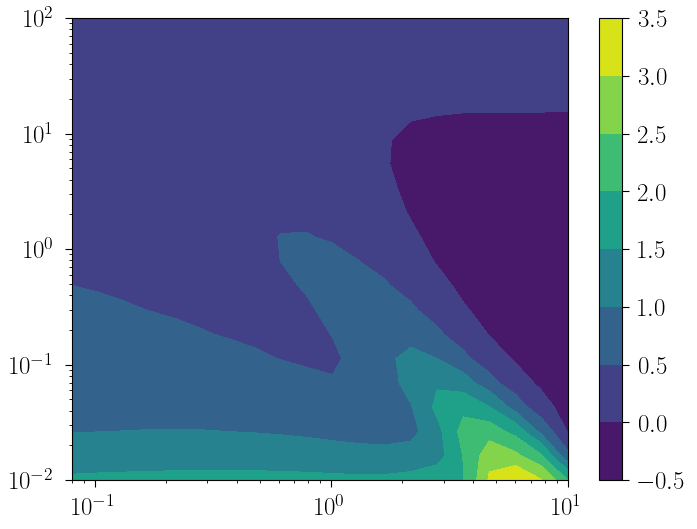

In [12]:
plt.loglog()
plt.contourf(X, Y, Z_lm[:, :, 0])
plt.colorbar()

In [13]:
%%time
with pb.ProgressBar(max_value=X.size) as bar:
    count = 0
    for i, row in enumerate(Y):
        for j, _ in enumerate(row):
            bar.update(count)
            s = Scaler(v0_over_vF=X[i, j])
            Z_hm[i, j] = delta_r(s, mX=Y[i, j], m=mass_vector(20.), w_min=1e-2*s.eV, w_max=10*s.eV, m_med=1000)
            count += 1

  0% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 400) |                 | Elapsed Time: 0:12:15 ETA:  3 days, 9:29:47

  0% (2 of 400) |                 | Elapsed Time: 0:24:22 ETA:  3 days, 8:22:19

  0% (3 of 400) |                 | Elapsed Time: 0:36:32 ETA:  3 days, 8:34:33

  1% (4 of 400) |                 | Elapsed Time: 0:48:38 ETA:  3 days, 7:46:27

  1% (5 of 400) |                 | Elapsed Time: 1:00:51 ETA:  3 days, 8:27:54

  1% (6 of 400) |                 | Elapsed Time: 1:12:59 ETA:  3 days, 7:41:39

  1% (7 of 400) |                 | Elapsed Time: 1:24:41 ETA:  3 days, 4:38:27

  2% (8 of 400) |                 | Elapsed Time: 1:36:35 ETA:  3 days, 5:43:20

  2% (9 of 400) |                 | Elapsed Time: 1:48:33 ETA:  3 days, 5:58:40

  2% (10 of 400) |                | Elapsed Time: 2:00:31 ETA:  3 days, 5:50:06

  2% (11 of 400) |                | Elapsed Time: 2:12:23 ETA:  3 days, 4:52:38

  3% (12 of 400) |                | Elapsed Time: 2:24:19 ETA:  3 days, 5:13:21

  3% (13 of 400) |                | Elapsed Time: 2:36:17 ETA:  3 days, 5:06:47

  3% (14 of 400) |                | Elapsed Time: 2:48:17 ETA:  3 days, 5:13:42

  3% (15 of 400) |                | Elapsed Time: 3:00:18 ETA:  3 days, 5:08:16

  4% (16 of 400) |                | Elapsed Time: 3:12:20 ETA:  3 days, 4:57:05

  4% (17 of 400) |                | Elapsed Time: 3:24:28 ETA:  3 days, 5:25:56

  4% (18 of 400) |                | Elapsed Time: 3:48:34 ETA:  6 days, 9:27:24

  4% (19 of 400) |               | Elapsed Time: 4:24:16 ETA:  9 days, 10:42:23

  5% (20 of 400) |               | Elapsed Time: 4:59:58 ETA:  9 days, 10:04:53

  5% (21 of 400) |                 | Elapsed Time: 5:04:06 ETA:  1 day, 2:08:56

  5% (22 of 400) |                 | Elapsed Time: 5:08:15 ETA:  1 day, 2:08:18

  5% (23 of 400) |                 | Elapsed Time: 5:12:18 ETA:  1 day, 1:26:55

  6% (24 of 400) |#                | Elapsed Time: 5:16:19 ETA:  1 day, 1:09:46

  6% (25 of 400) |#                | Elapsed Time: 5:20:16 ETA:  1 day, 0:38:42

  6% (26 of 400) |#                | Elapsed Time: 5:24:11 ETA:  1 day, 0:24:53

  6% (27 of 400) |#                | Elapsed Time: 5:28:12 ETA:  1 day, 0:58:52

  7% (28 of 400) |#                | Elapsed Time: 5:32:14 ETA:  1 day, 1:04:32

  7% (29 of 400) |#                | Elapsed Time: 5:36:18 ETA:  1 day, 1:05:30

  7% (30 of 400) |#                | Elapsed Time: 5:40:21 ETA:  1 day, 0:58:34

  7% (31 of 400) |#                | Elapsed Time: 5:44:20 ETA:  1 day, 0:31:20

  8% (32 of 400) |#                | Elapsed Time: 5:48:26 ETA:  1 day, 1:08:07

  8% (33 of 400) |#                | Elapsed Time: 5:52:29 ETA:  1 day, 0:43:57

  8% (34 of 400) |#                | Elapsed Time: 5:56:30 ETA:  1 day, 0:30:04

  8% (35 of 400) |#                | Elapsed Time: 6:00:32 ETA:  1 day, 0:33:57

  9% (36 of 400) |#                | Elapsed Time: 6:04:30 ETA:  1 day, 0:03:32

  9% (37 of 400) |#               | Elapsed Time: 6:12:22 ETA:  1 day, 23:39:25

  9% (38 of 400) |#              | Elapsed Time: 6:35:52 ETA:  5 days, 21:44:23

KeyboardInterrupt: 

In [7]:
np.savez('vary_dm_mass.npz', v_ratios=v_ratios, masses=masses, X=X, Y=Y, Z_lm=Z_lm)

In [14]:
data = np.load('output/vary_dm_mass_lm.npz')
X_lm, Y_lm, Z_lm = data['X'], data['Y'], data['Z']
X_lm = 0.3709/np.sqrt(X_lm)
data = np.load('output/vary_dm_mass_hm.npz')
X_hm, Y_hm, Z_hm = data['X'], data['Y'], data['Z']

Text(0.5, 0, '$\\Delta_R$')

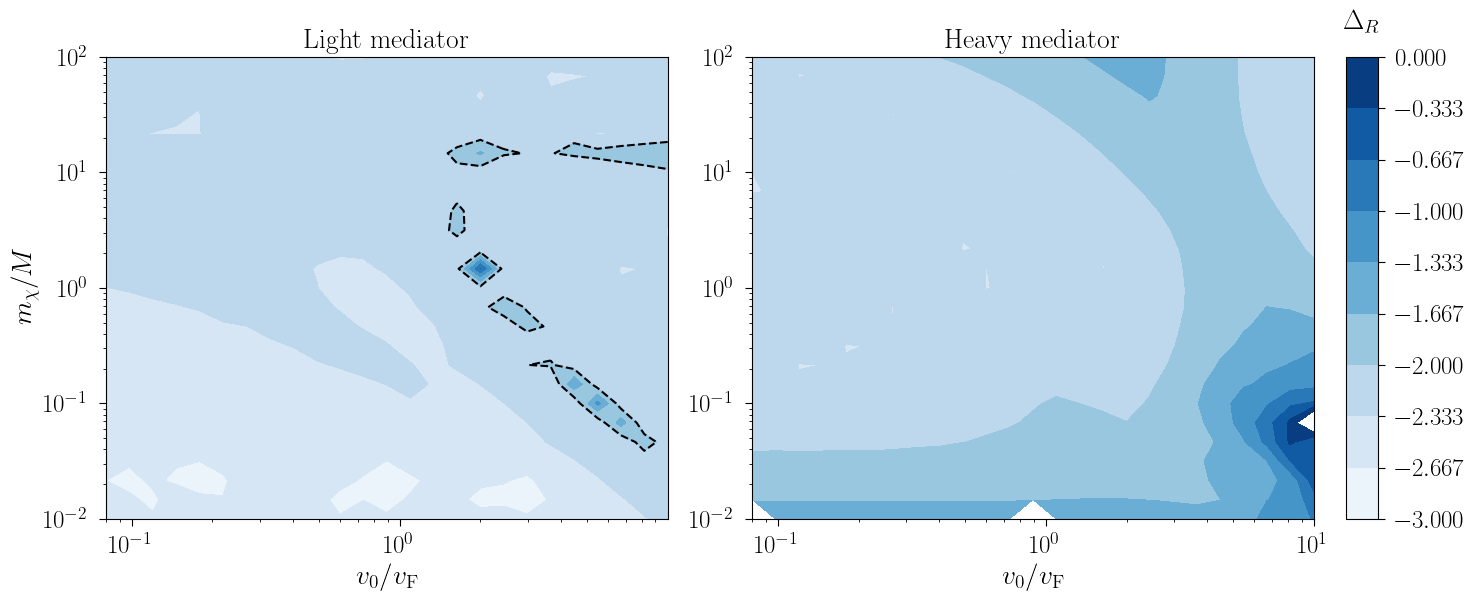

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)
fig.subplots_adjust(right=0.88, wspace=0.15)

for ax in (ax1, ax2):
    ax.loglog()
    ax.set_xlabel(r'$v_0/v_{\mathrm{F}}$')
    
levels = np.linspace(-3, 0, 10)    

ax = ax1
cs = ax.contourf(X_lm, Y_lm, np.log10(np.abs(Z_lm[:, :, 1]/Z_lm[:, :, 0])), levels=levels, cmap='Blues', vmax=0)
ax.contour(X_lm, Y_lm, np.log10(np.abs(Z_lm[:, :, 1]/Z_lm[:, :, 0])), levels=[-2], colors='k')
ax.set_ylabel(r'$m_\chi/M$')
ax.set_title('Light mediator')

ax = ax2
cs = ax.contourf(X_hm, Y_hm, np.log10(np.abs(Z_hm[:, :, 1]/Z_hm[:, :, 0])), levels=levels, cmap='Blues')
ax.set_title('Heavy mediator')

cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])
fig.colorbar(cs, cax=cbar_ax)
#cbar_ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xlabel('$\Delta_R$', labelpad=20)

Text(0.5, 0, '$\\Delta_R$')

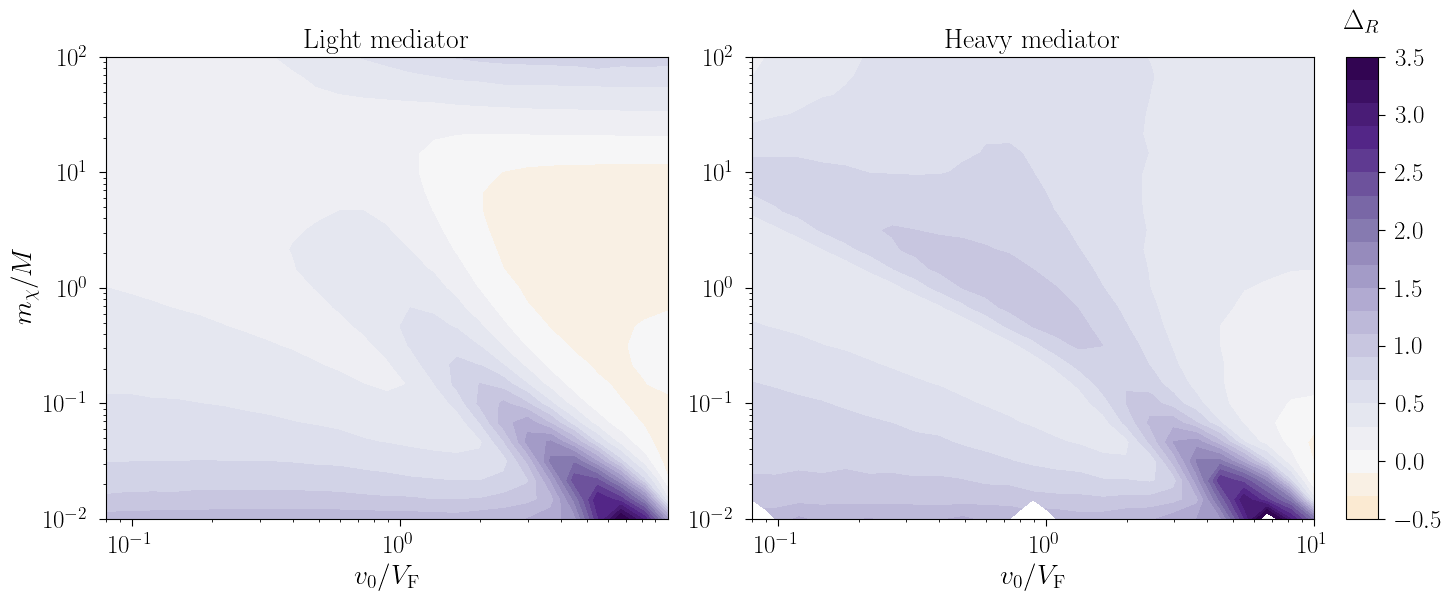

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(style.FIG_DOUBLE_SIZE)
fig.subplots_adjust(right=0.88, wspace=0.15)

for ax in (ax1, ax2):
    ax.loglog()
    ax.set_xlabel(r'$v_0/V_{\mathrm{F}}$')
    #ax.scatter(X_lm.ravel(), Y_lm.ravel(), c='r', zorder=1000)

Z_lm[:, :, 0][np.where(np.abs(Z_lm[:, :, 1] / Z_lm[:, :, 0]) > 1e-1)] = 0
Z_lm[:, :, 0][np.where(~np.isfinite(Z_lm[:, :, 0]))] = 0

#upper_bound = max(np.amax(Z_lm[:, :, 0]), np.amax(Z_hm[:, :, 0]))
#lower_bound = min(np.amin(Z_lm[:, :, 0]), np.amin(Z_hm[:, :, 0]))
upper_bound = 3.5
lower_bound = -0.5
levels = np.linspace(lower_bound, upper_bound, 21)

ax = ax1
cs = ax.contourf(X_lm, Y_lm, Z_lm[:, :, 0],
                 levels=levels, cmap='PuOr', vmin=-upper_bound, vmax=upper_bound)
#ax.contour(X_lm, Y_lm, Z_lm[:, :, 0], levels=[0], colors='k', linestyles='--')
ax.set_ylabel(r'$m_\chi/M$')
ax.set_title('Light mediator')

ax = ax2
cs = ax.contourf(
    X_hm, Y_hm, Z_hm[:, :, 0],
    levels=levels, cmap='PuOr', vmin=-upper_bound, vmax=upper_bound)
#cs_div = ax.contour(X_hm, Y_hm, Z_hm[:, :, 0], levels=[0], colors='k', linestyles='--')
ax.set_title('Heavy mediator')

cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])
cbar = fig.colorbar(cs, cax=cbar_ax)
#cbar.add_lines(cs_div)
cbar_ax.set_yticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xlabel('$\Delta_R$', labelpad=20)

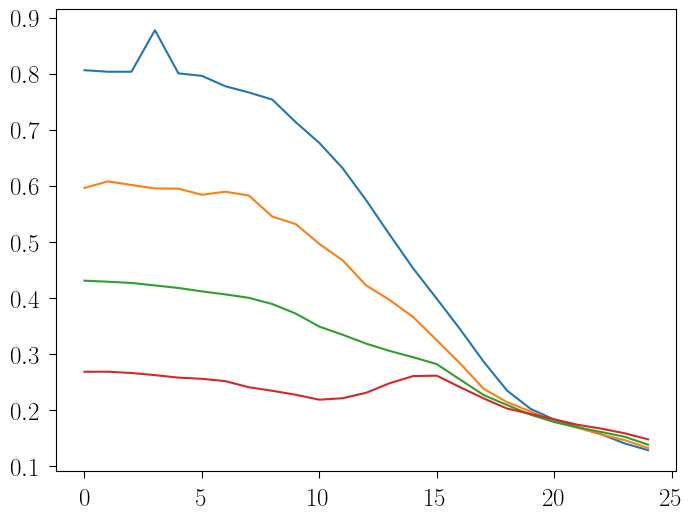

In [17]:
plt.plot(Z_lm[0, :, 0])
plt.plot(Z_lm[1, :, 0])
plt.plot(Z_lm[2, :, 0])
plt.plot(Z_lm[3, :, 0])

In [108]:
Z_lm[0, 3]

array([0.95775663, 0.00890255])

In [109]:
X_lm[0, 3], Y_lm[0, 3]

(5.468727057042106, 100.0)

In [3]:
from aeg.rate import delta_r, mass_vector, mean_rate, Scaler

In [13]:
s = Scaler(0.137593 / 7**2)
s.v_0

9.912414807374308

In [ ]:
delta_r(s, mX=mass, m=mass_vector(8.), w_min=1e-2*s.eV, w_max=1e1*s.eV)

In [113]:
%%time
vr = X_lm[0, 3]
mass = Y_lm[0, 3]
s = Scaler(0.137593 / vr**2)
Z_lm[0, 3] = delta_r(s, mX=mass, m=mass_vector(8.), w_min=1e-2*s.eV, w_max=1e1*s.eV)

CPU times: user 50.6 s, sys: 16.8 s, total: 1min 7s
Wall time: 10.6 s


In [ ]:
redo = 

In [6]:
s = Scaler(0.137593 / 3**2)
delta_r(s, mX=0.1, m=mass_vector(8.), w_min=1e-2*s.eV, w_max=10*s.eV)

(0.9120944693940153, 0.0023163007613682817)

In [114]:
Z_lm[0, 3]

array([1.59844978e-04, 6.75181210e-07])

In [60]:
Z_lm[0, :, 0]

array([-5.14085657e-02, -8.24057014e-02, -1.01535693e-01,  1.50936333e-04,
       -1.36889695e-01, -1.44005534e-01, -1.30060710e-01, -9.63199208e-02,
       -3.80644795e-02,  3.89661095e-02,  1.15206460e-01,  1.77290258e-01,
        2.10681110e-01,  2.31820229e-01,  2.35519993e-01,  2.22329679e-01,
        2.08231190e-01,  1.94795649e-01,  1.85606396e-01,  1.76663123e-01,
        1.68139350e-01,  1.60028887e-01,  1.51927655e-01,  1.41319946e-01,
        1.27358666e-01])

In [56]:
delta_r(s, mX=mass, m=mass_vector(2.), w_min=1e-2*s.eV, w_max=1e1*s.eV)

(0.00015124995471002694, 3.4777446266686516e-07)

In [57]:
delta_r(s, mX=mass, m=mass_vector(20.), w_min=1e-2*s.eV, w_max=1e1*s.eV)

(0.0002601568862203353, 1.277776140440531e-06)

In [48]:
%%time
vr = X_lm[1, 3]
mass = Y_lm[1, 3]
s = Scaler(0.137593 / vr**2 * 2)
Z_lm[1, 3] = delta_r(s, mX=mass, m=mass_vector(20.), w_min=1e-2*s.eV, w_max=1e1*s.eV, n_points_init=int(1e8))

CPU times: user 1h 11min 37s, sys: 25min 30s, total: 1h 37min 7s
Wall time: 12min 52s


In [51]:
mean_rate(s, mX=mass, m=mass_vector(20.), w_min=1e-2*s.eV, w_max=1e1*s.eV, n_points_init=int(1e7))

(6.31920396237447, 0.017900852475174298)

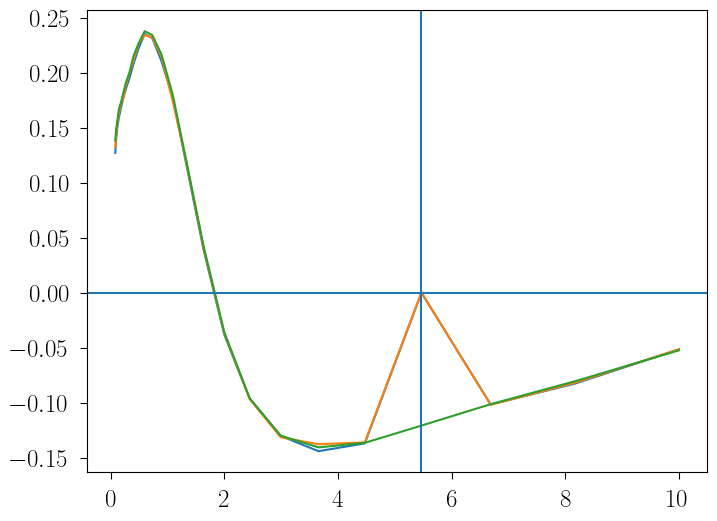

In [63]:
plt.plot(X_lm[0], Z_lm[0, :, 0])
plt.plot(X_lm[0], Z_lm[1, :, 0])
plt.plot(X_lm[0], Z_lm[2, :, 0])
plt.axhline(1.50936333e-04)
plt.axvline(X_lm[0, 3])

In [36]:
fig.savefig('figures/modulation_dm_mass.pdf', bbox_inches='tight', transparent=True)

In [23]:
Y_lm[12]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

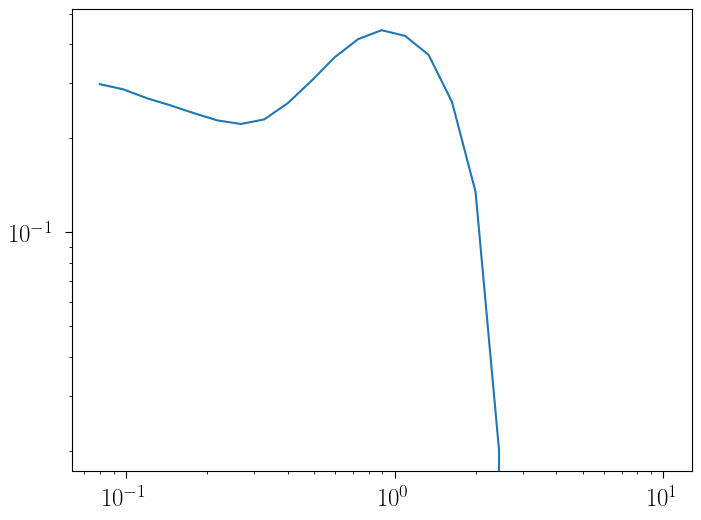

In [24]:
plt.loglog(X_lm[12], (Z_lm[12, :, 0]))

In [200]:
Scaler(11.7).v_0

0.1535630279132329

In [208]:
X_lm[:, -4]

array([0.14628633, 0.14628633, 0.14628633, 0.14628633, 0.14628633,
       0.14628633, 0.14628633, 0.14628633, 0.14628633, 0.14628633,
       0.14628633, 0.14628633, 0.14628633, 0.14628633, 0.14628633,
       0.14628633, 0.14628633, 0.14628633, 0.14628633, 0.14628633,
       0.14628633, 0.14628633, 0.14628633, 0.14628633, 0.14628633])

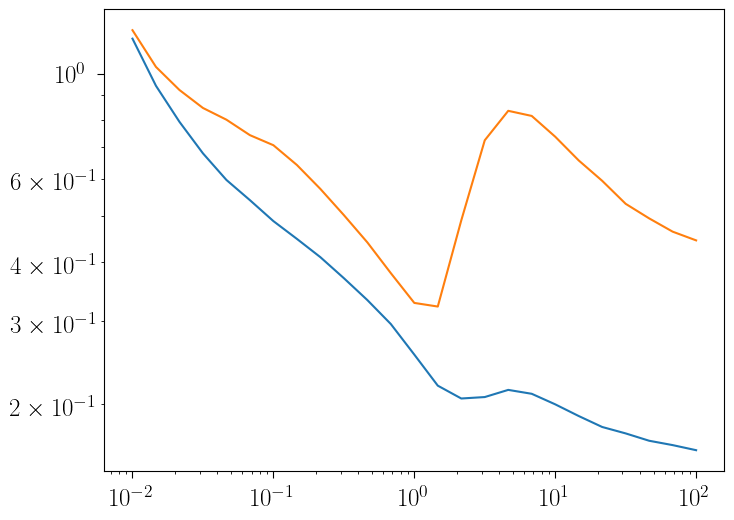

In [211]:
plt.loglog(Y_lm[:, -4], (Z_lm[:, -4, 0]))
plt.loglog(Y_hm[:, -4], (Z_hm[:, -4, 0]))

Text(0.5, 0, '$\\Delta_R$')

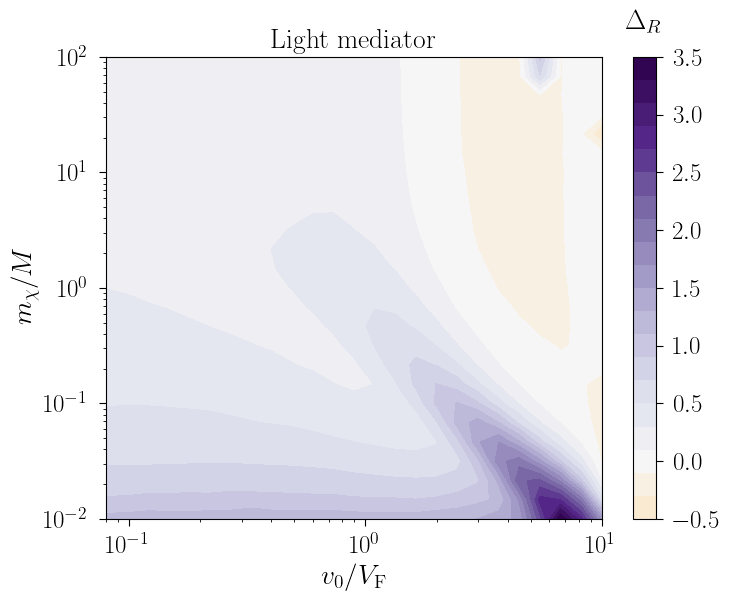

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(style.FIG_SINGLE_SIZE)

ax.loglog()
ax.set_xlabel(r'$v_0/V_{\mathrm{F}}$')

Z_lm[:, :, 0][np.where(np.abs(Z_lm[:, :, 1] / Z_lm[:, :, 0]) > 1e-1)] = 0
Z_lm[:, :, 0][np.where(~np.isfinite(Z_lm[:, :, 0]))] = 0

upper_bound = 3.5
lower_bound = -0.5
levels = np.linspace(lower_bound, upper_bound, 21)

cs = ax.contourf(X_lm, Y_lm, Z_lm[:, :, 0],
                 levels=levels, cmap='PuOr', vmin=-upper_bound, vmax=upper_bound)
#ax.contour(X_lm, Y_lm, Z_lm[:, :, 0], levels=[0], colors='k', linestyles='--')
ax.set_ylabel(r'$m_\chi/M$')
ax.set_title('Light mediator')

cbar = fig.colorbar(cs)
cbar_ax = cbar.ax
#cbar.add_lines(cs_div)
cbar_ax.set_yticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xlabel('$\Delta_R$', labelpad=20)

In [72]:
fig.savefig('figures/modulation_dm_mass_lm.pdf', bbox_inches='tight', transparent=True)

# Fig. 9

# Fig. 10